In [9]:
#import packages
import pandas as pd
import sys
import matplotlib.pyplot as plt
from datetime import datetime
import logging
import numpy as np
import copy

#custom classes
from classes import classes as cl
from functions import functions as fc
from functions import routing as rt
from functions import simulated_annealing as sa
import random

plt.rcParams.update({'font.size': 22})
logging.basicConfig(filename="sa_worst_mixed_opposite.log", level=logging.INFO)

init_path = 'output/initial_solution'
img_exp_path = 'output/graphs/sa_worst_mixed_opposite/'

Initiation

In [10]:
fc.print_log("Starting initiation")
#create empty dict
initiation_objects = {'dict_depots': '', 'dict_sites': '', 'dict_plants': '', 'dict_jobs': '', 'dict_tours': '', 'list_days': ''}


objects = fc.initiate(initiation_objects,init_path,'final')

#load objects
list_days = objects['list_days']
dict_depots = objects['dict_depots']
dict_sites = objects['dict_sites']
dict_plants = objects['dict_plants']
dict_jobs = objects['dict_jobs']
dict_tours = objects['dict_tours']

#also create lists for convenience
list_depots = [dict_depots[element] for element in dict_depots]
list_sites = [dict_sites[element] for element in dict_sites]
list_plants = [dict_plants[element] for element in dict_plants]
list_jobs = [dict_jobs[element] for element in dict_jobs]
list_tours  = [dict_tours[element] for element in dict_tours]

fc.print_log("Done with initiation")


Starting initiation- t: 00:19:26
Starting initiation at 00:19:26- t: 00:19:26
Done with initiation- t: 00:19:30


In the first stage only one depot ist handled, so moves so its all about dropoff and pickup dates

In [11]:
#ov tours
for depot in dict_depots:
    total_tasks = 0
    total_distance = 0
    for day in list_days:
        total_tasks += dict_tours[depot][day].total_tasks
        total_distance += dict_tours[depot][day].distance
    print("Depot: {}, tasks: {} - distance: {}".format(depot,total_tasks,total_distance))

print("done here")


Depot: Neuherberg, tasks: 25454 - distance: 4547134.5148212565
Depot: Lauterhofen, tasks: 14329 - distance: 2151298.5445965845
Depot: Altbach, tasks: 5534 - distance: 648999.0083624776
Depot: Deisslingen, tasks: 0 - distance: 0
Depot: Bollschweil, tasks: 1586 - distance: 167723.71699792094
Depot: Lampertheim, tasks: 5872 - distance: 1059256.2914196497
Depot: Neuss, tasks: 19062 - distance: 2374315.453137417
Depot: Embsen, tasks: 9216 - distance: 1121736.368534145
Depot: Rottleberode, tasks: 25304 - distance: 6393335.900862845
Depot: Fenne, tasks: 0 - distance: 0
Depot: Castrop, tasks: 0 - distance: 0
Depot: Perl, tasks: 0 - distance: 0
Depot: Gnetsch, tasks: 0 - distance: 0
Depot: Vogelsdorf, tasks: 0 - distance: 0
Depot: Sukow, tasks: 0 - distance: 0
done here


start here
Start Inital Solution Plot- t: 00:19:30
Done with  Inital Solution Plot- t: 00:19:36


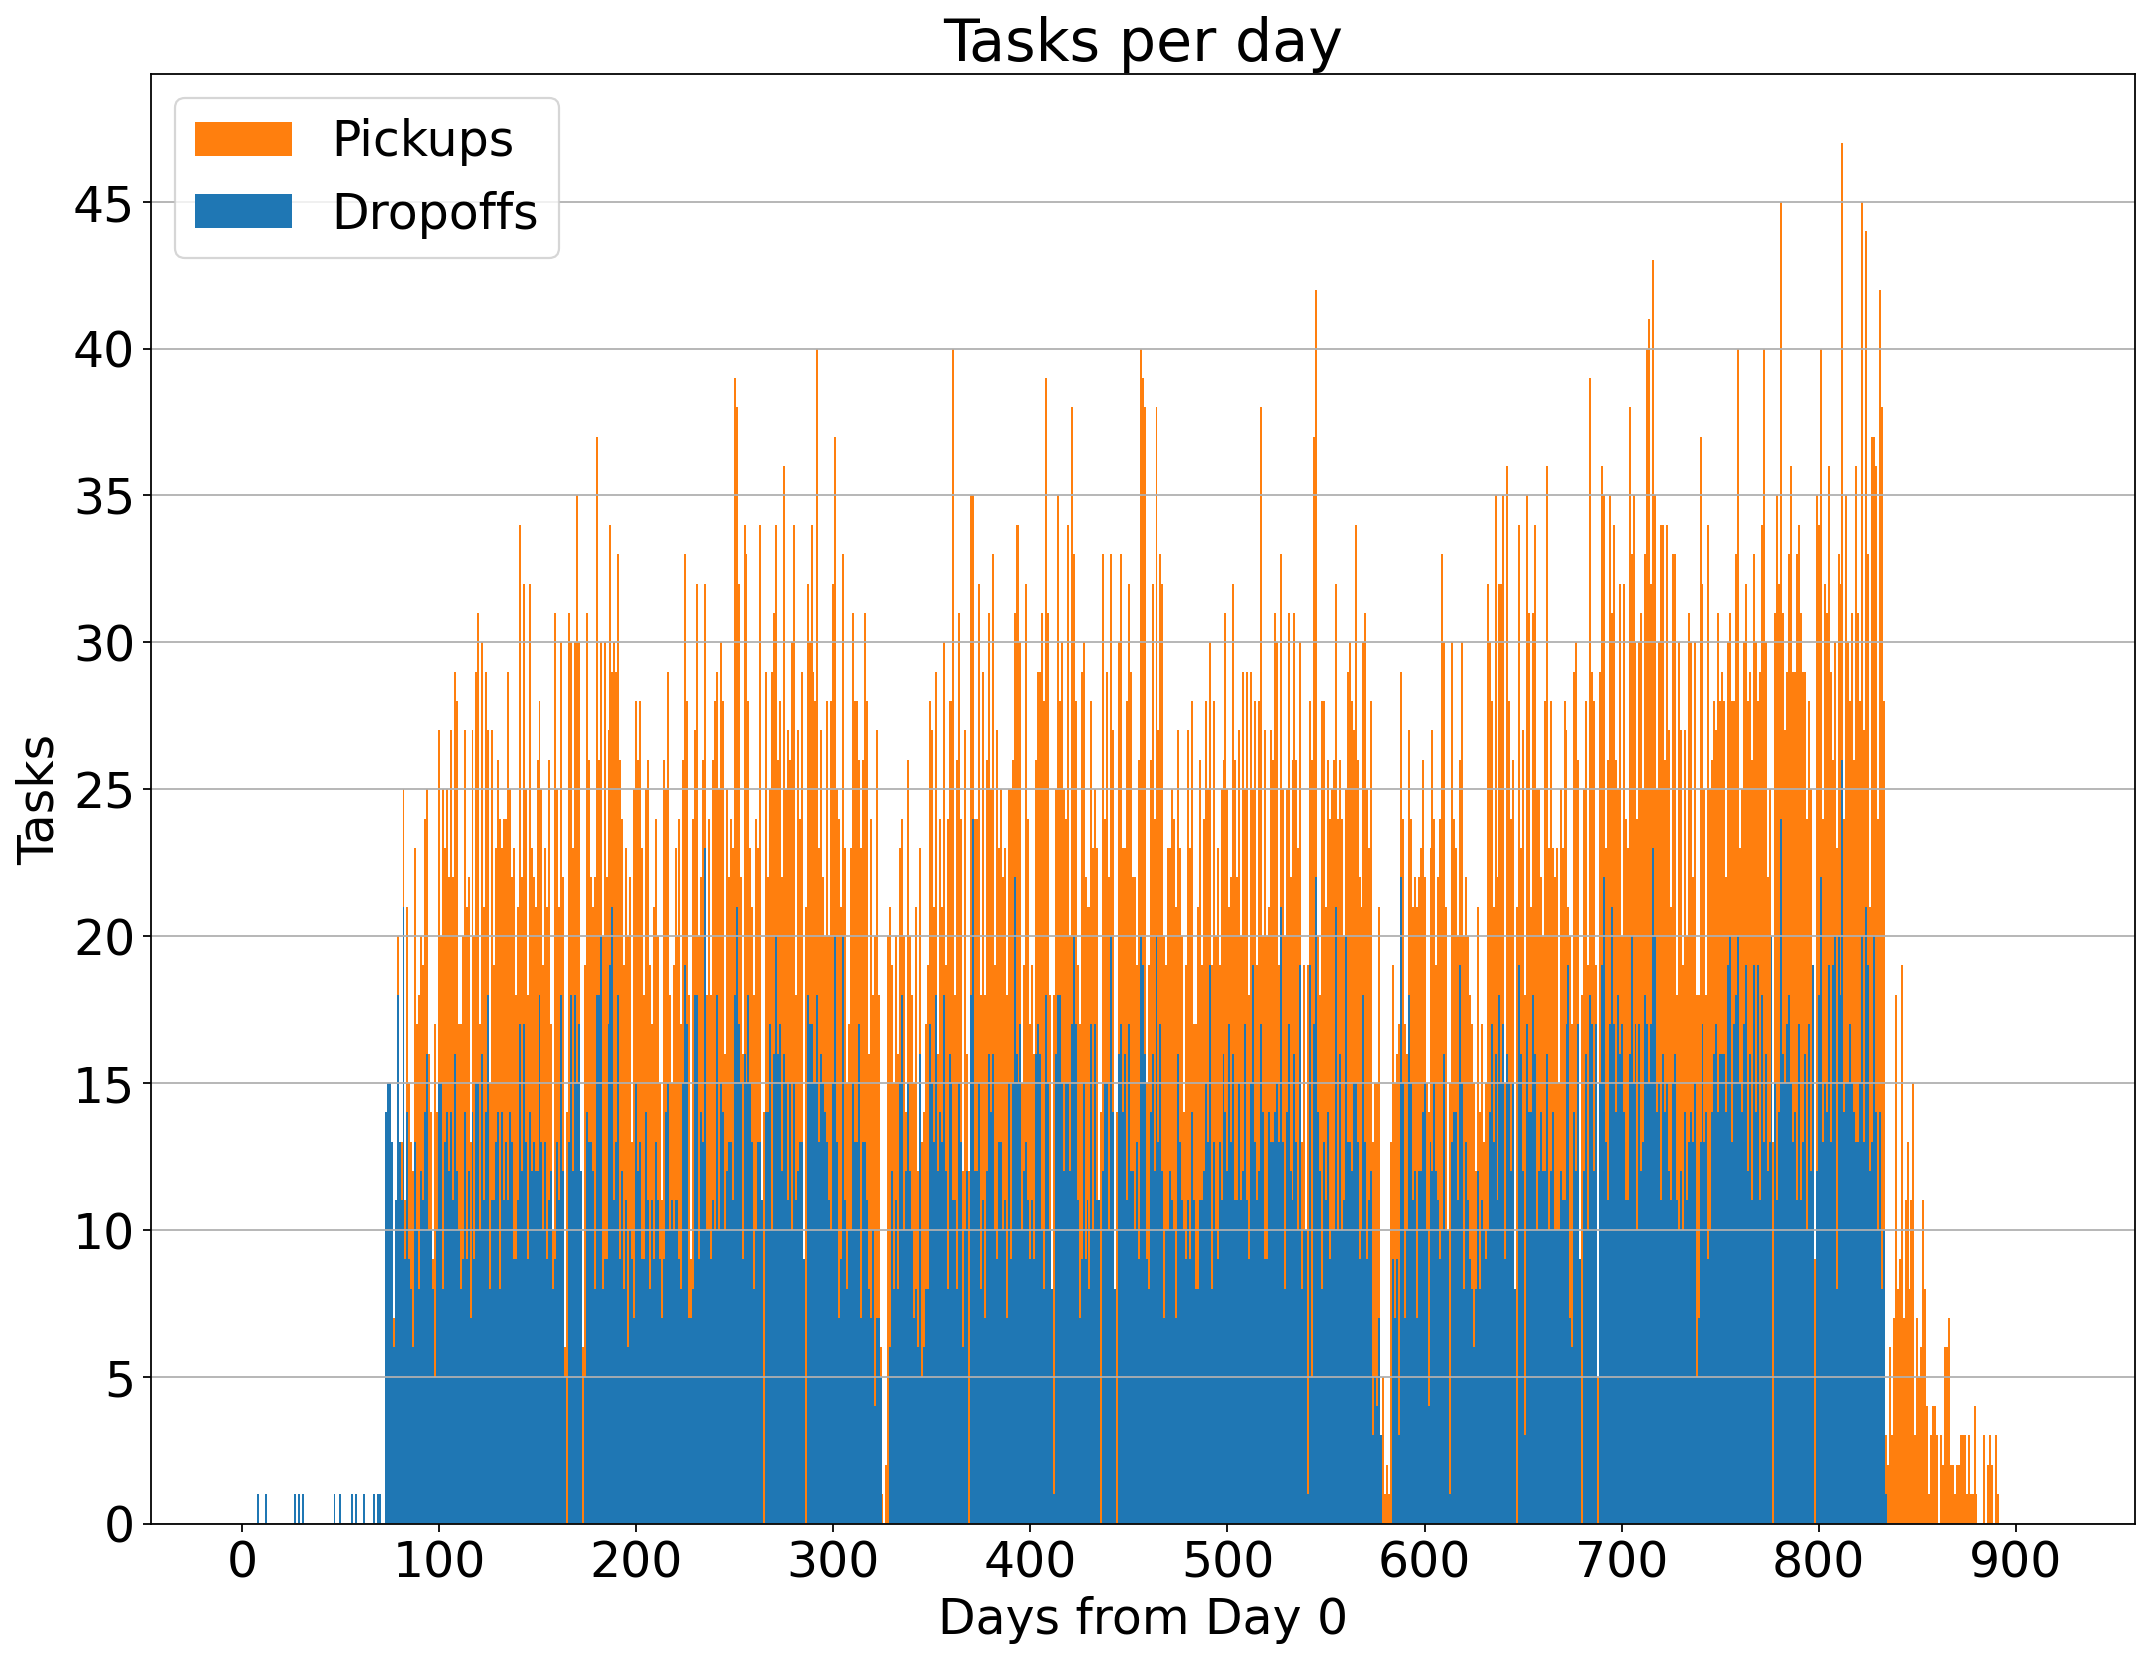

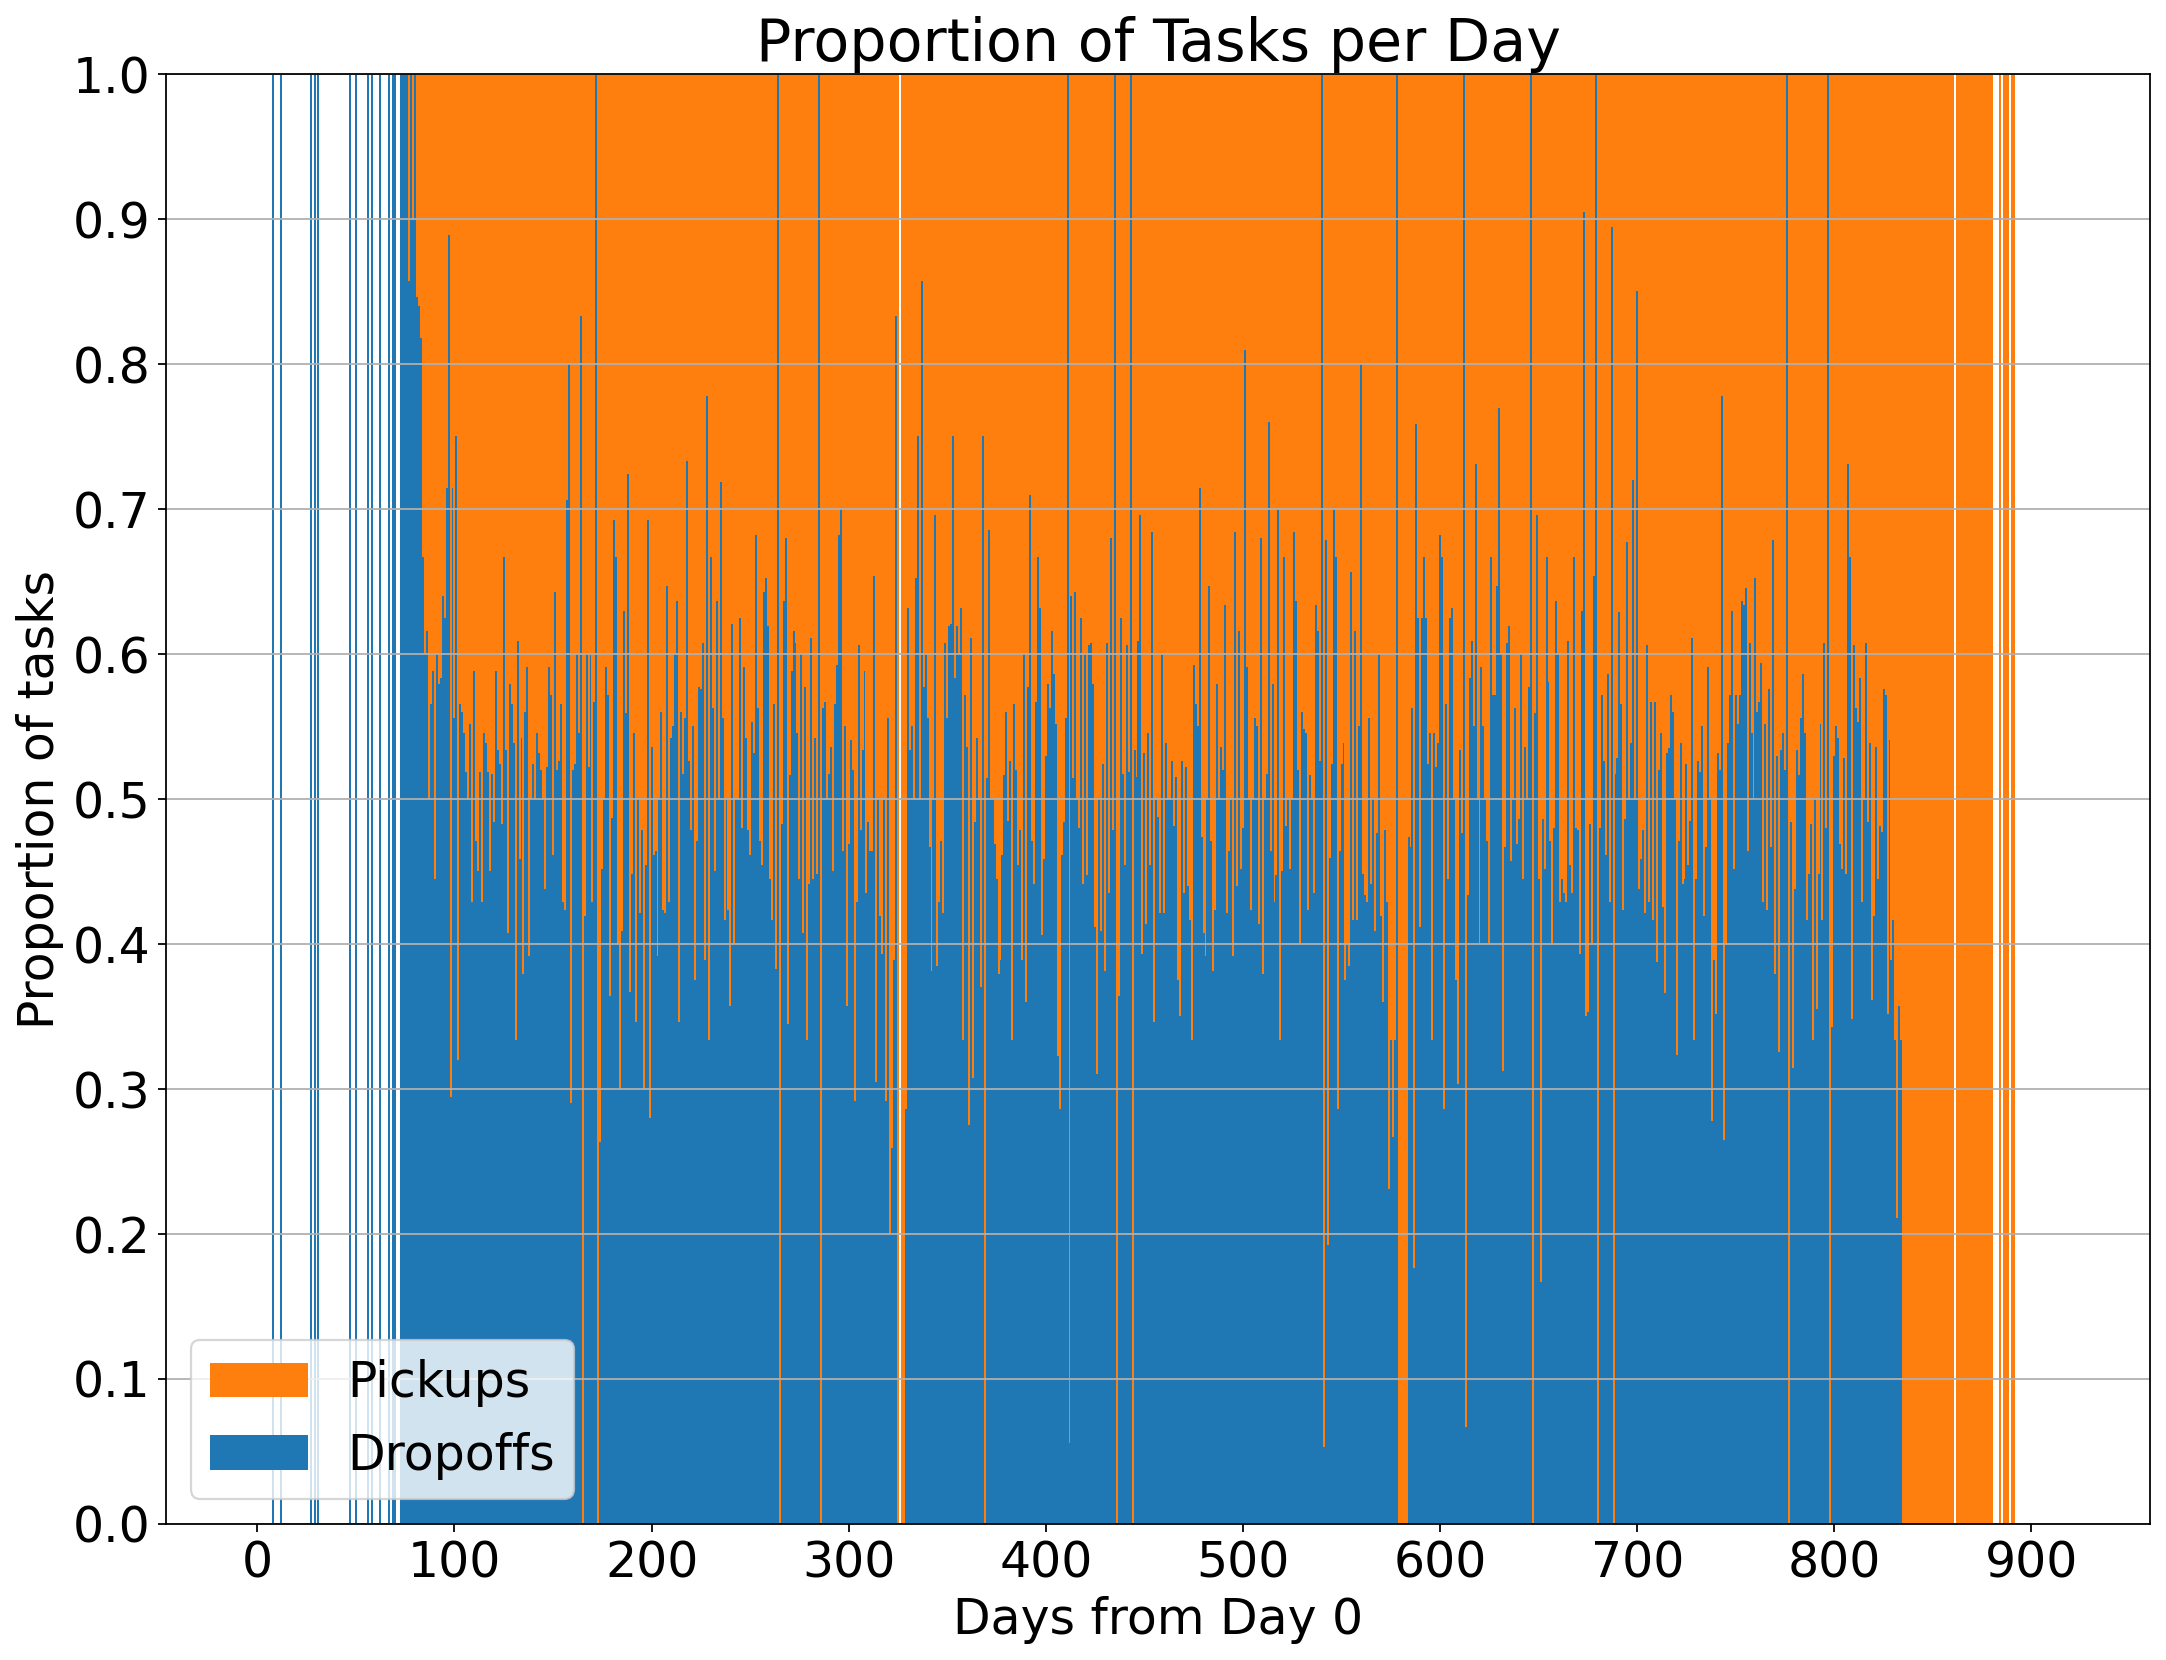

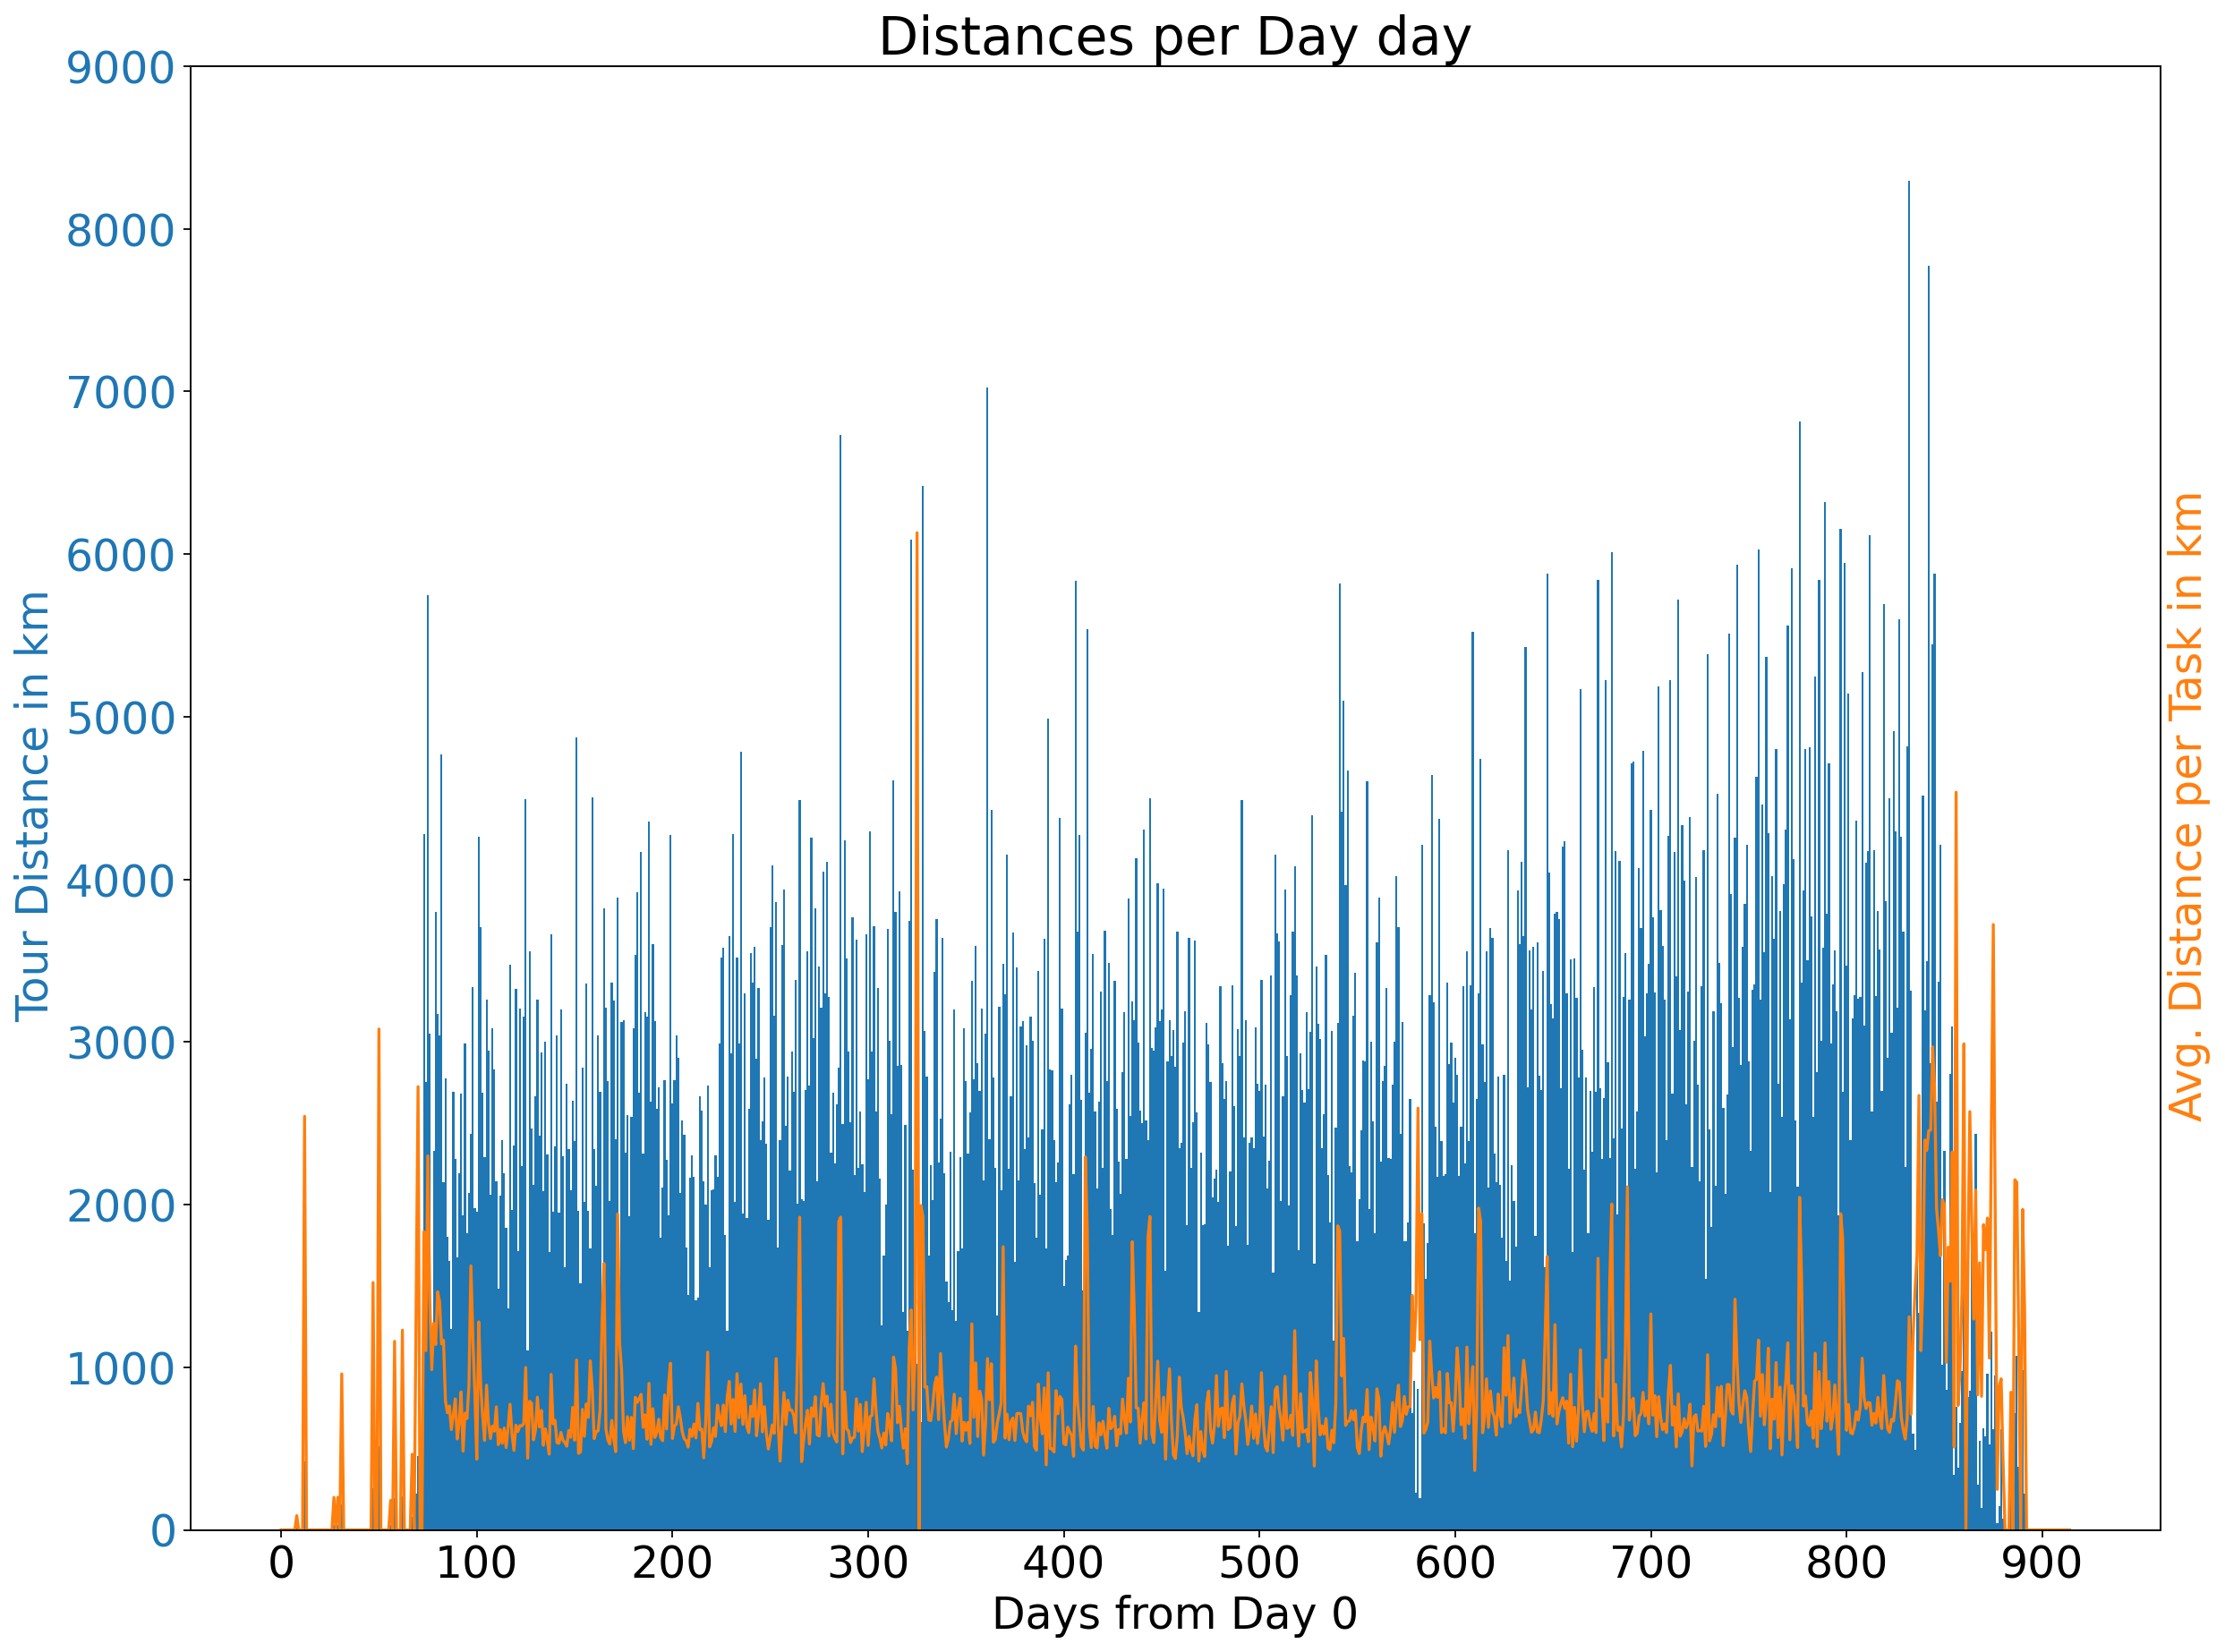

In [12]:
print("start here")
fc.print_log("Start Inital Solution Plot")

#only work with one depot
temp_depot = dict_depots['Neuss']
list_depots = [temp_depot]
dict_depots = {'Neuss': temp_depot}



solution_initial = cl.Solution(temp_depot,dict_tours,list_days)

solution_initial.plot_tasks(50,exp_prefix = img_exp_path + 'solution_inital_', plot = False)
solution_initial.plot_task_proportion(exp_prefix = img_exp_path + 'solution_inital_', plot = False)
solution_initial.plot_distances(10000,1500,exp_prefix = img_exp_path + 'solution_inital_', plot = False)

fc.print_log("Done with  Inital Solution Plot")



After having a look at the inital solution, start optimizing

Stage 1: Try to level out the proportions between dropoff and pickup on eatch job


Start with Stage 1a- t: 00:19:41
2594.8802766529147
Start Random Moves with heuristics- t: 00:19:41
logging at 1- t: 00:19:42 1                                  
logging at 501- t: 00:21:27 466                                  
logging at 1001- t: 00:23:26 922                                  
logging at 1501- t: 00:25:26 1343                                  
logging at 2001- t: 00:27:33 1763                                  
trycount exit for pickup- t: 00:28:22                              
Trycount Exit for pickup - it: 2143- t: 00:28:22
['pair', 'pickup', 'dropoff']
rechose from ['pair', 'dropoff']
trycount exit- t: 00:28:22s: 1889                                  
Trycount Exit for pair - it: 2144- t: 00:28:22
['pair', 'dropoff']
rechose from ['dropoff']
trycount exit for dropoff- t: 00:28:30                             
Trycount Exit for dropoff - it: 2170- t: 00:28:30
['dropoff']
No more movetypes- t: 00:28:30914                                  
refill
trycount exit for pickup

C:\Users\Nutzer\Documents\GitHub\rrp_simulated_annealing\classes\classes.py:212: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(num=None, figsize=(16, 12), dpi=160, facecolor='w', edgecolor='k')
C:\Users\Nutzer\anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


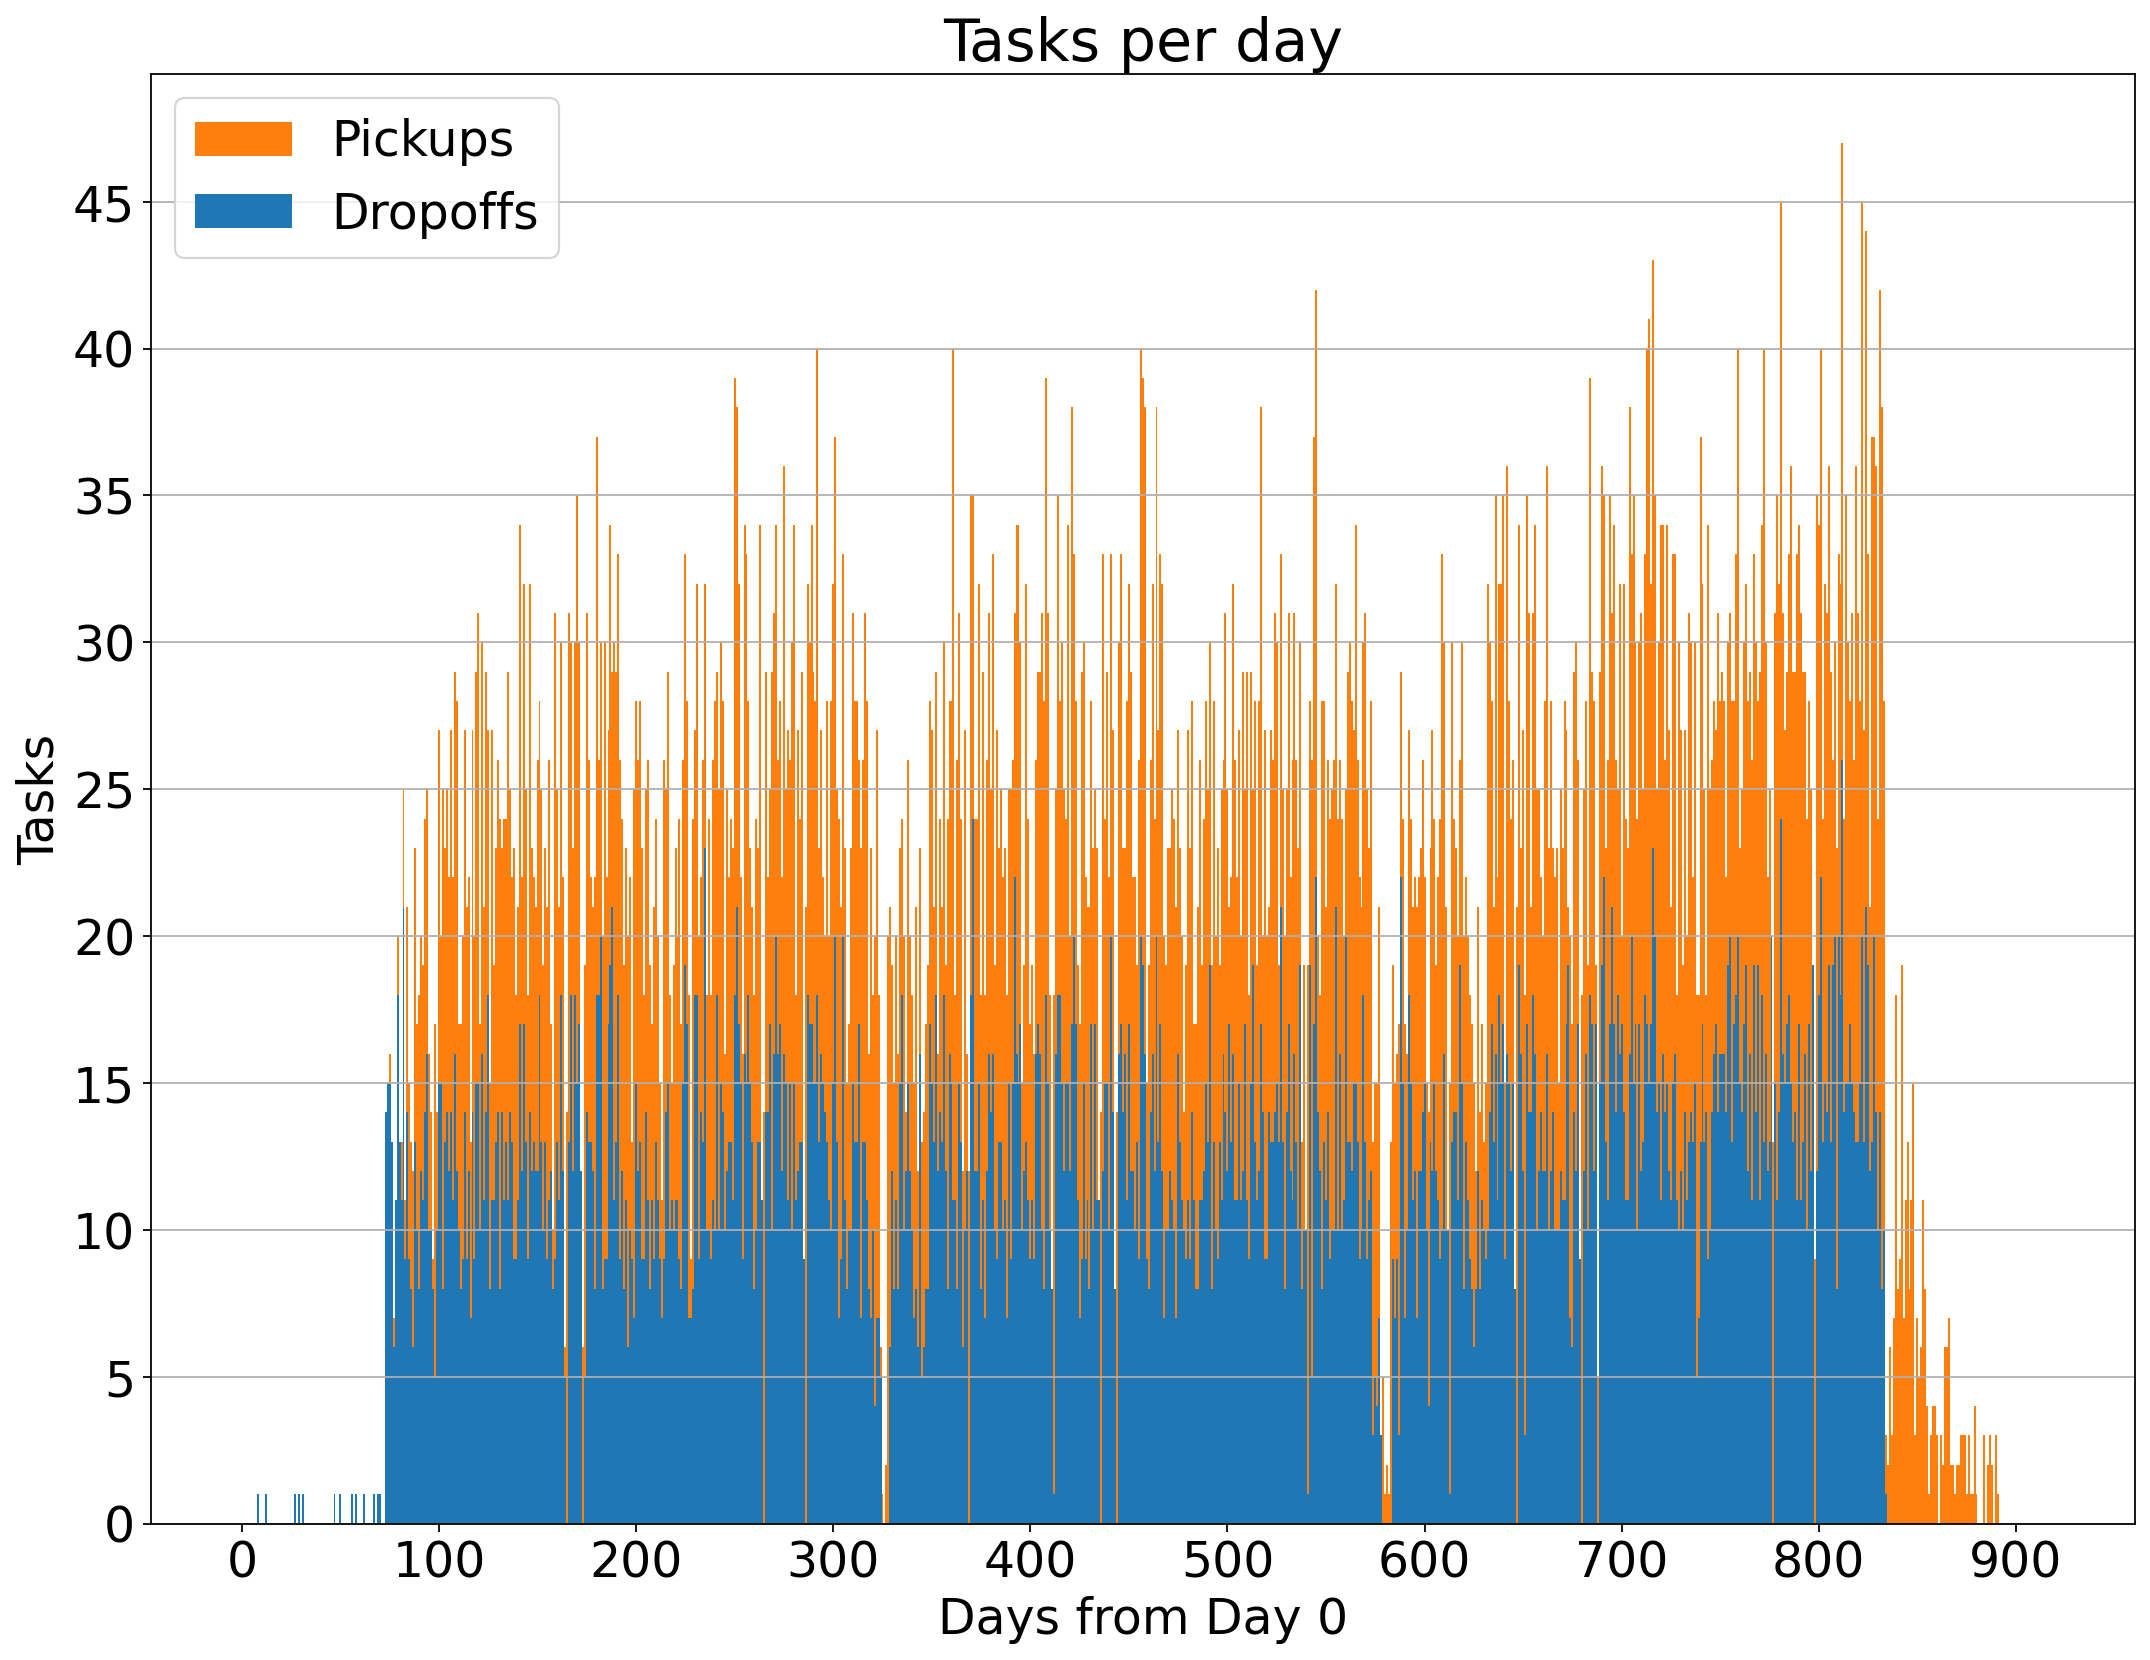

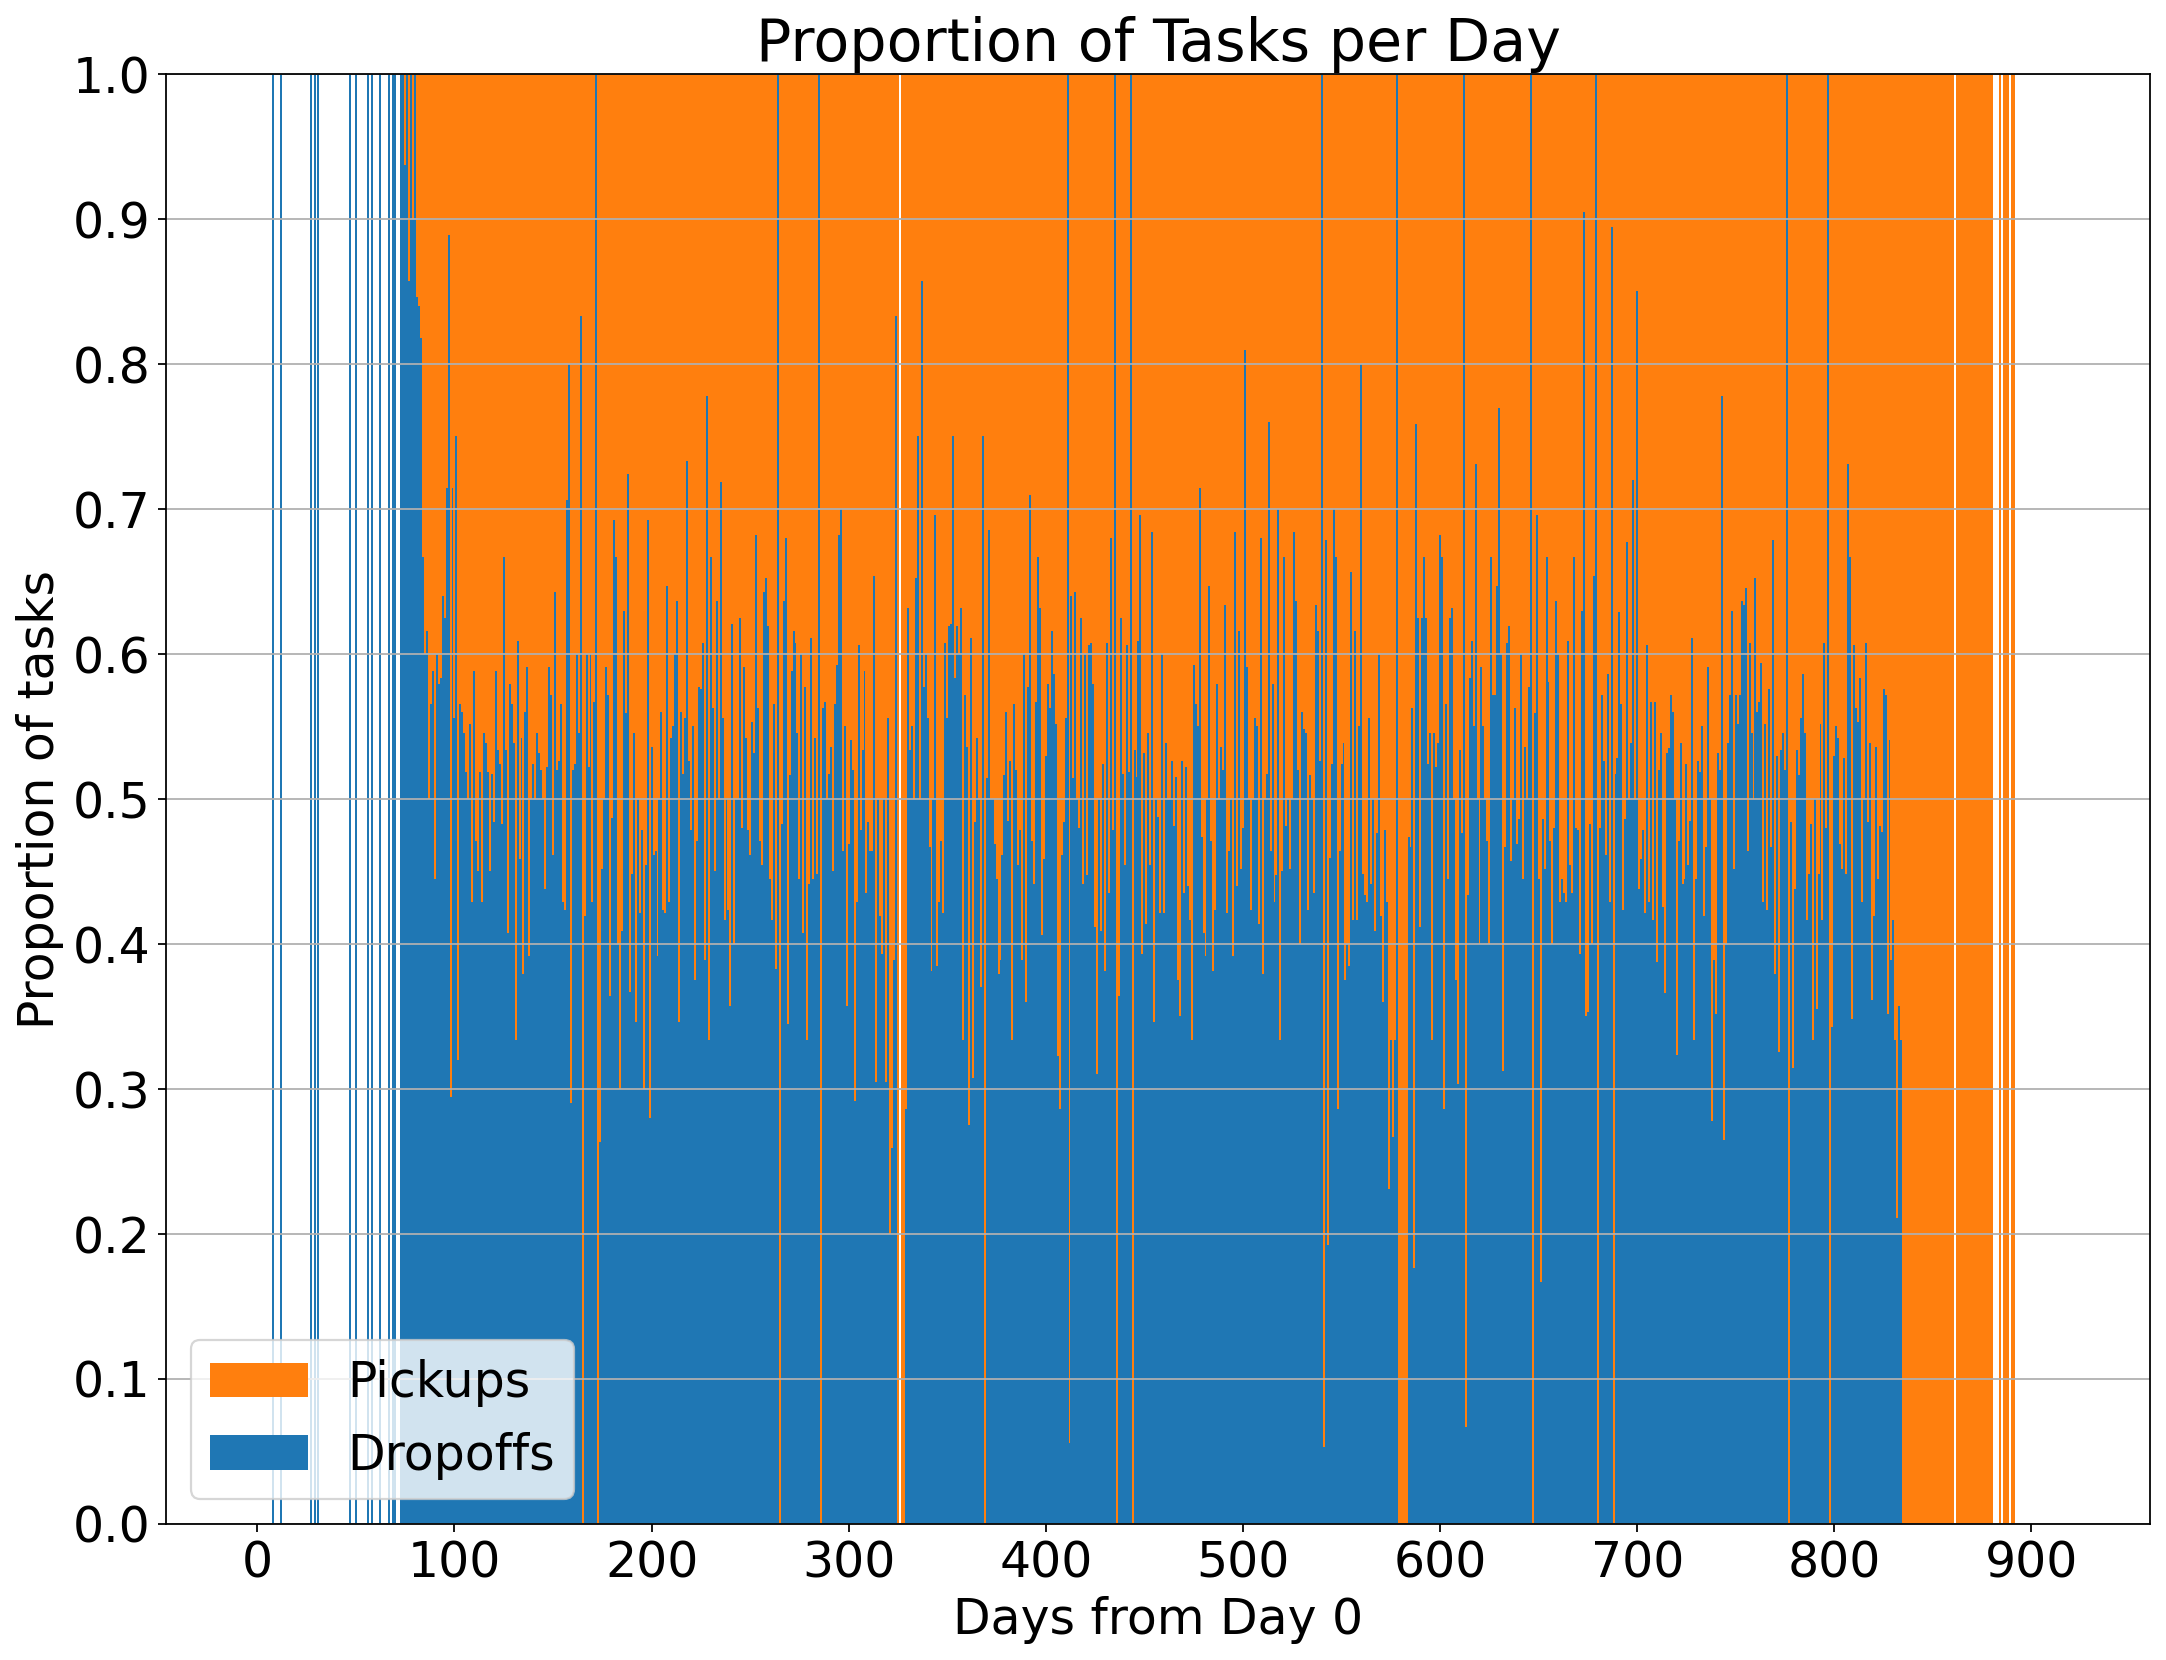

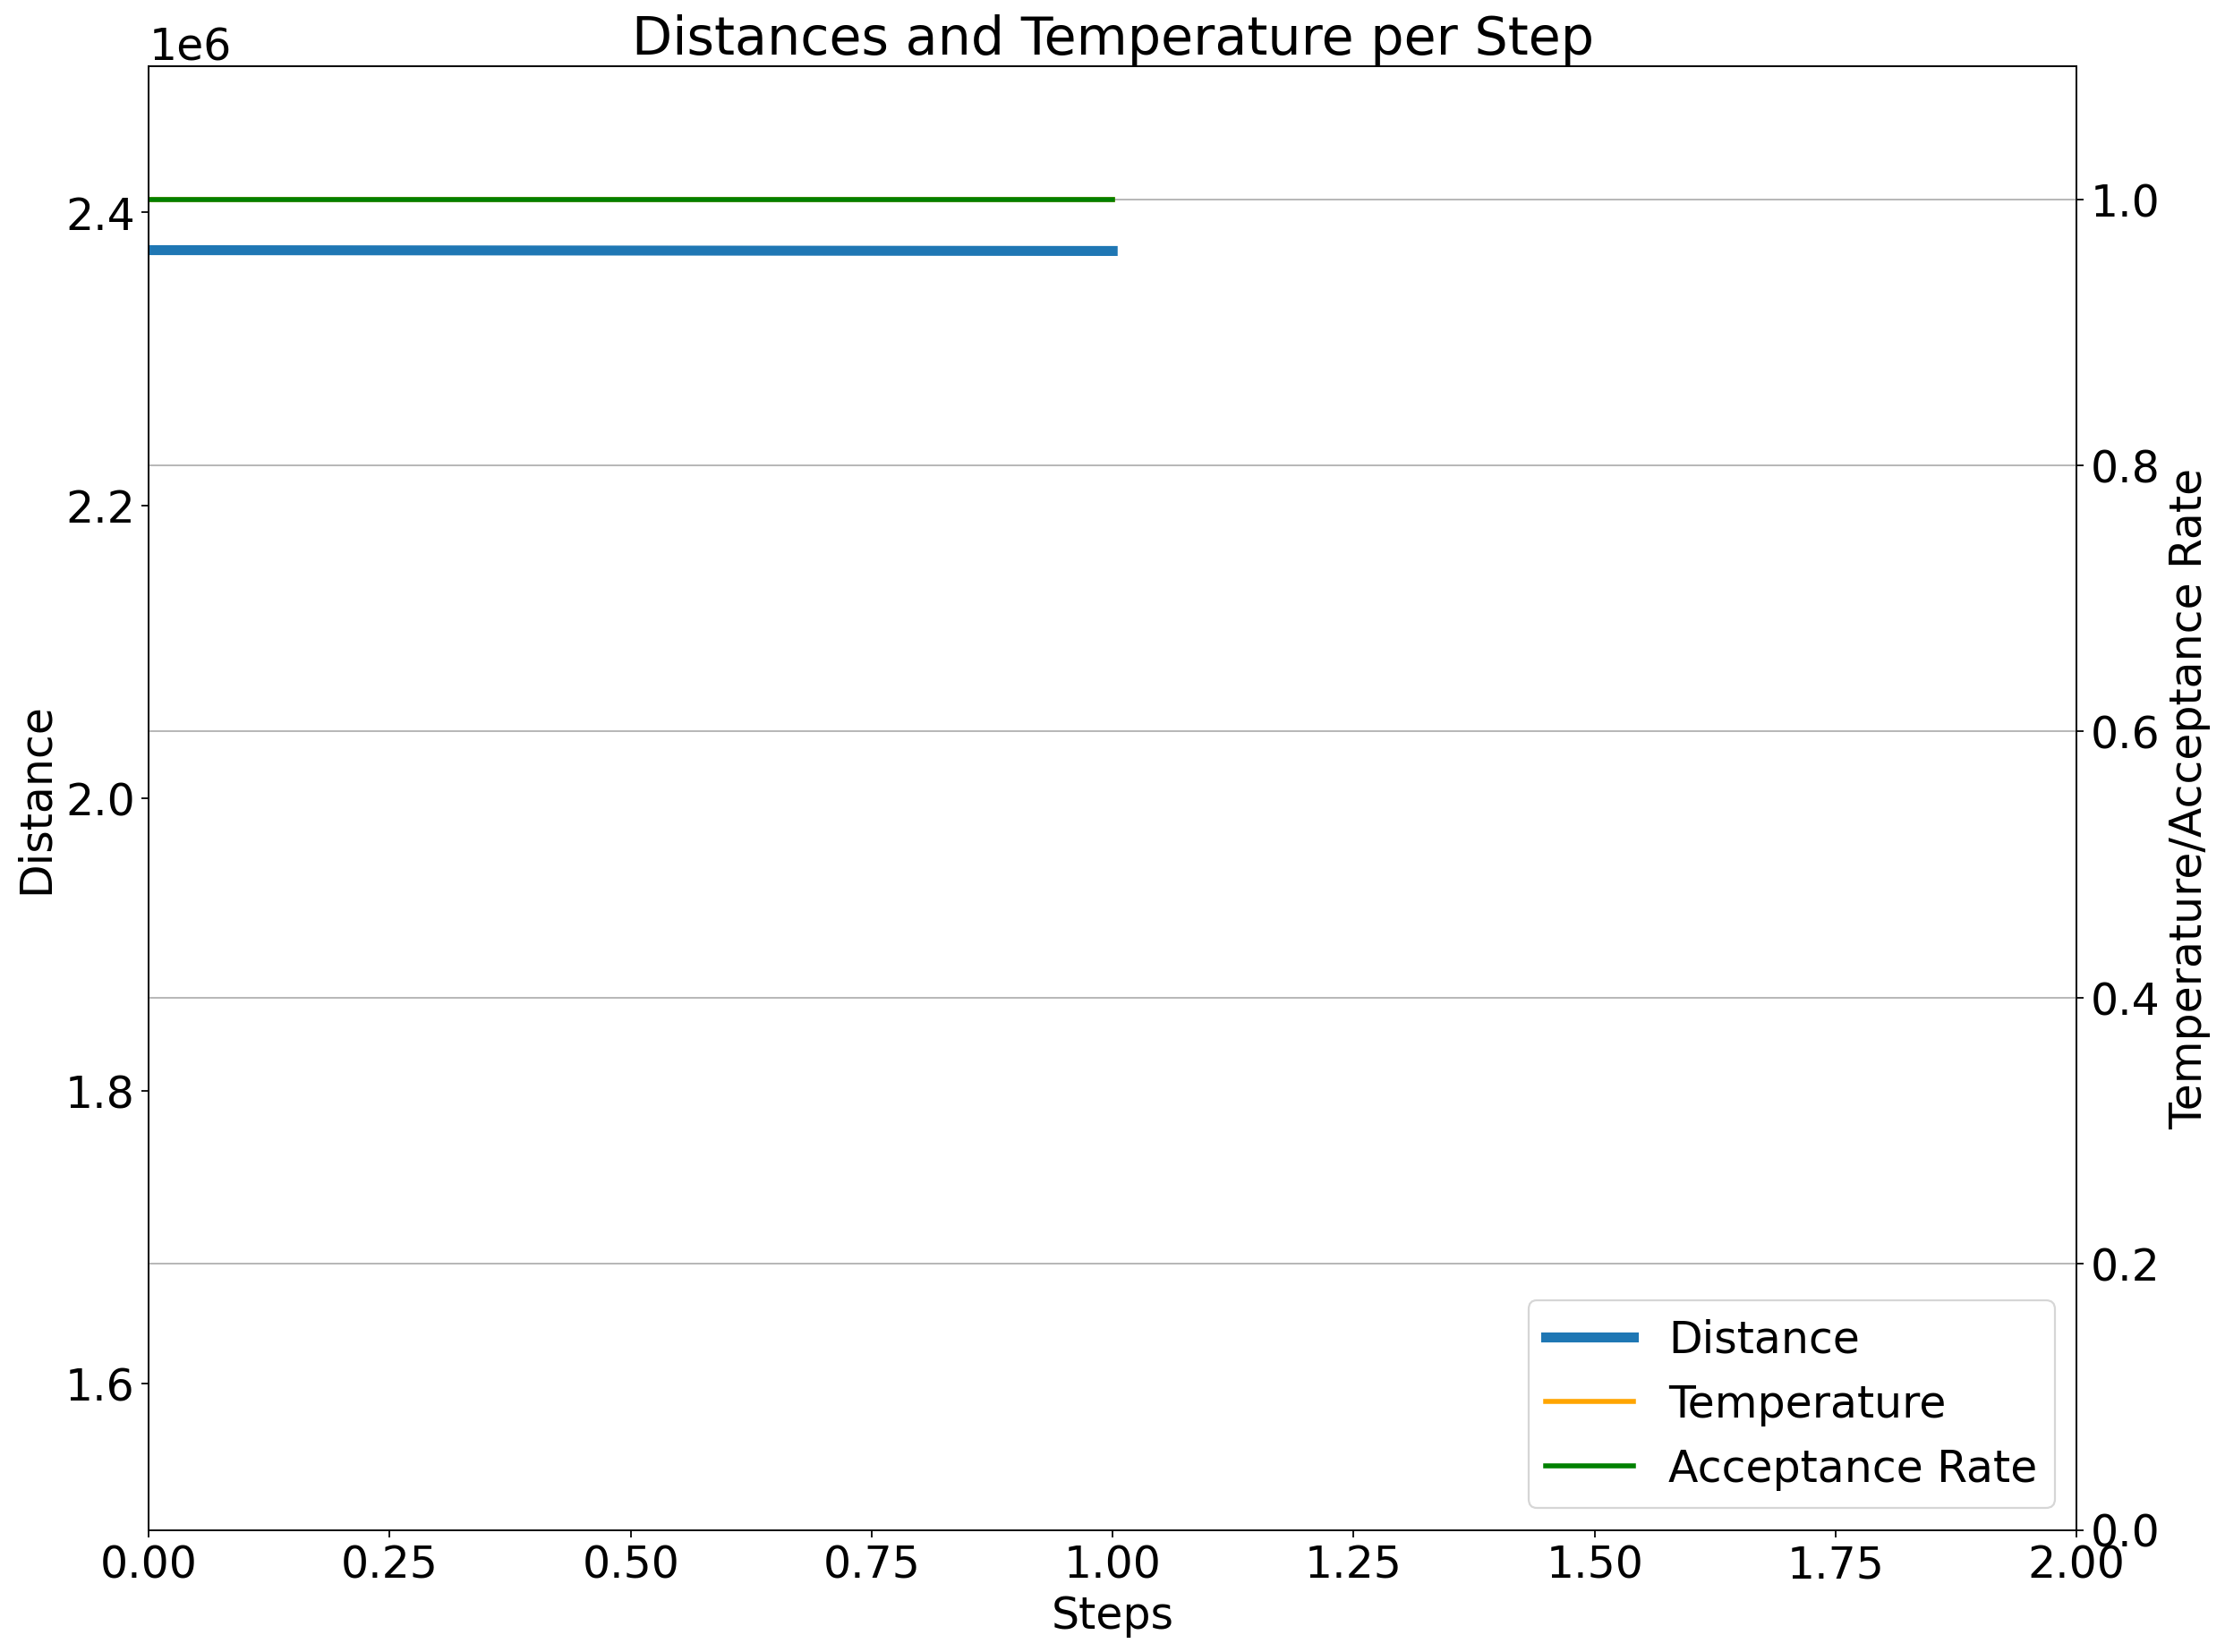

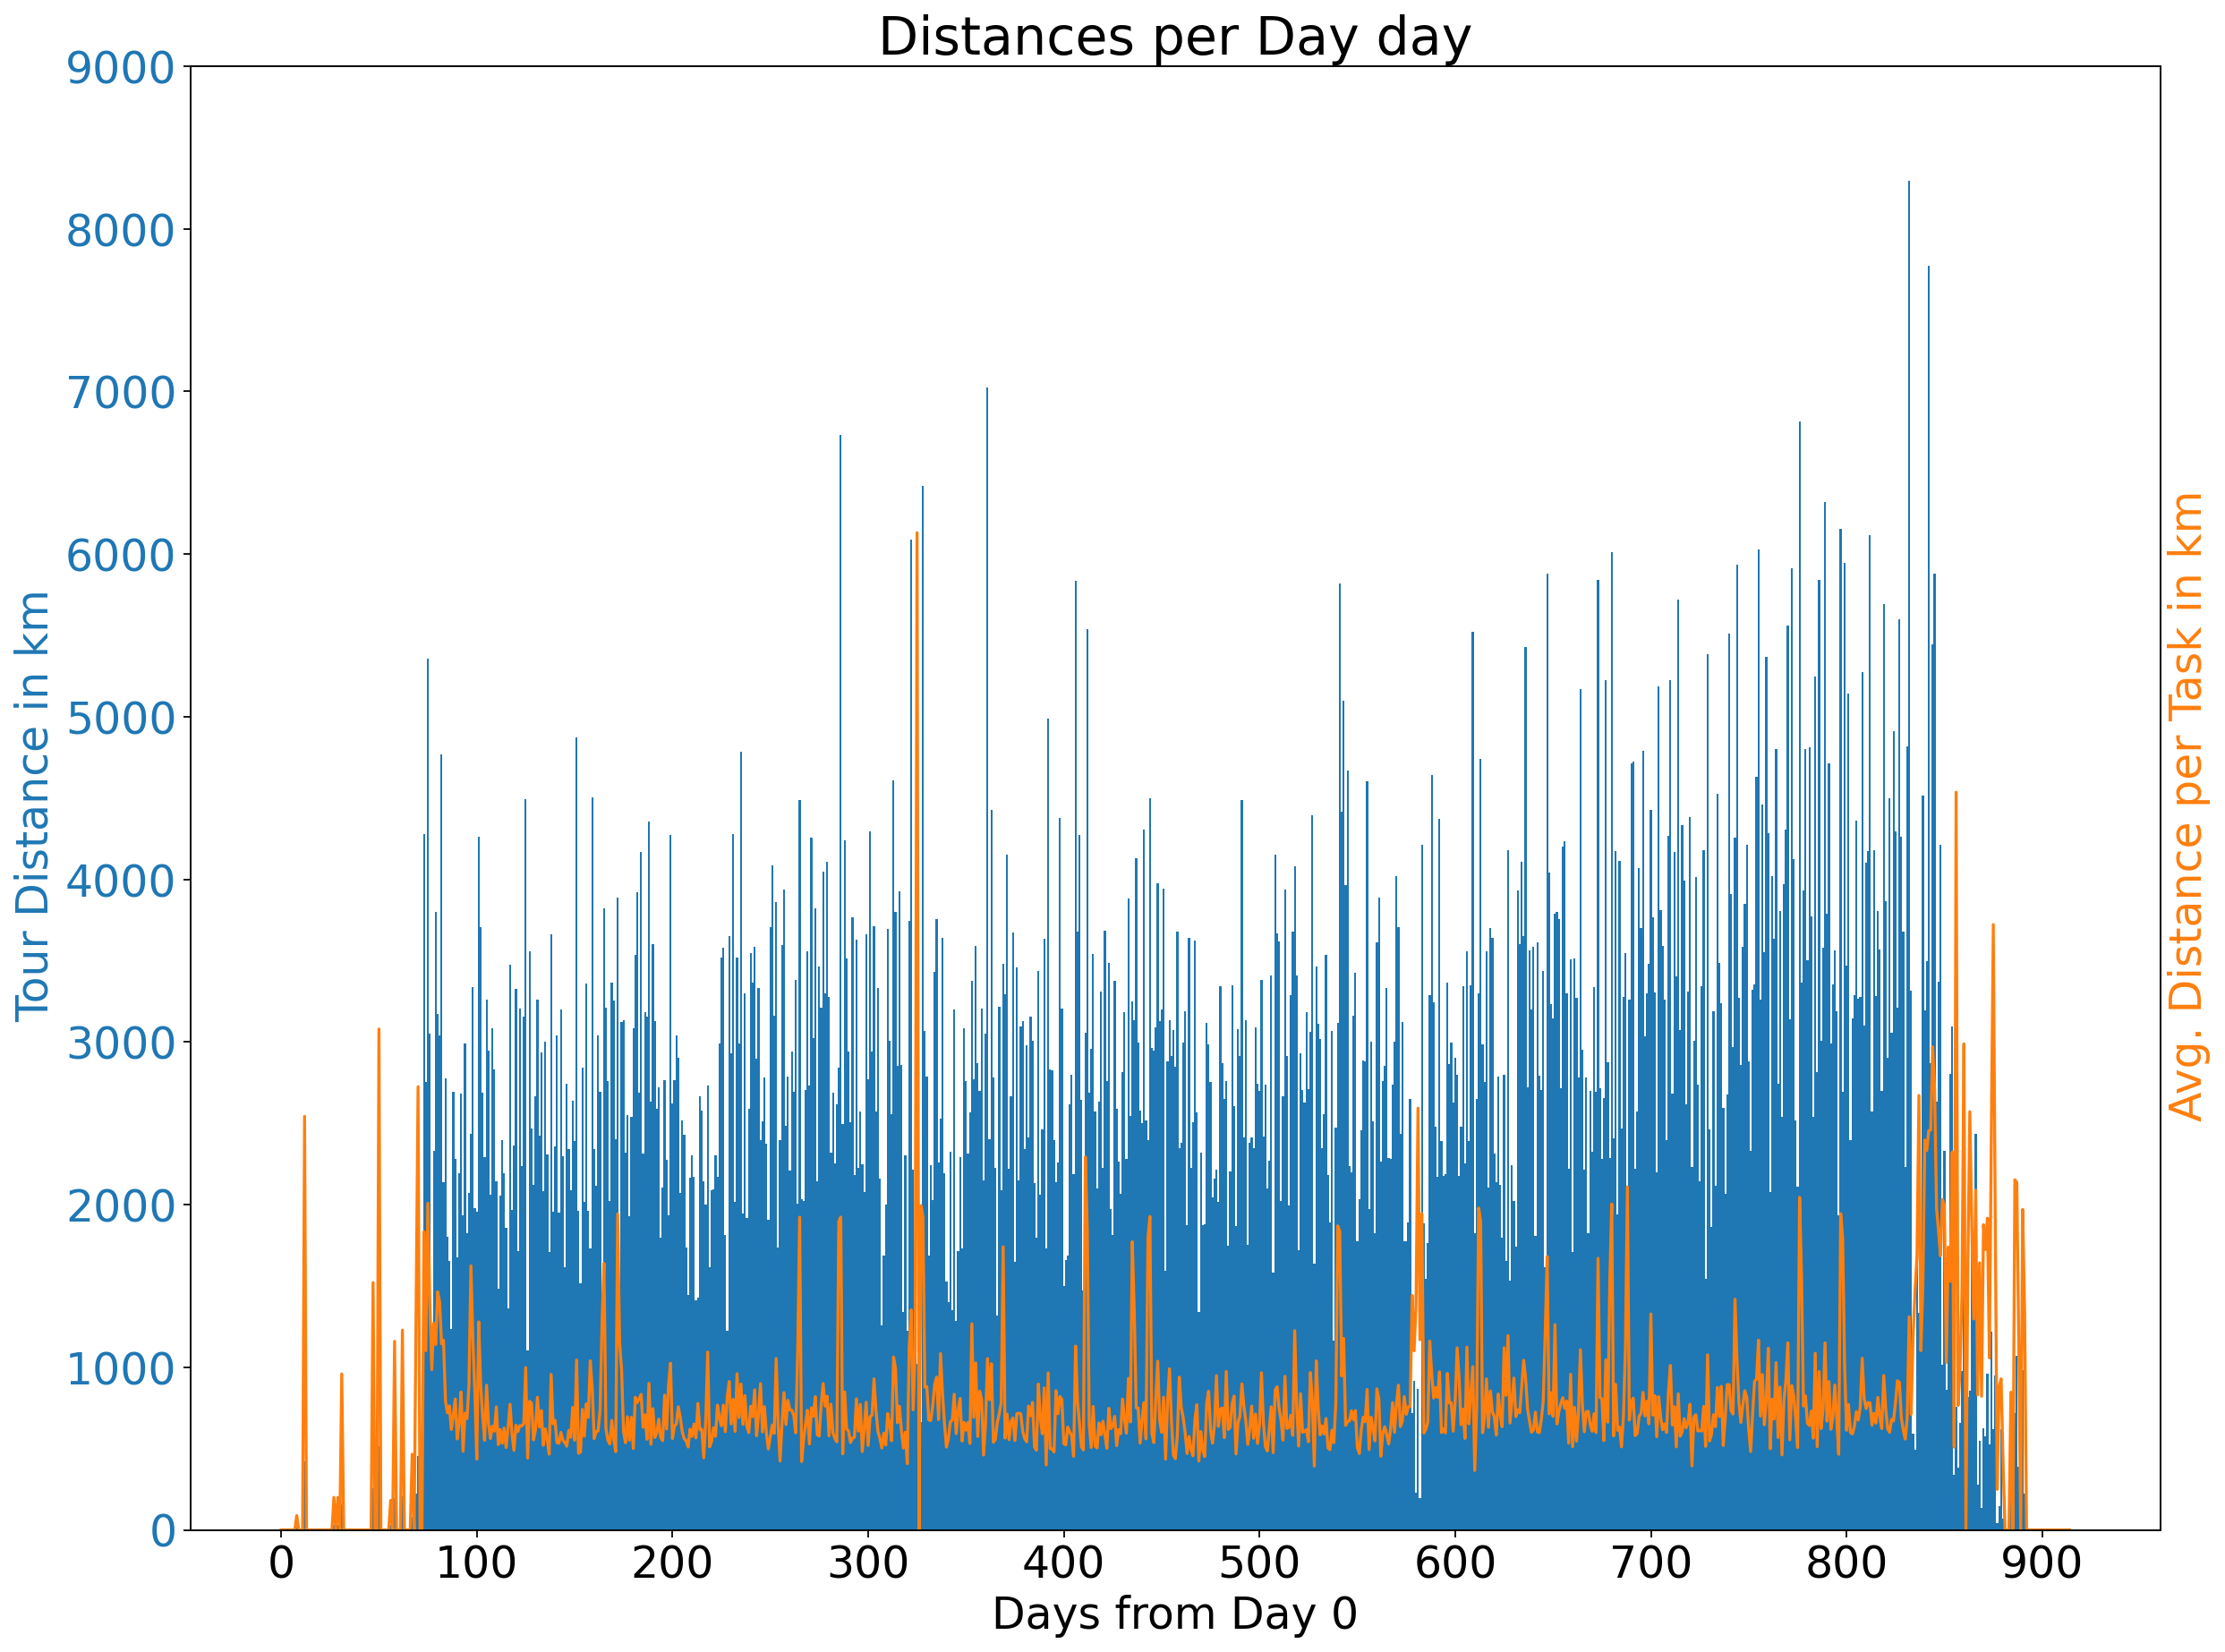

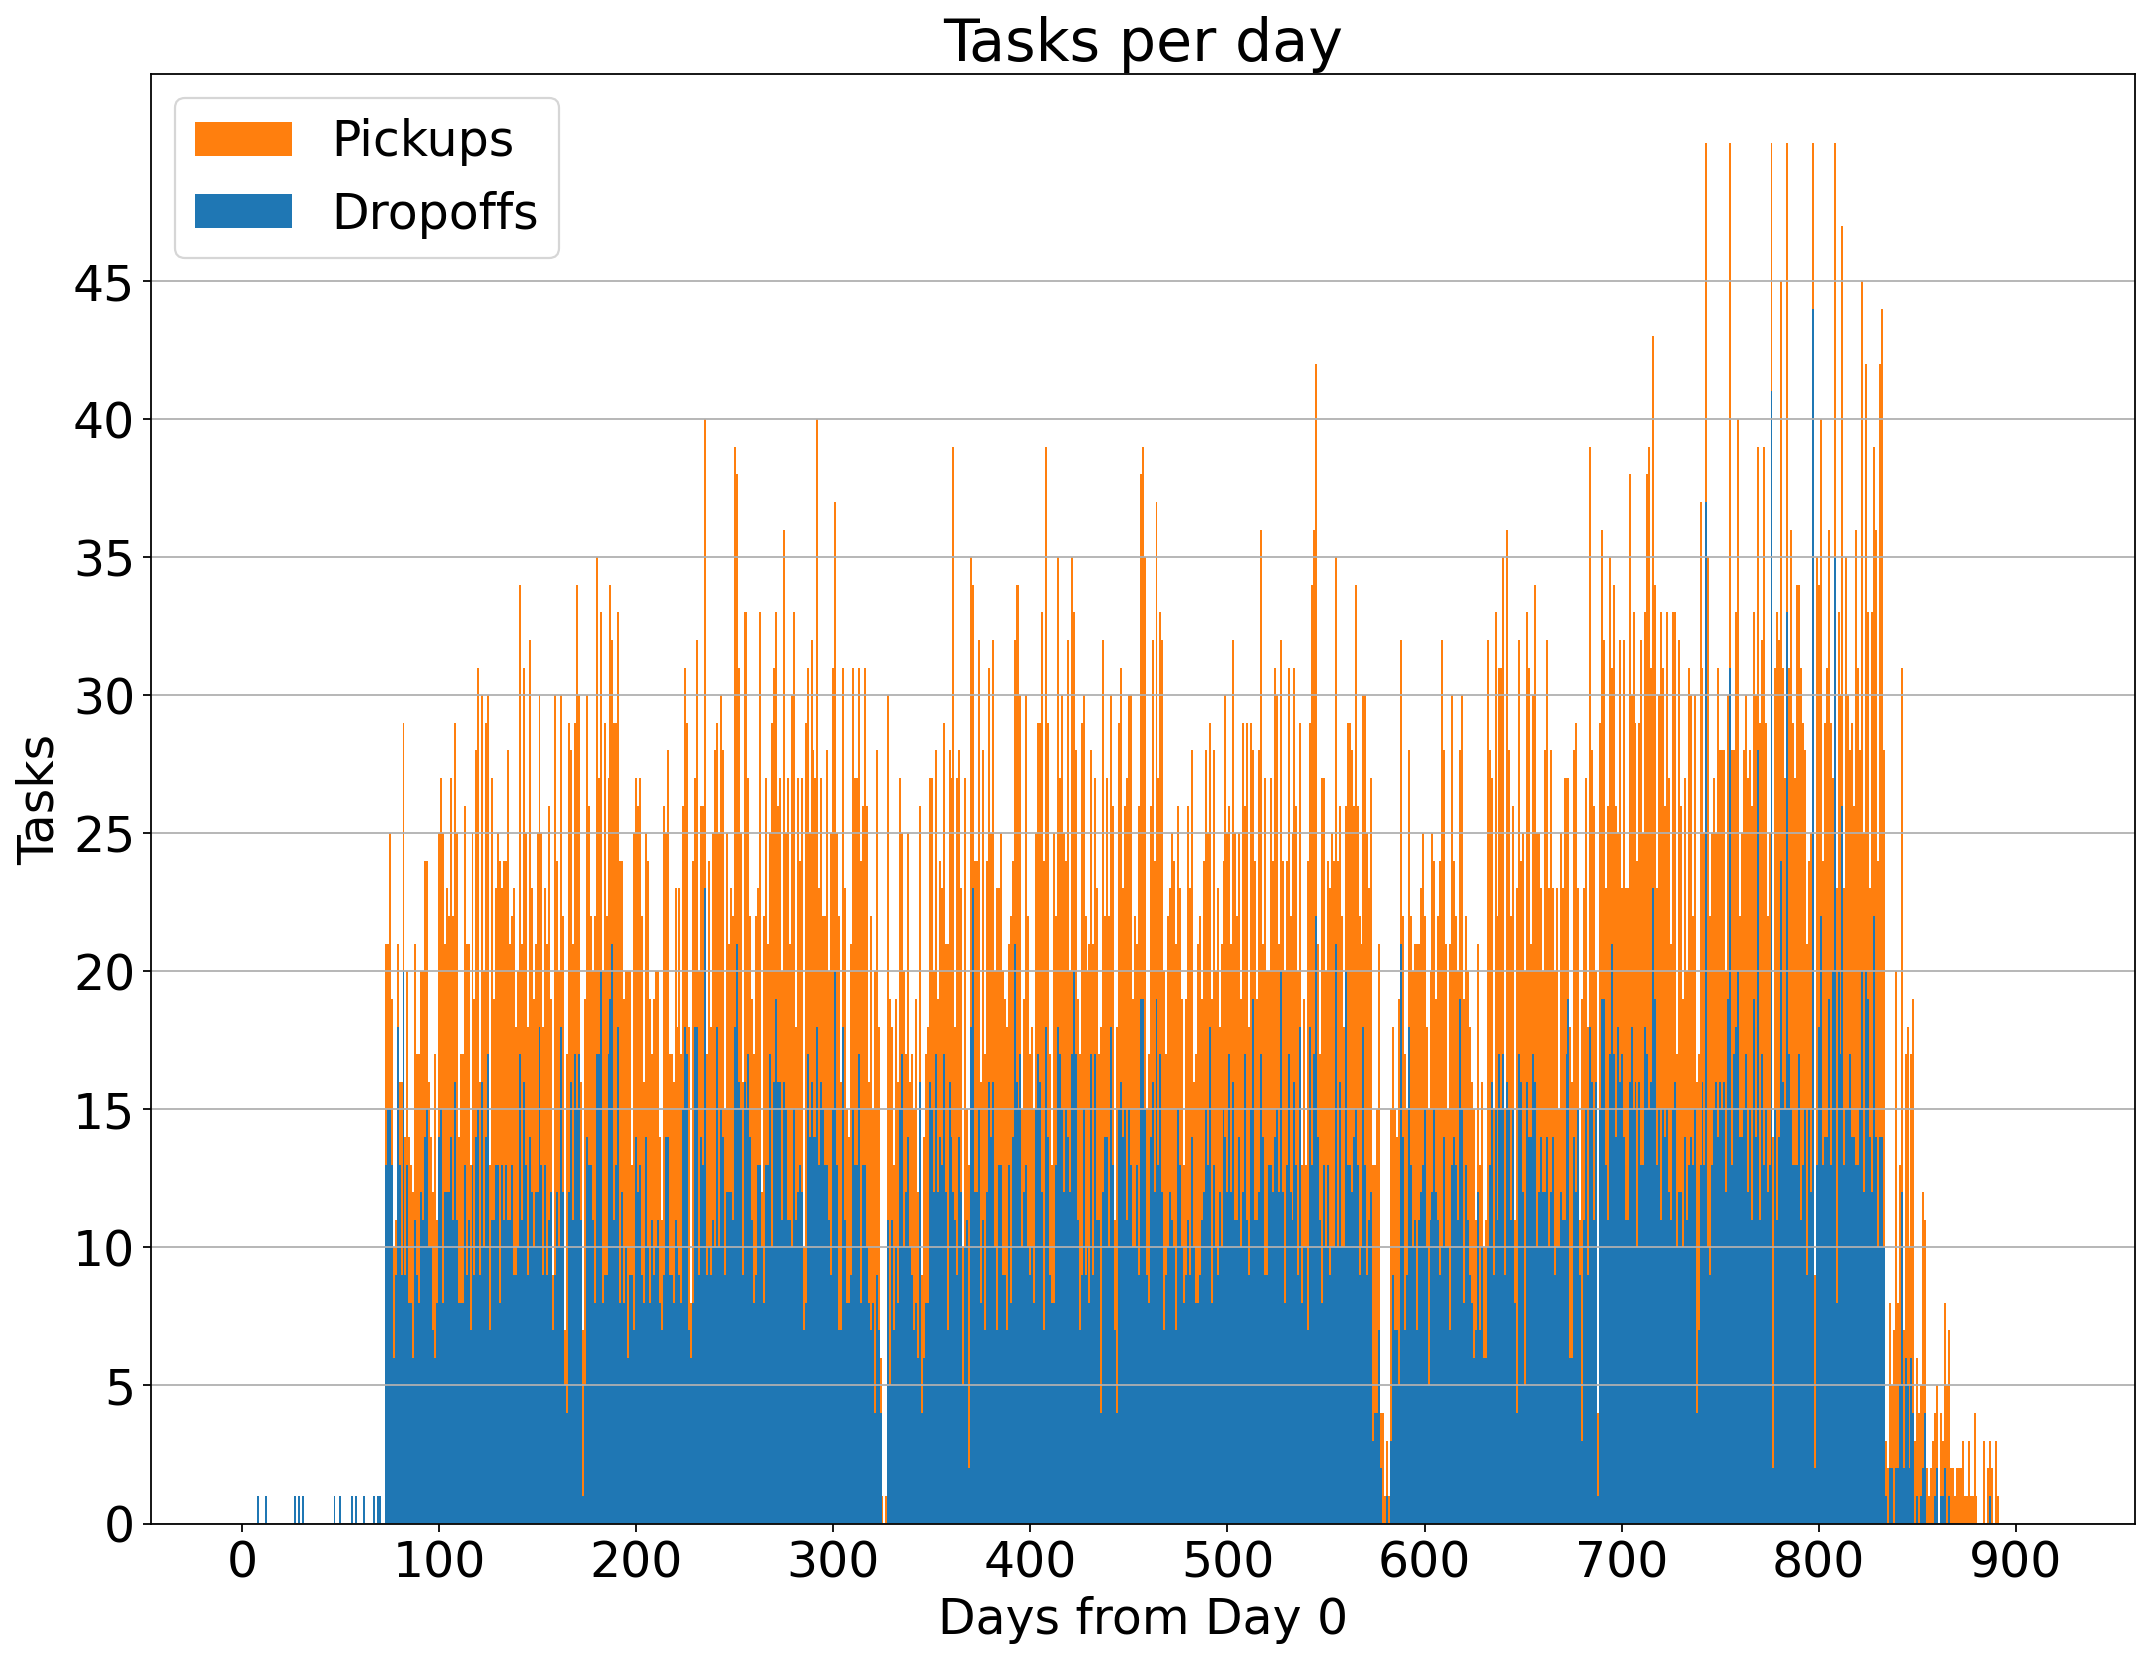

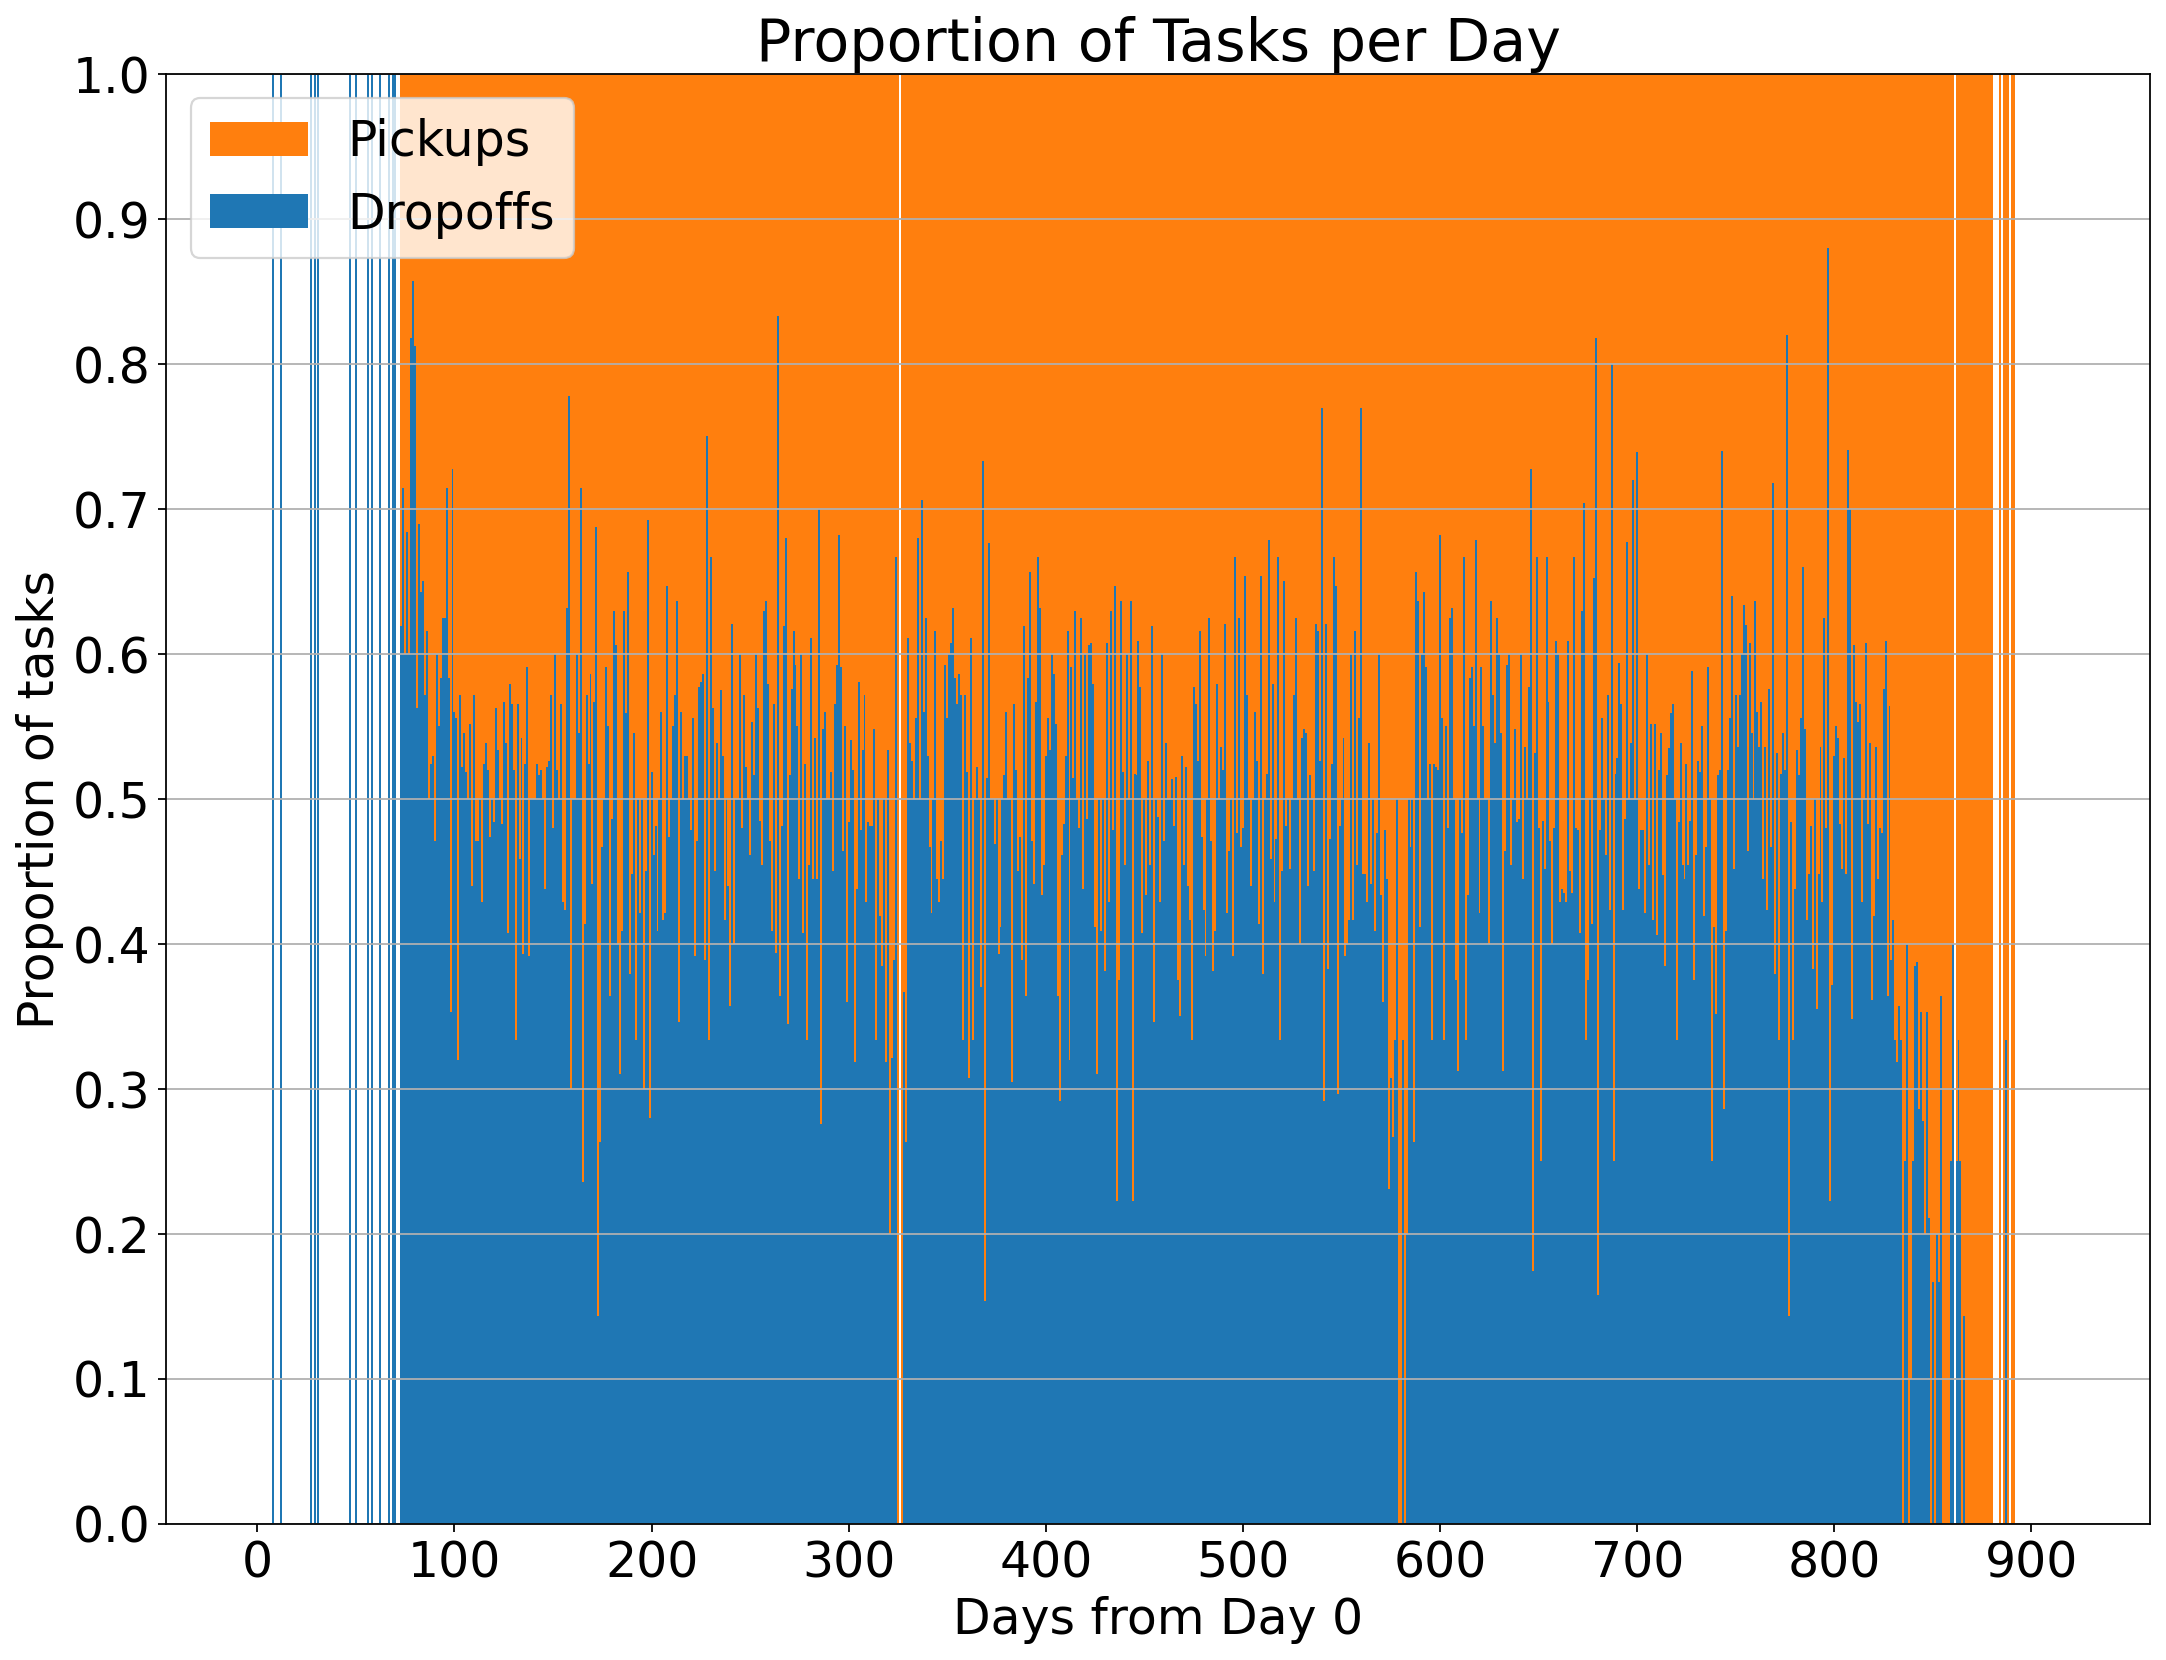

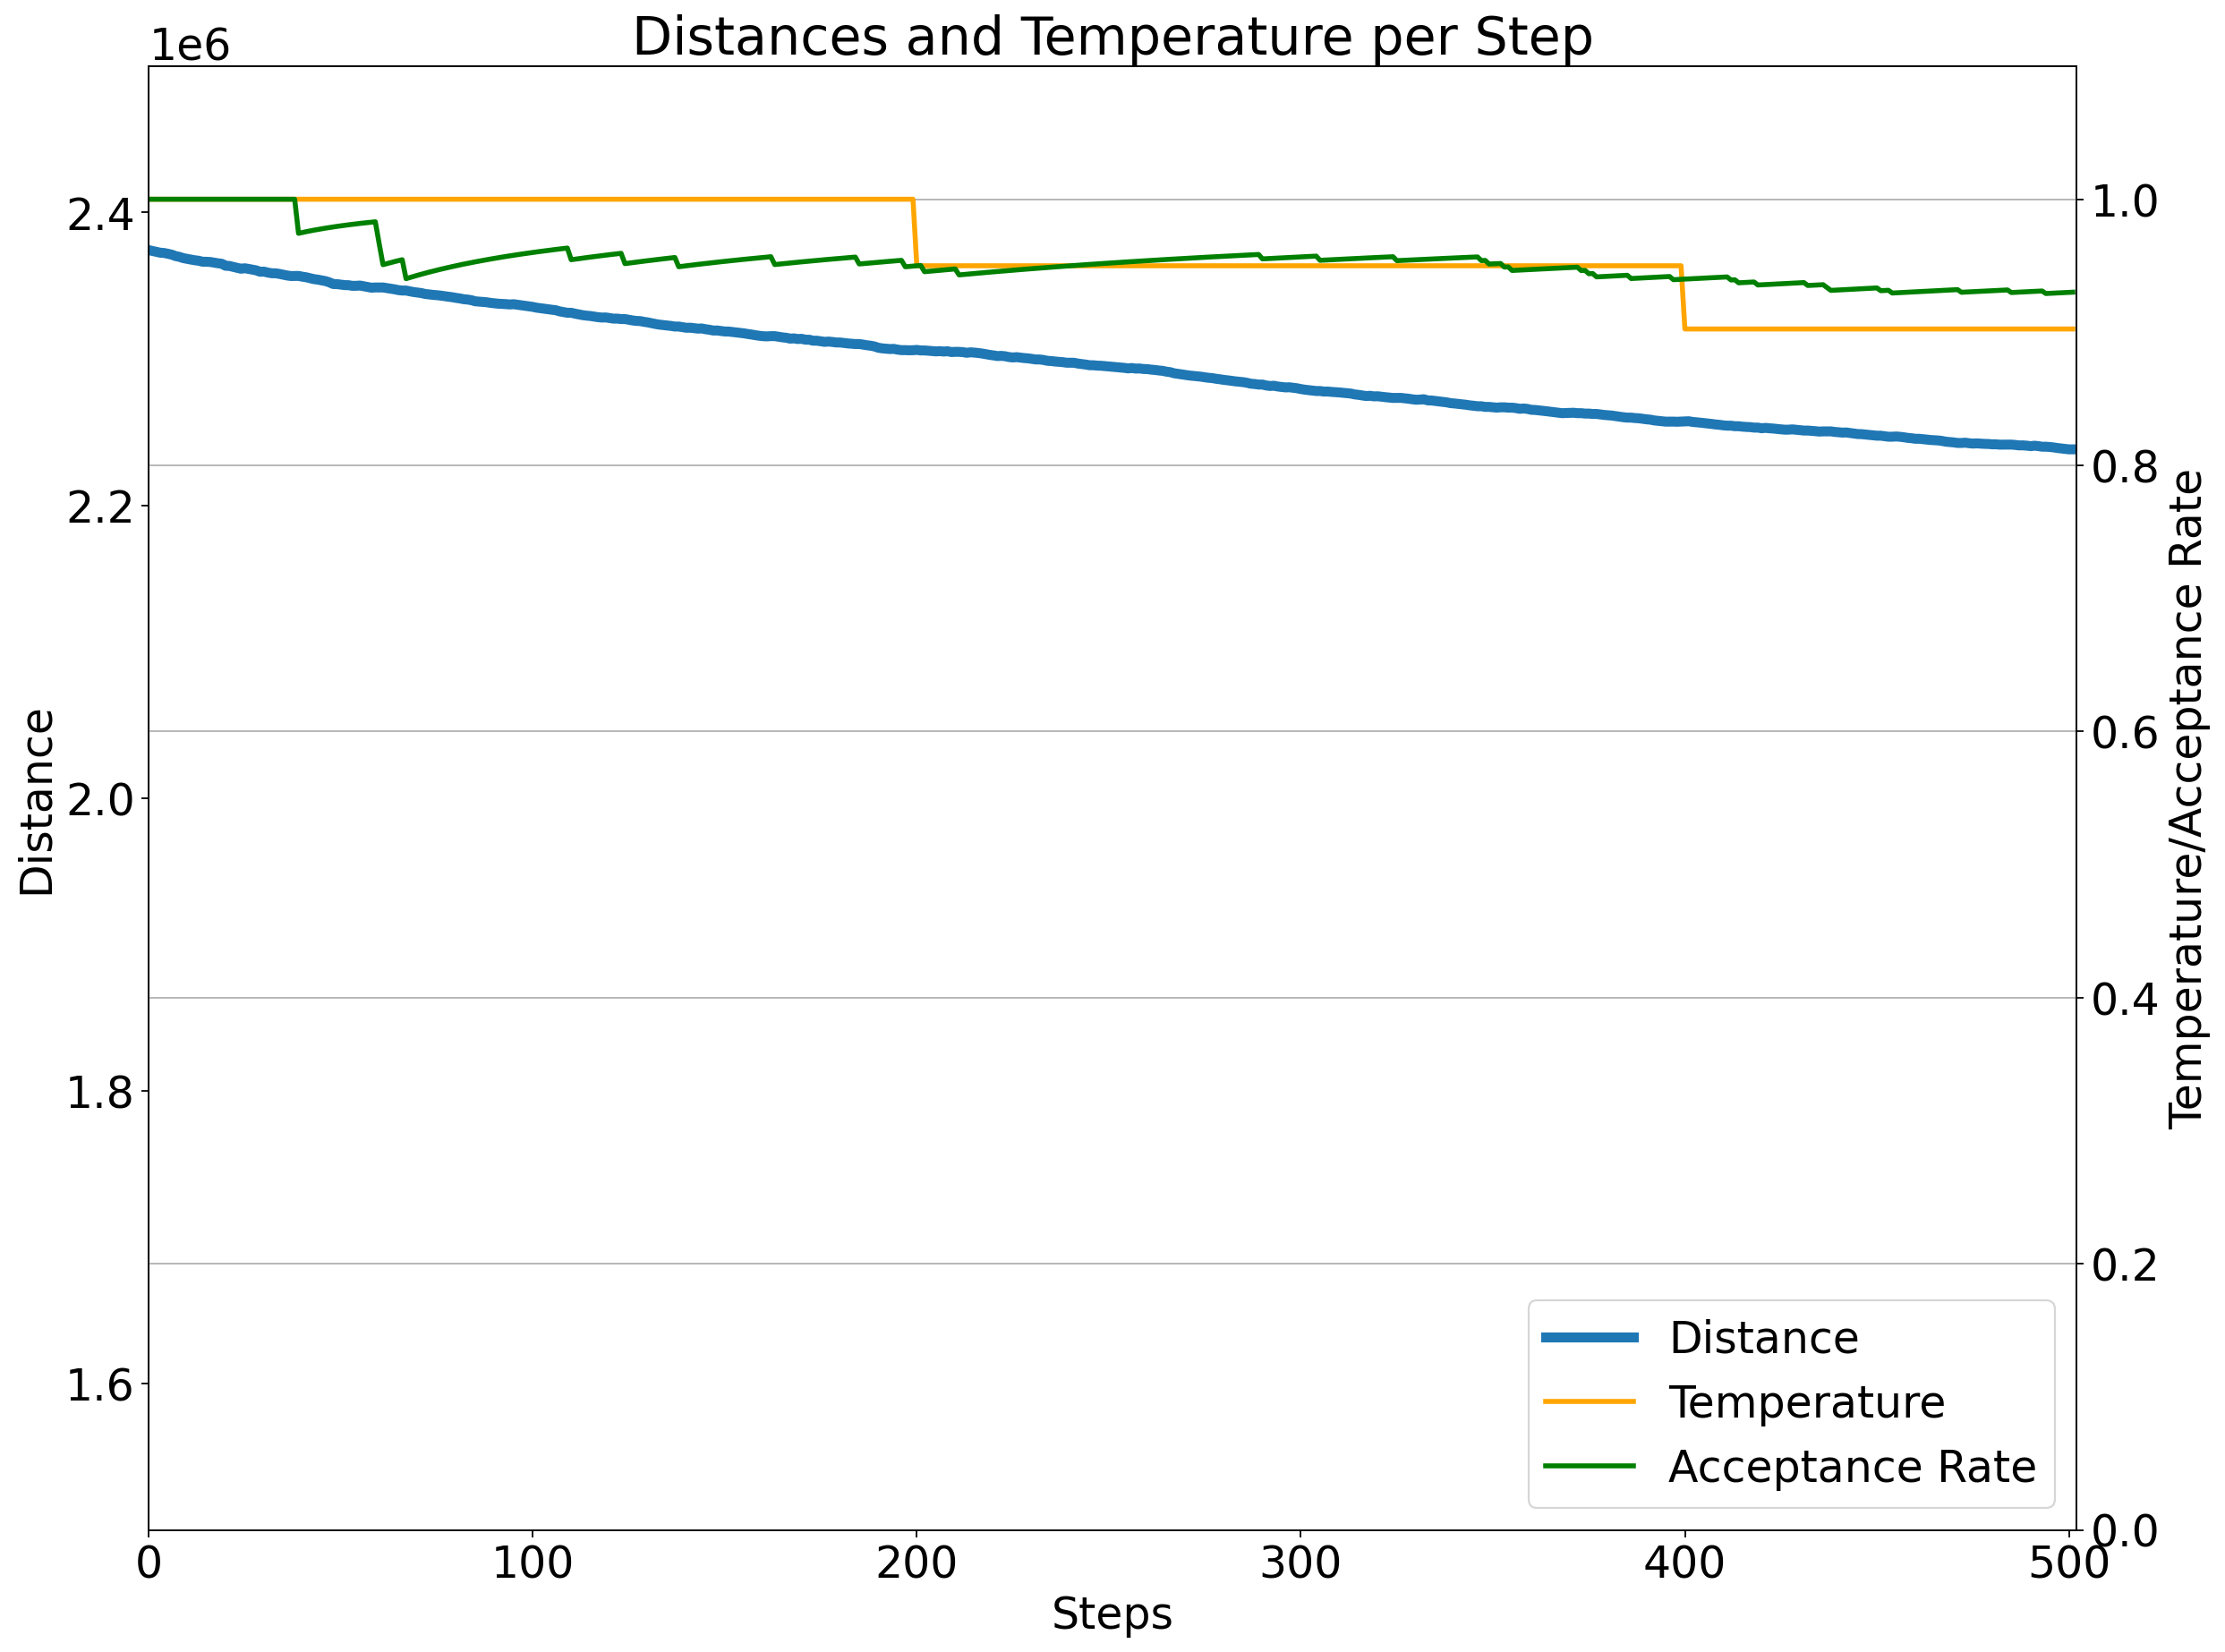

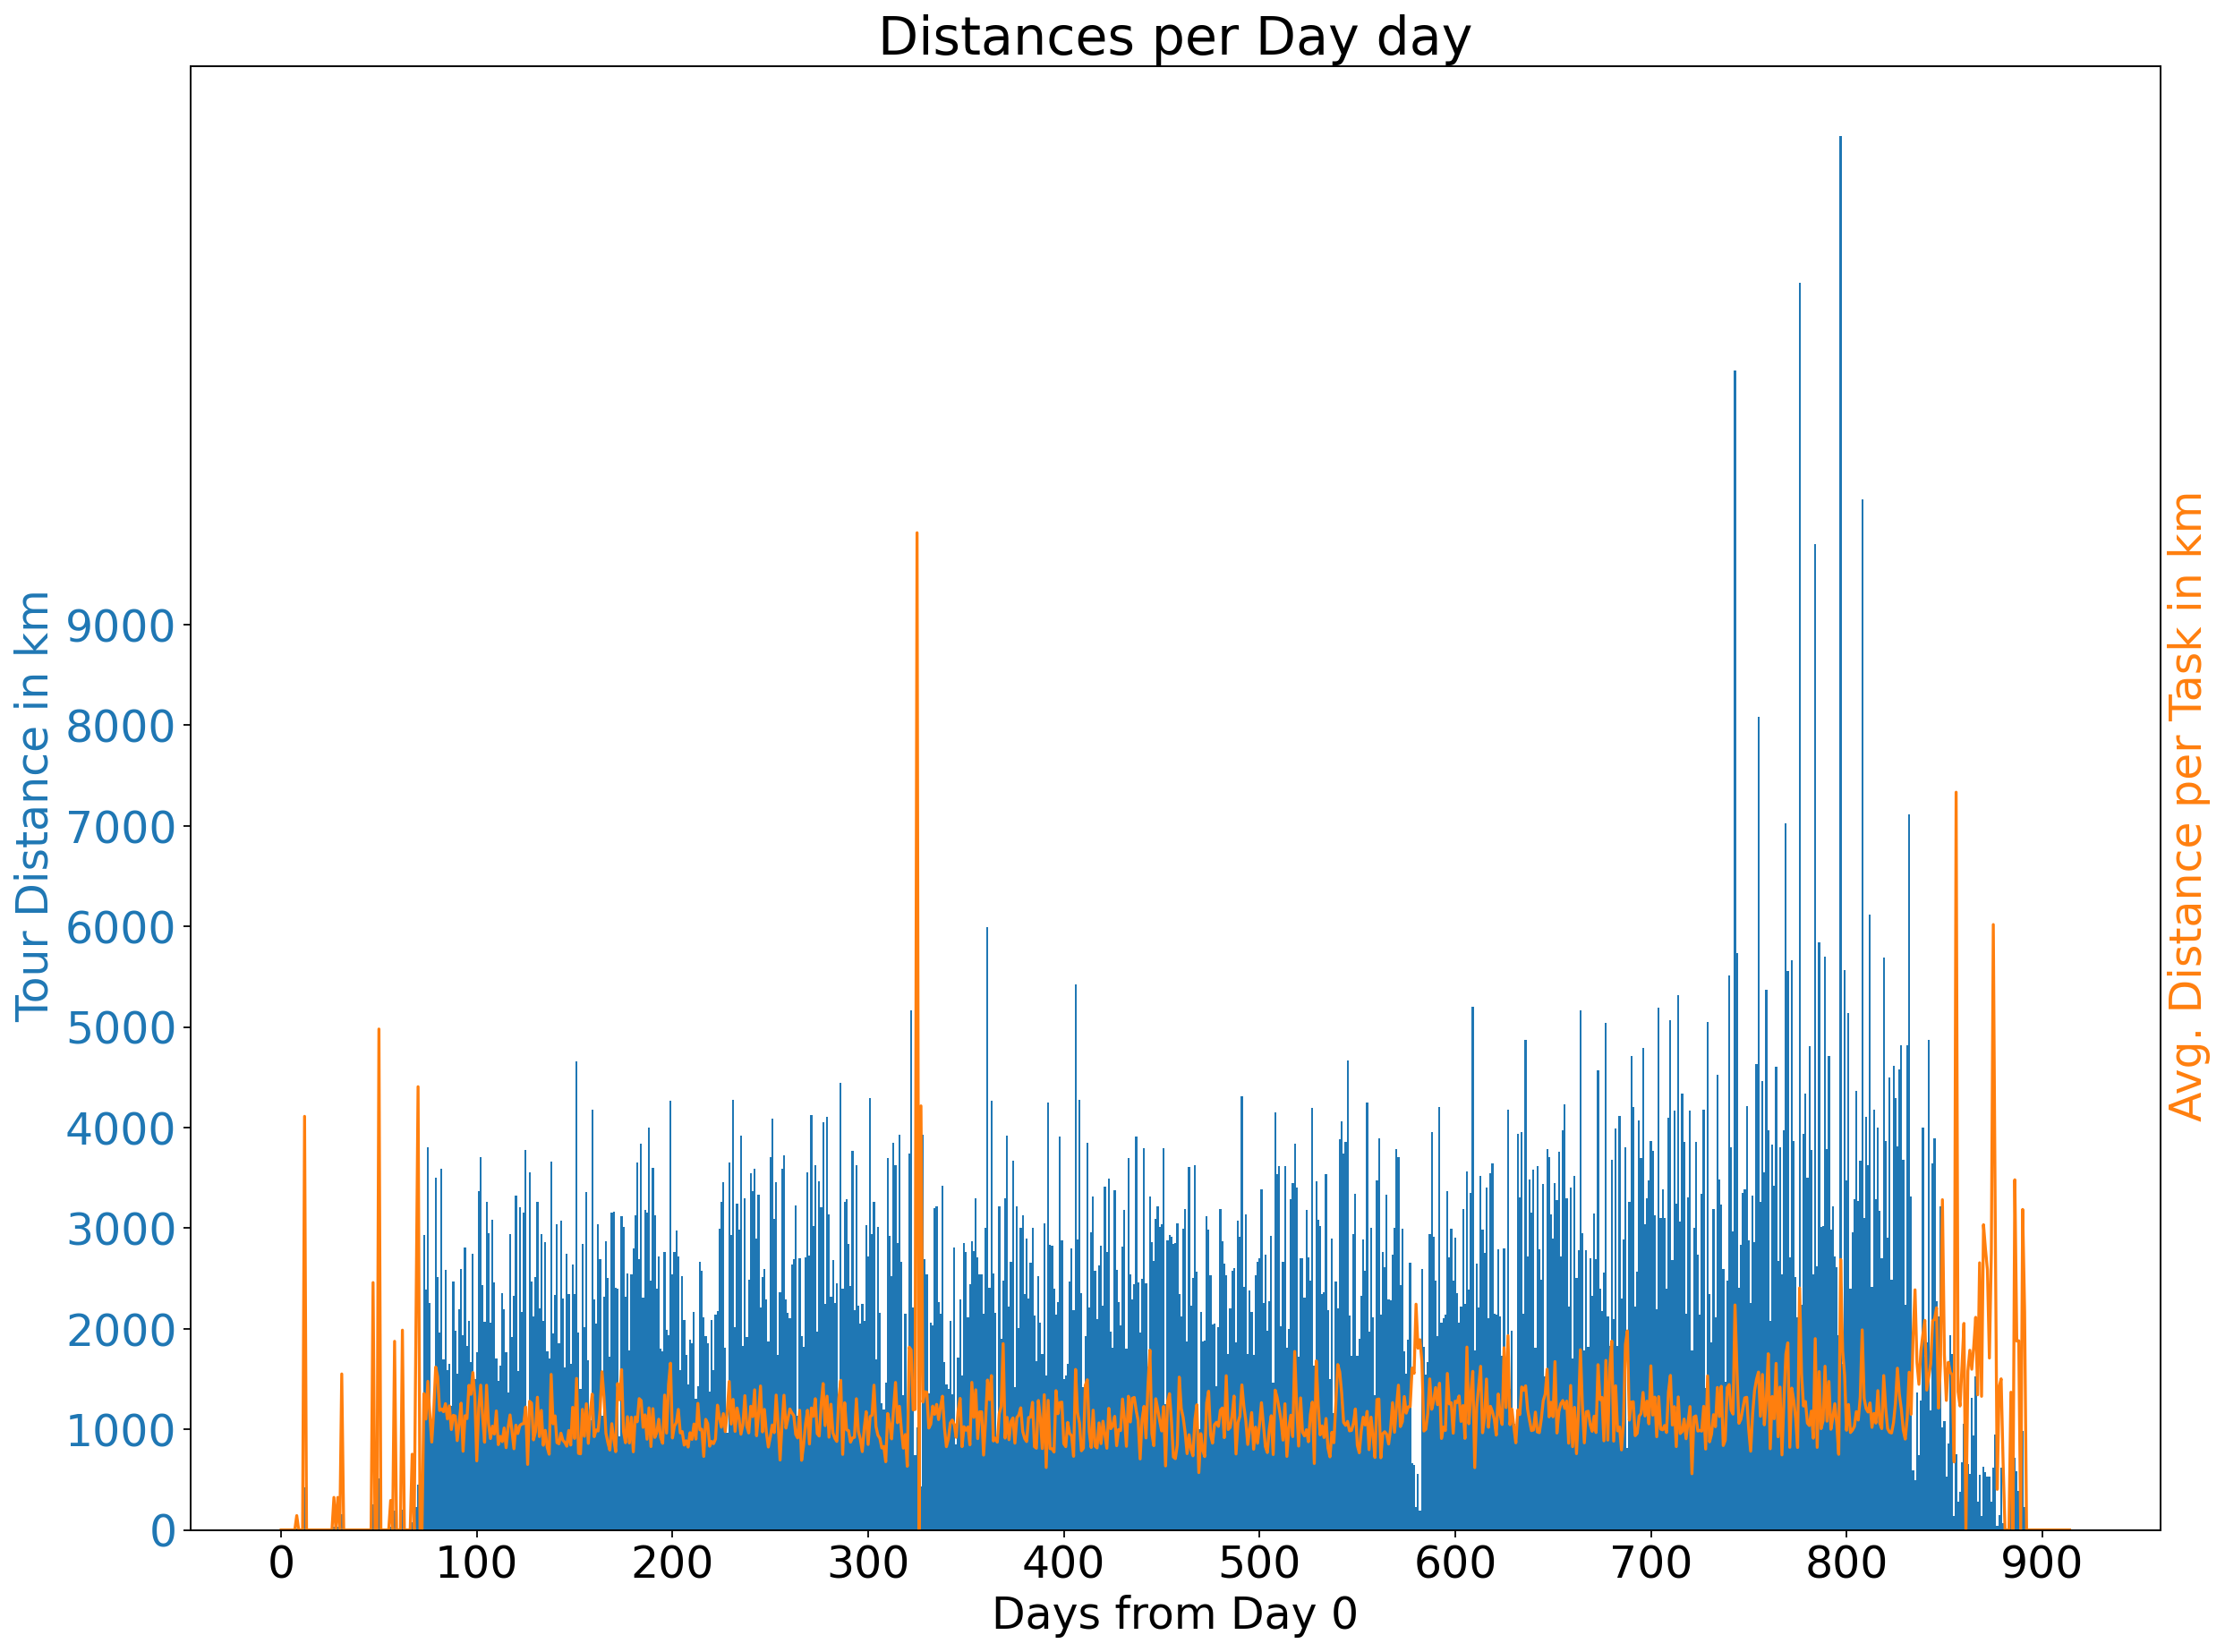

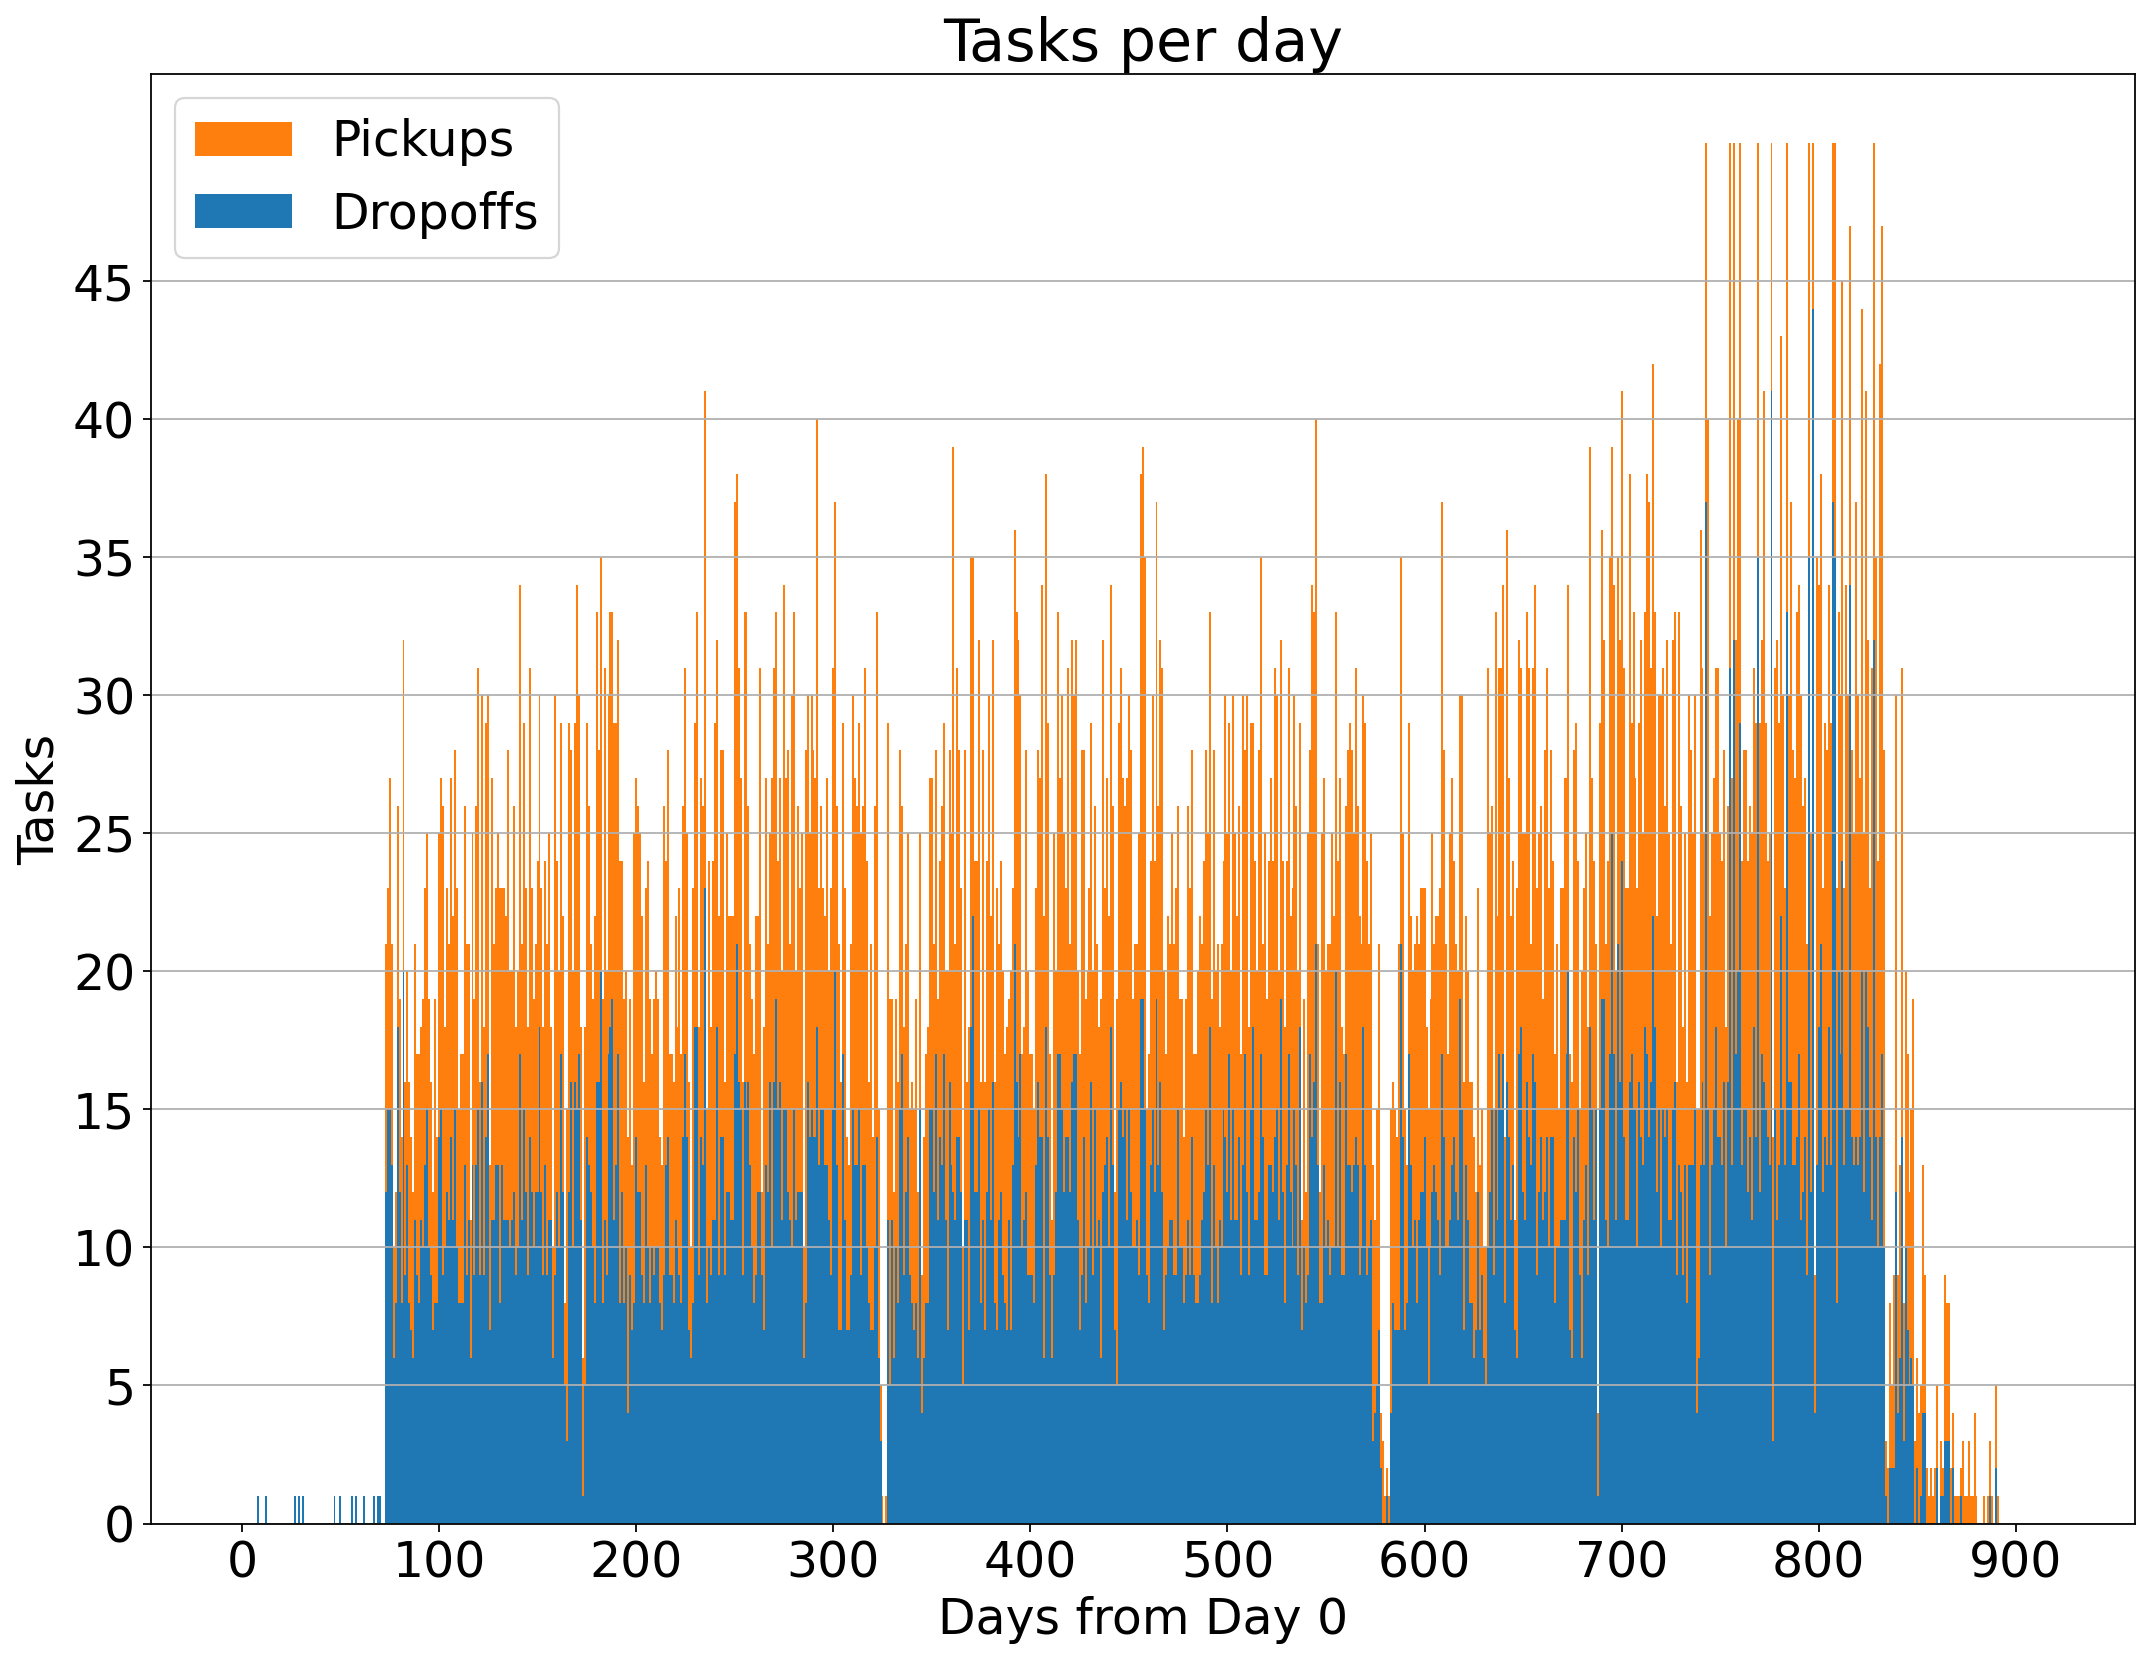

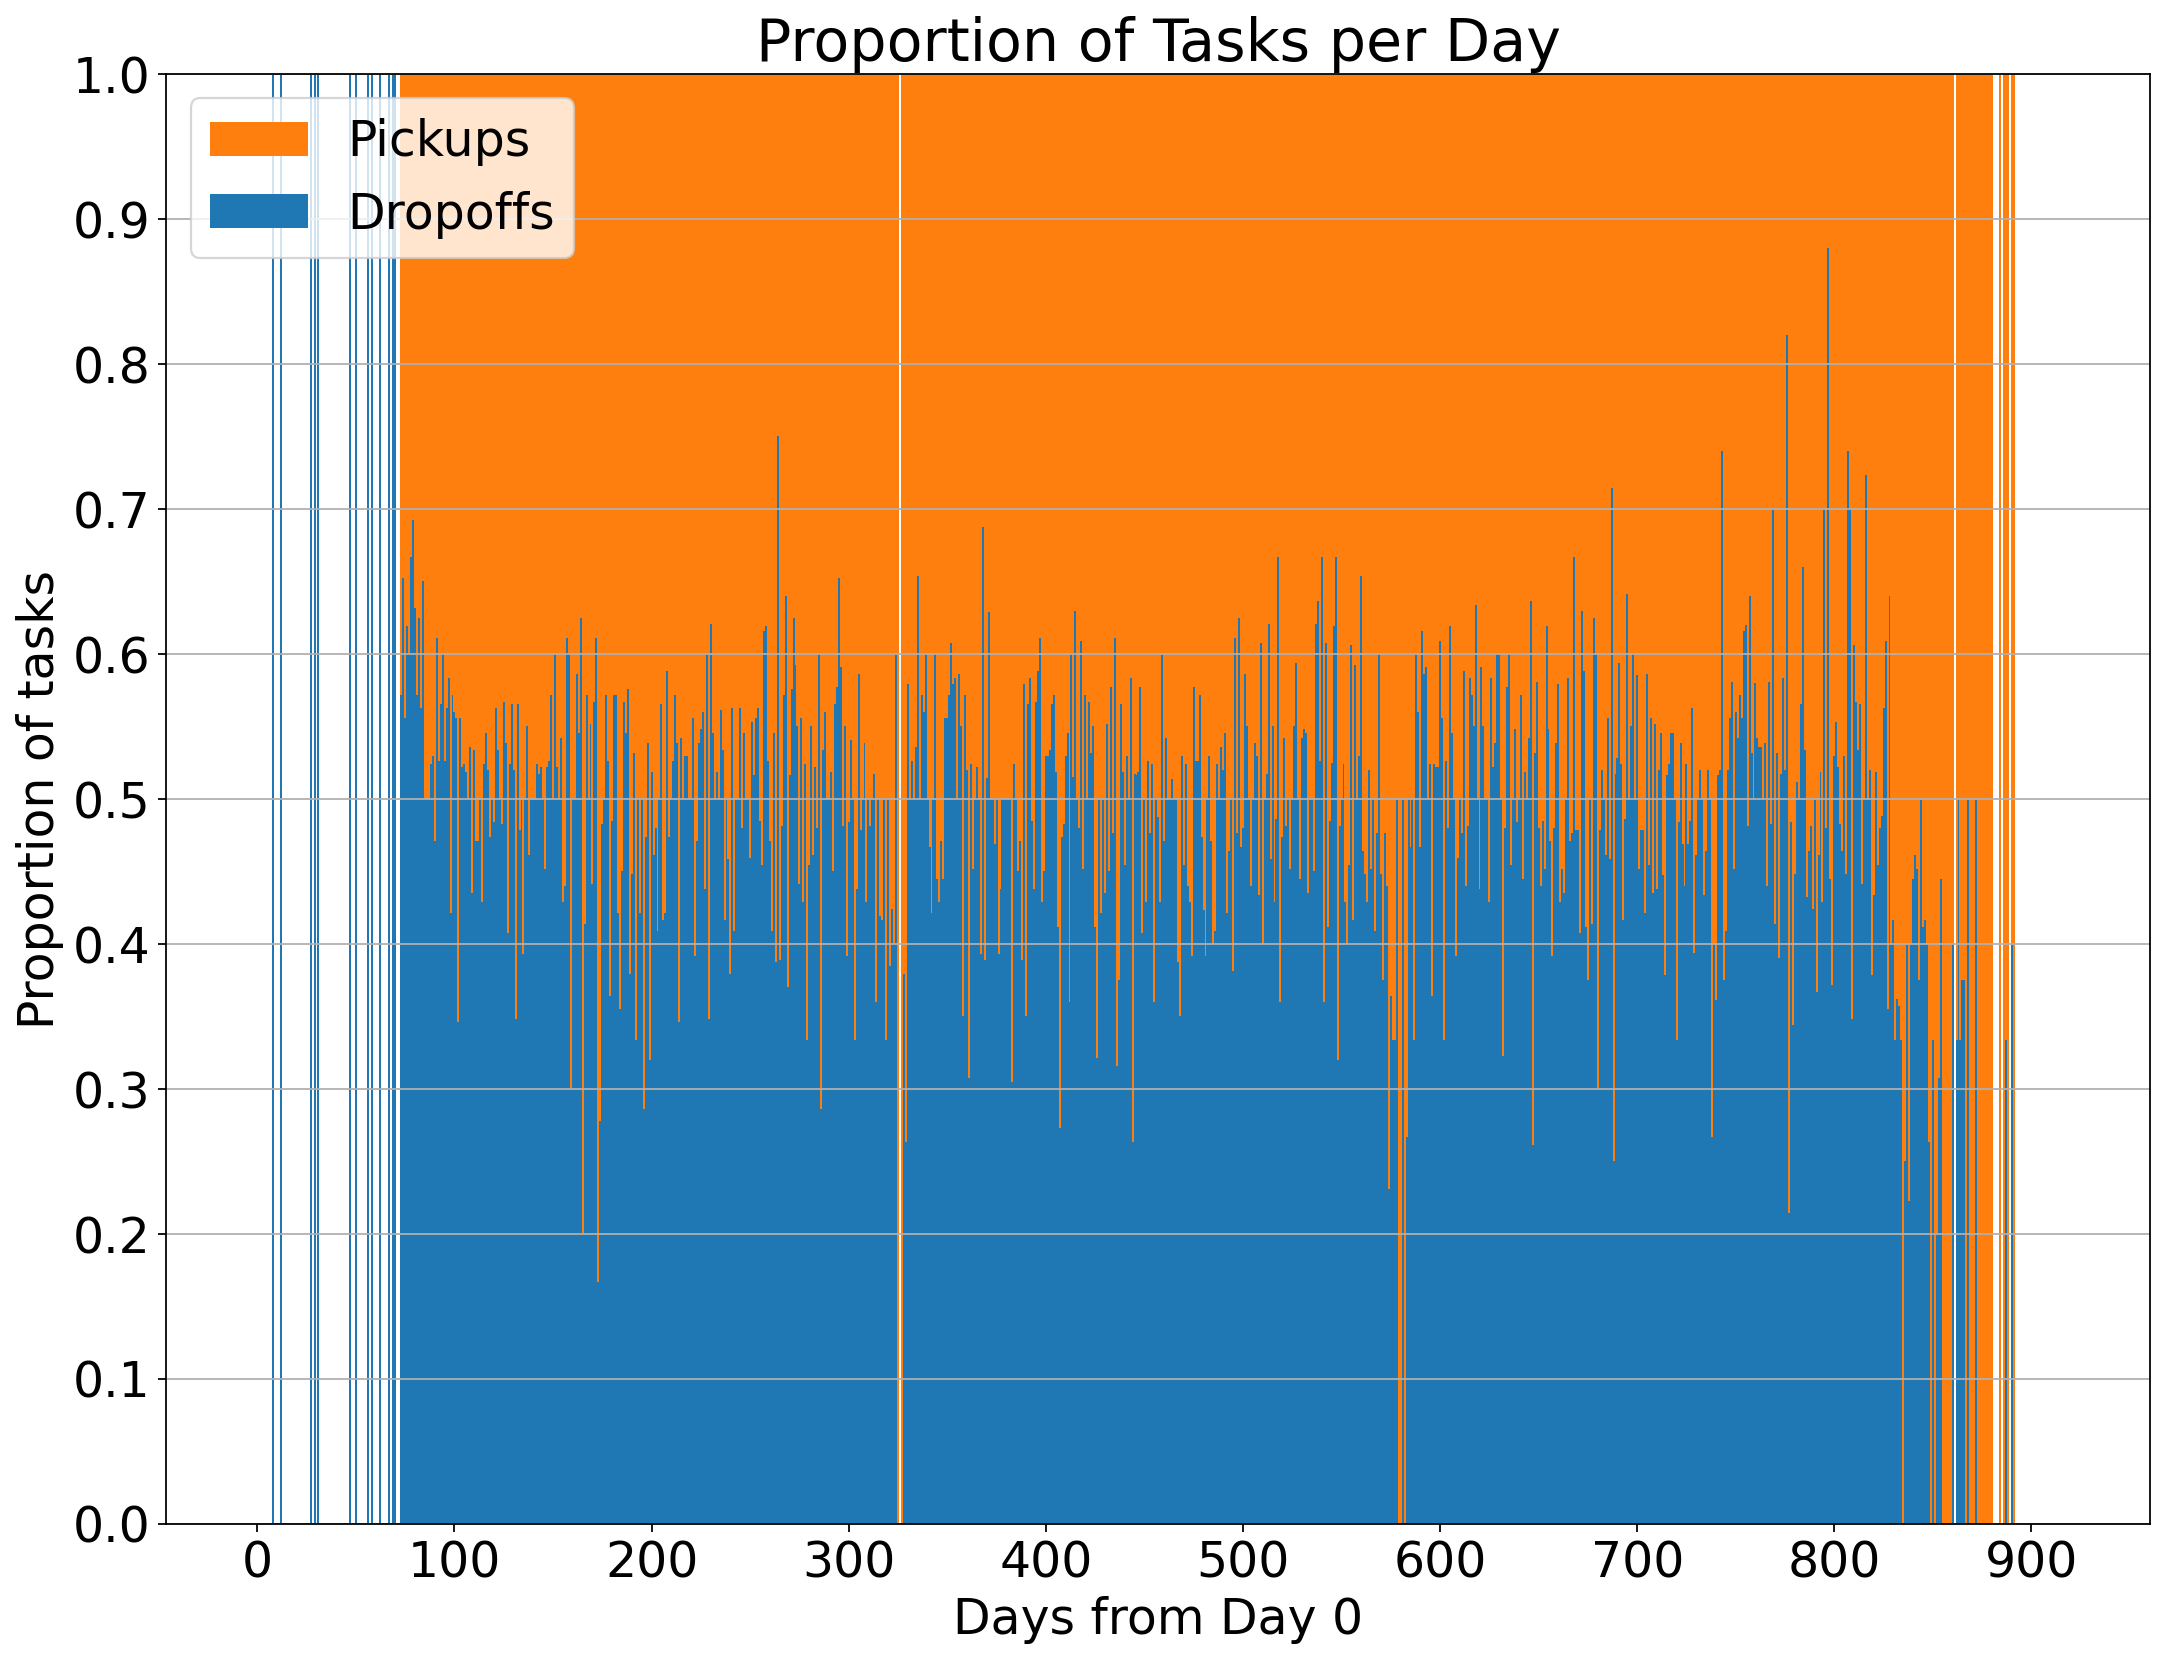

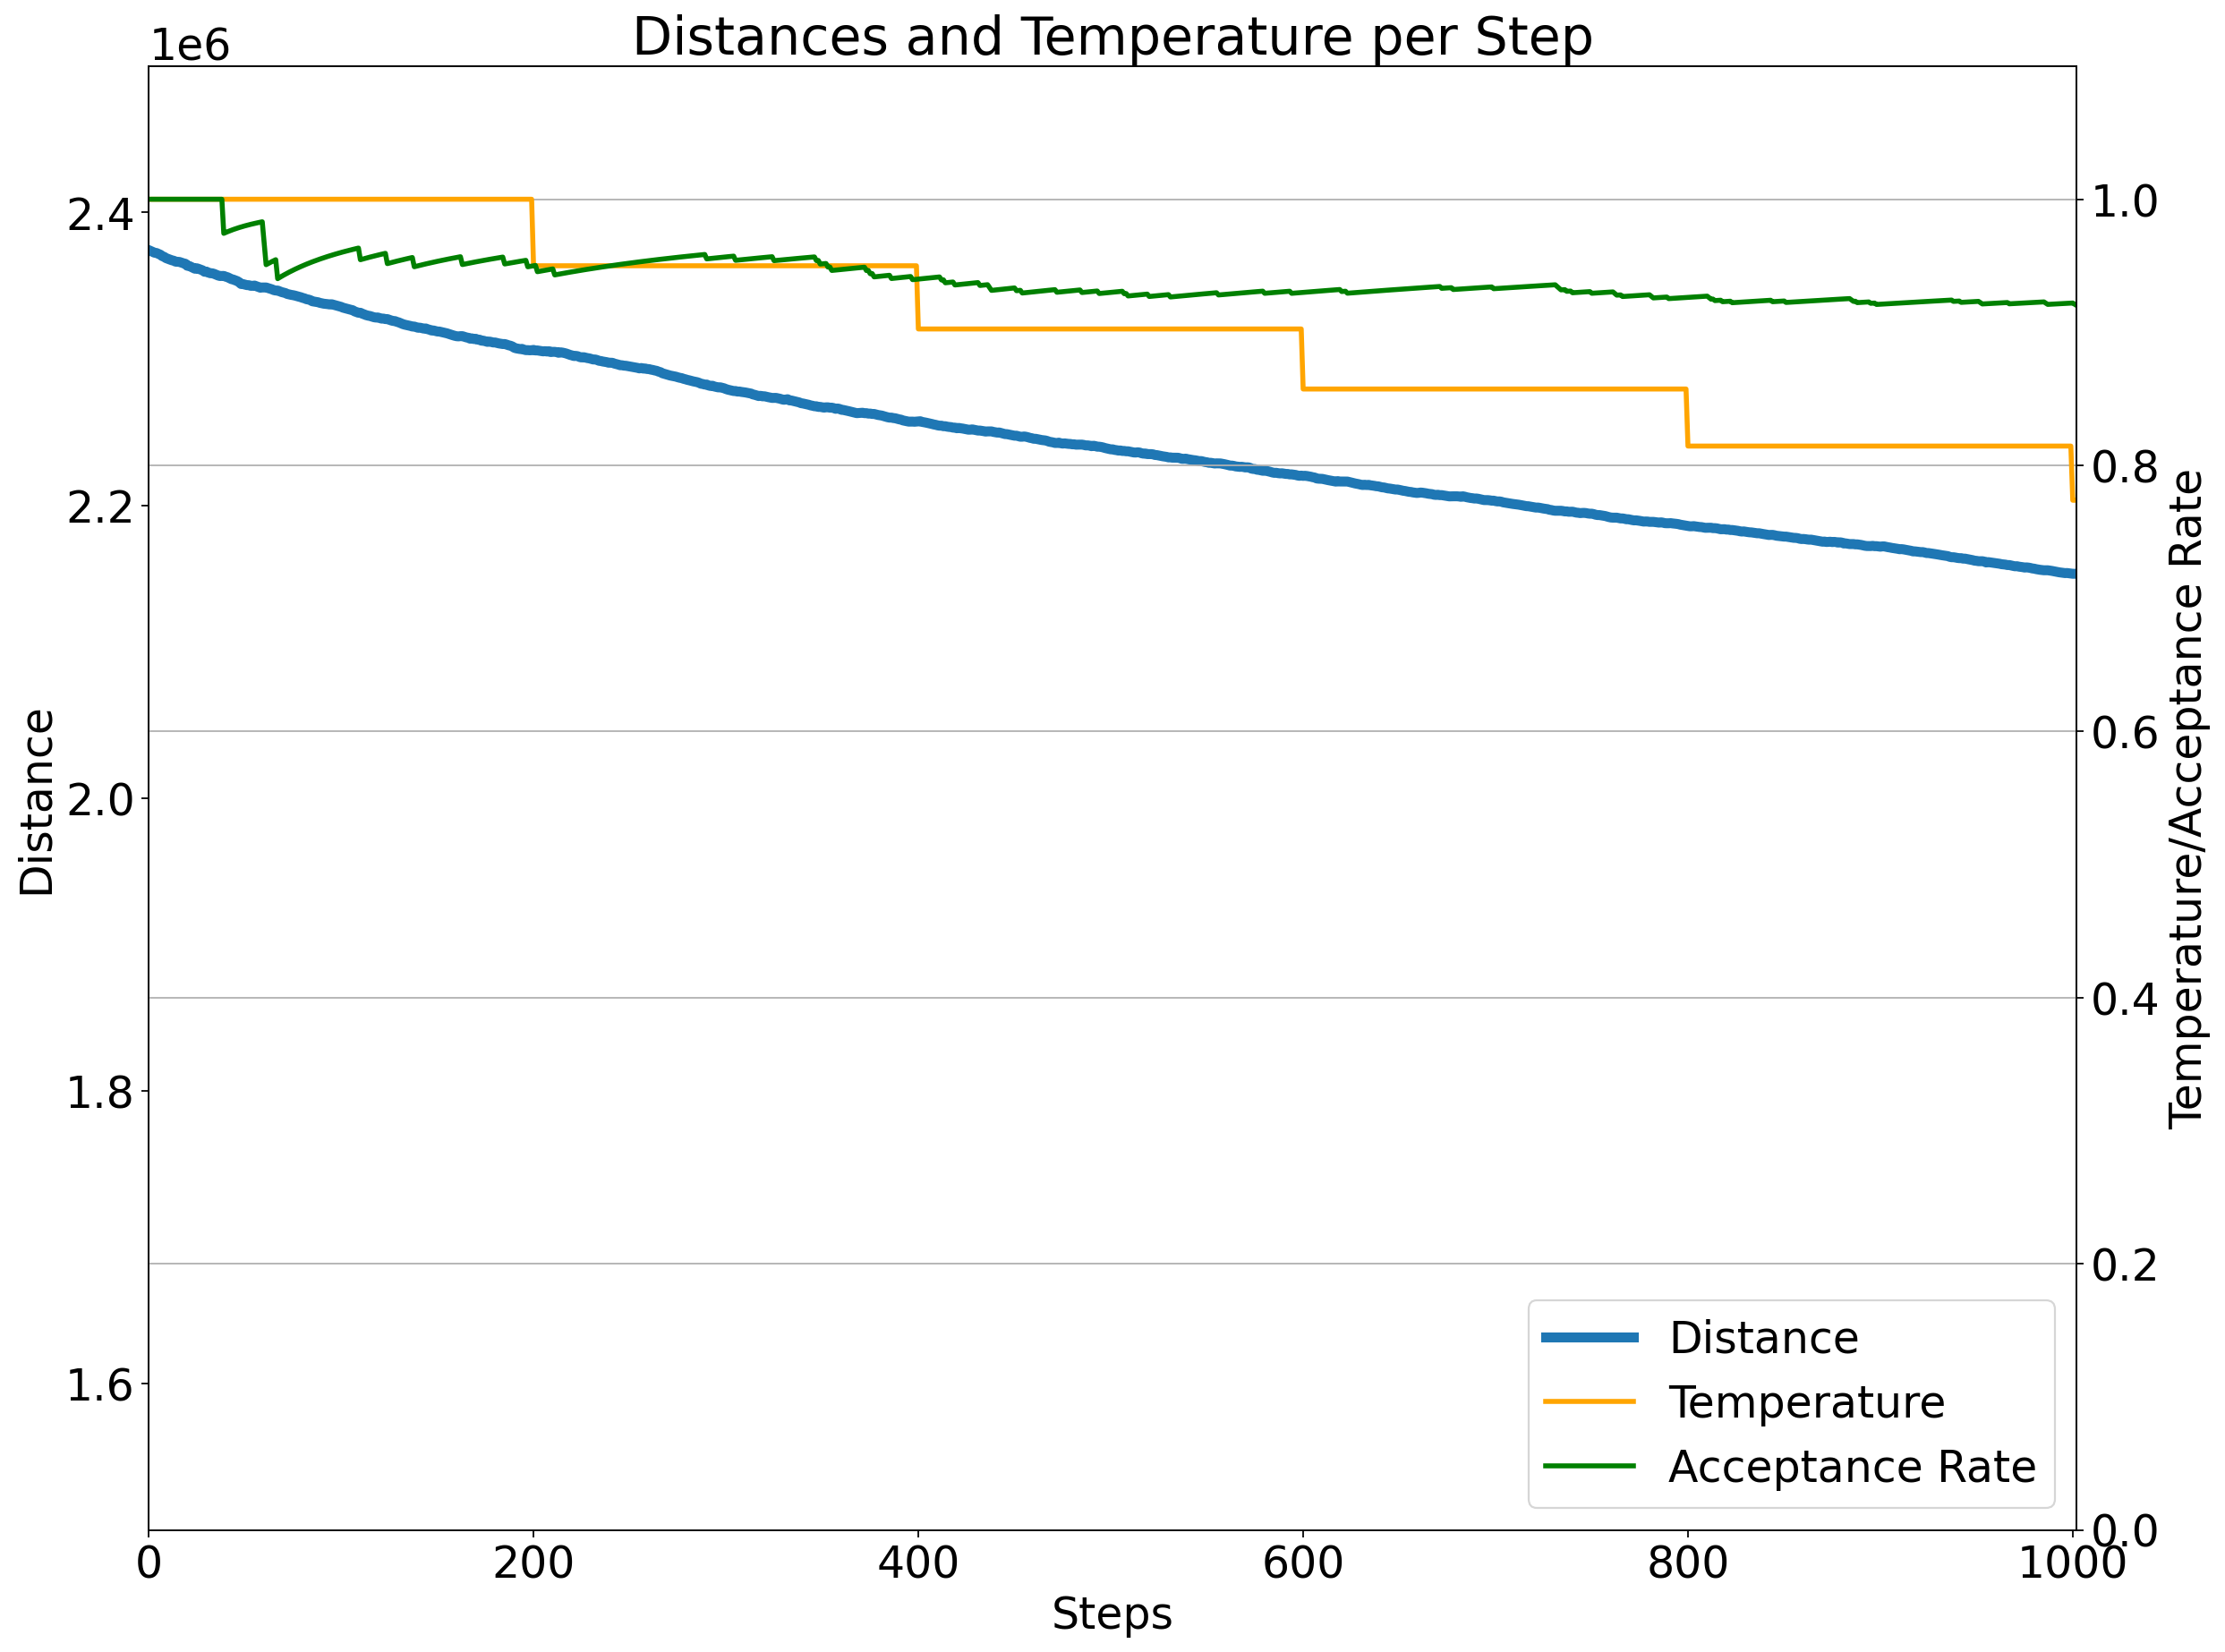

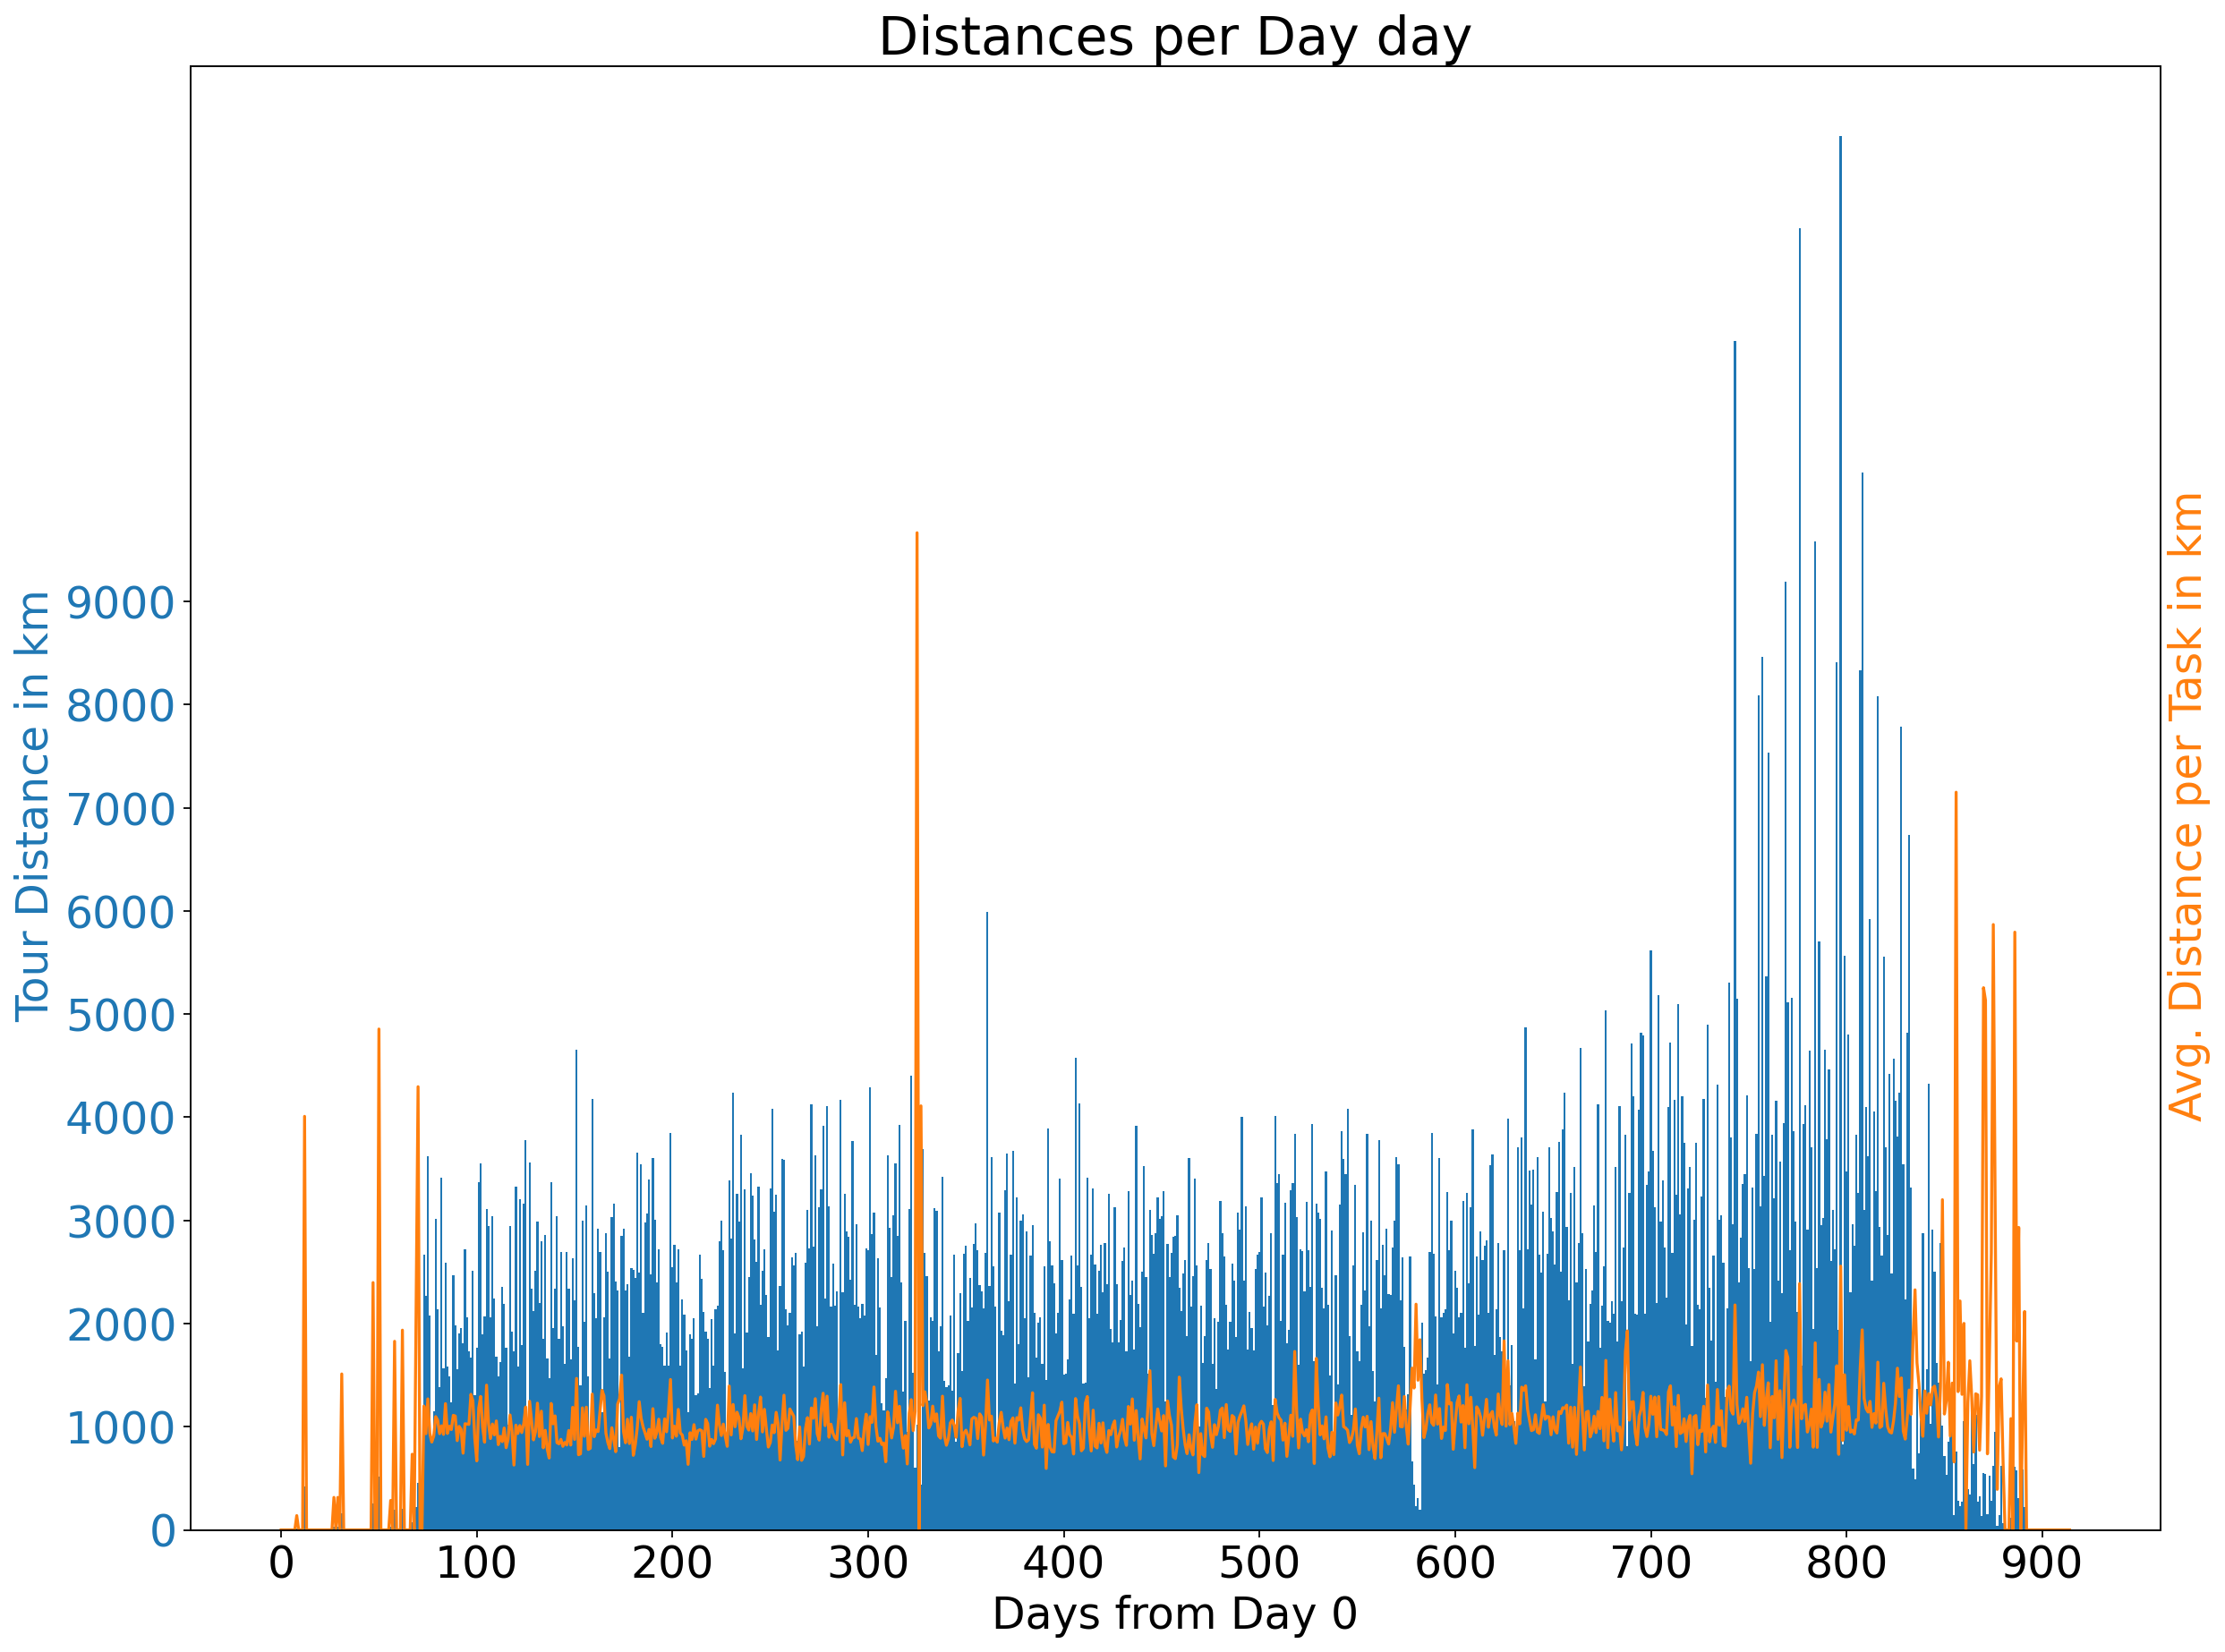

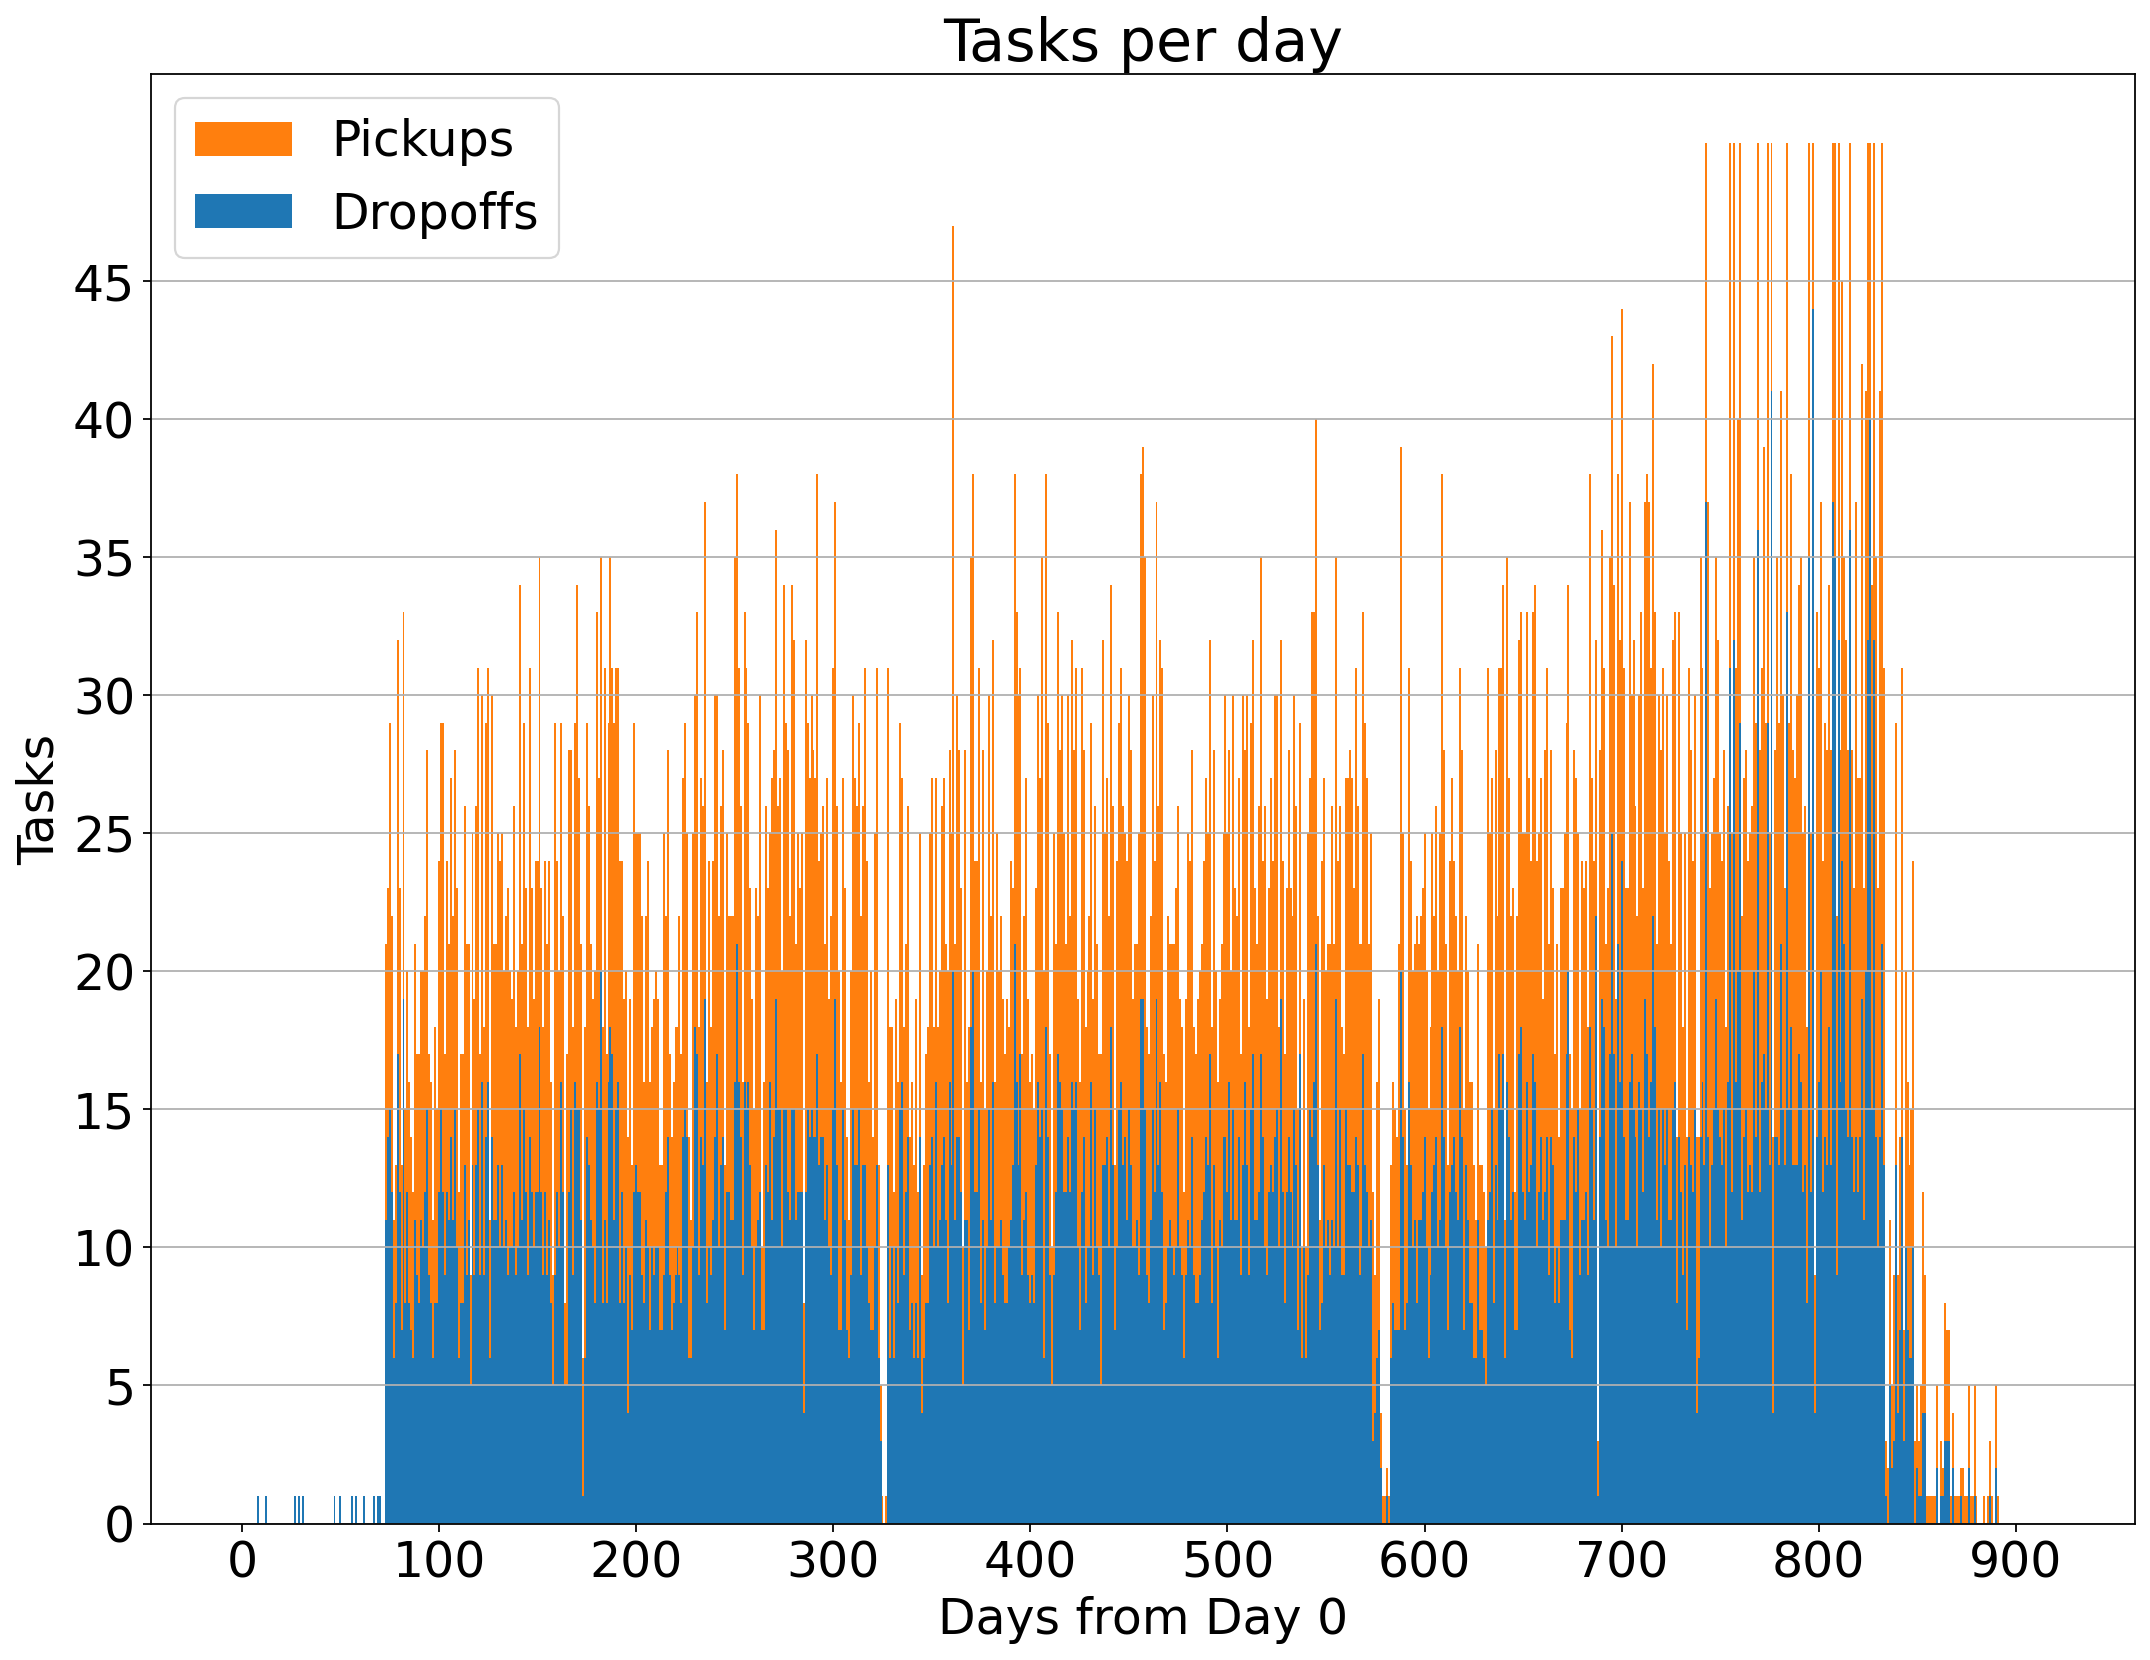

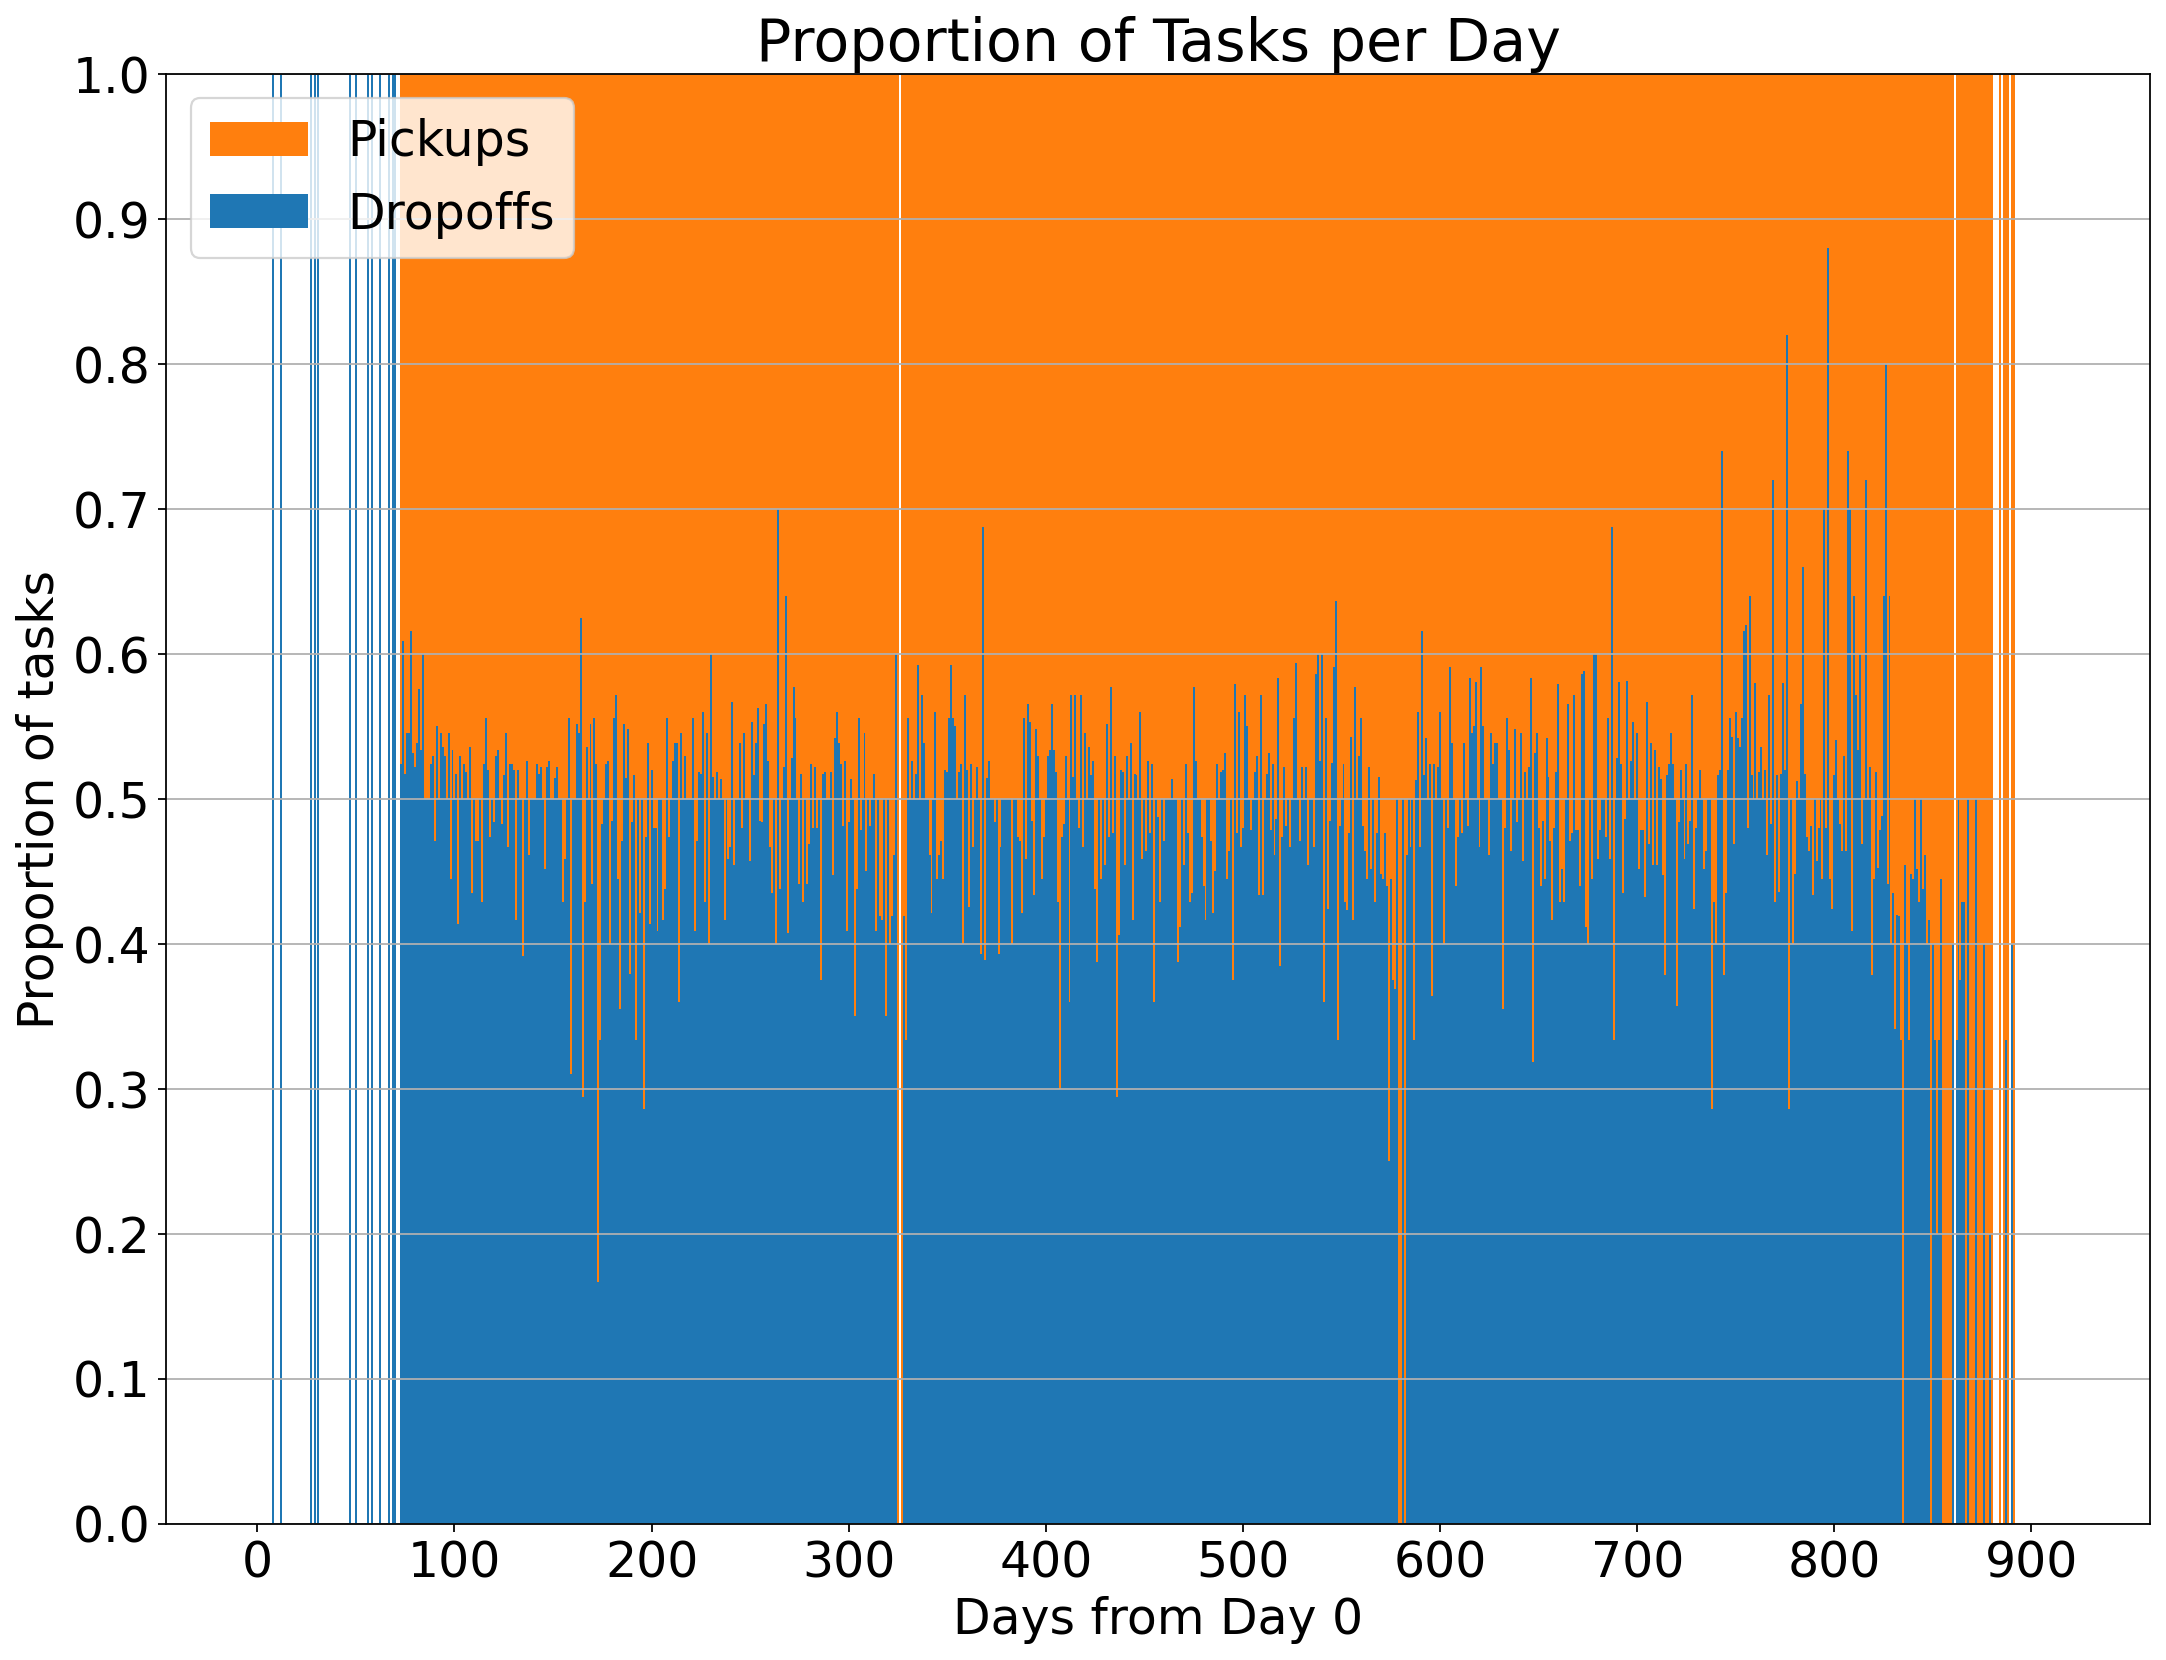

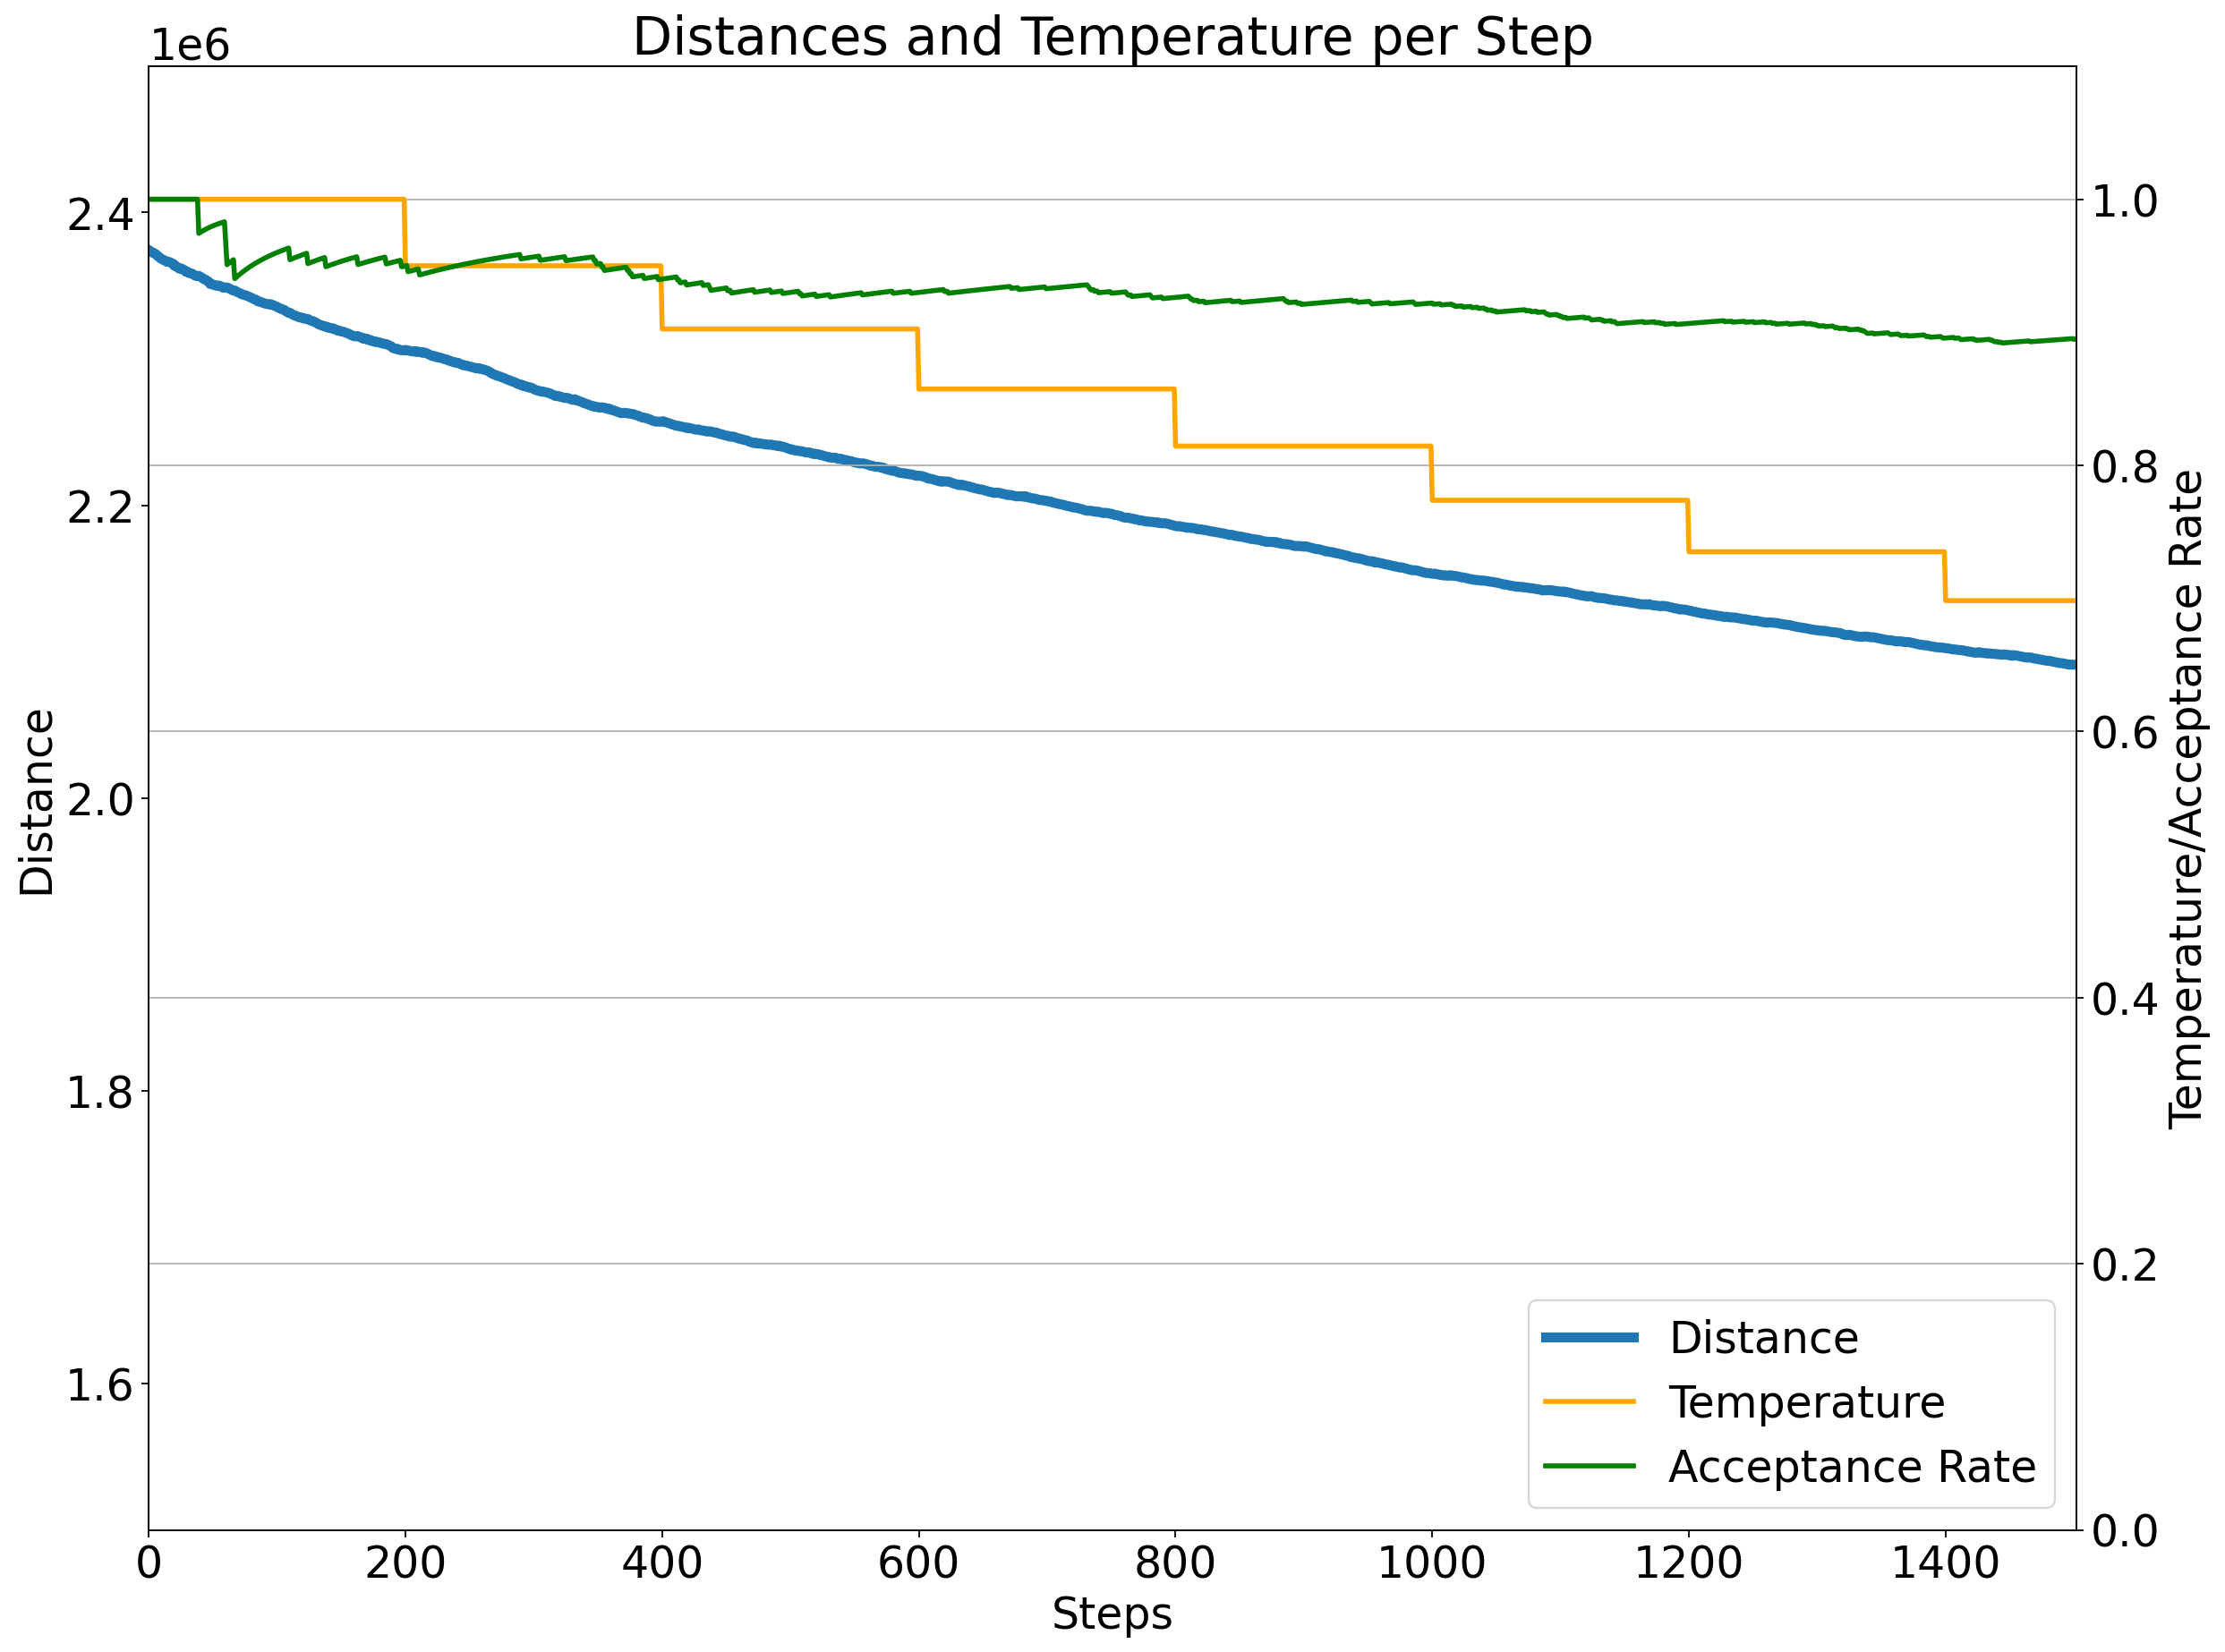

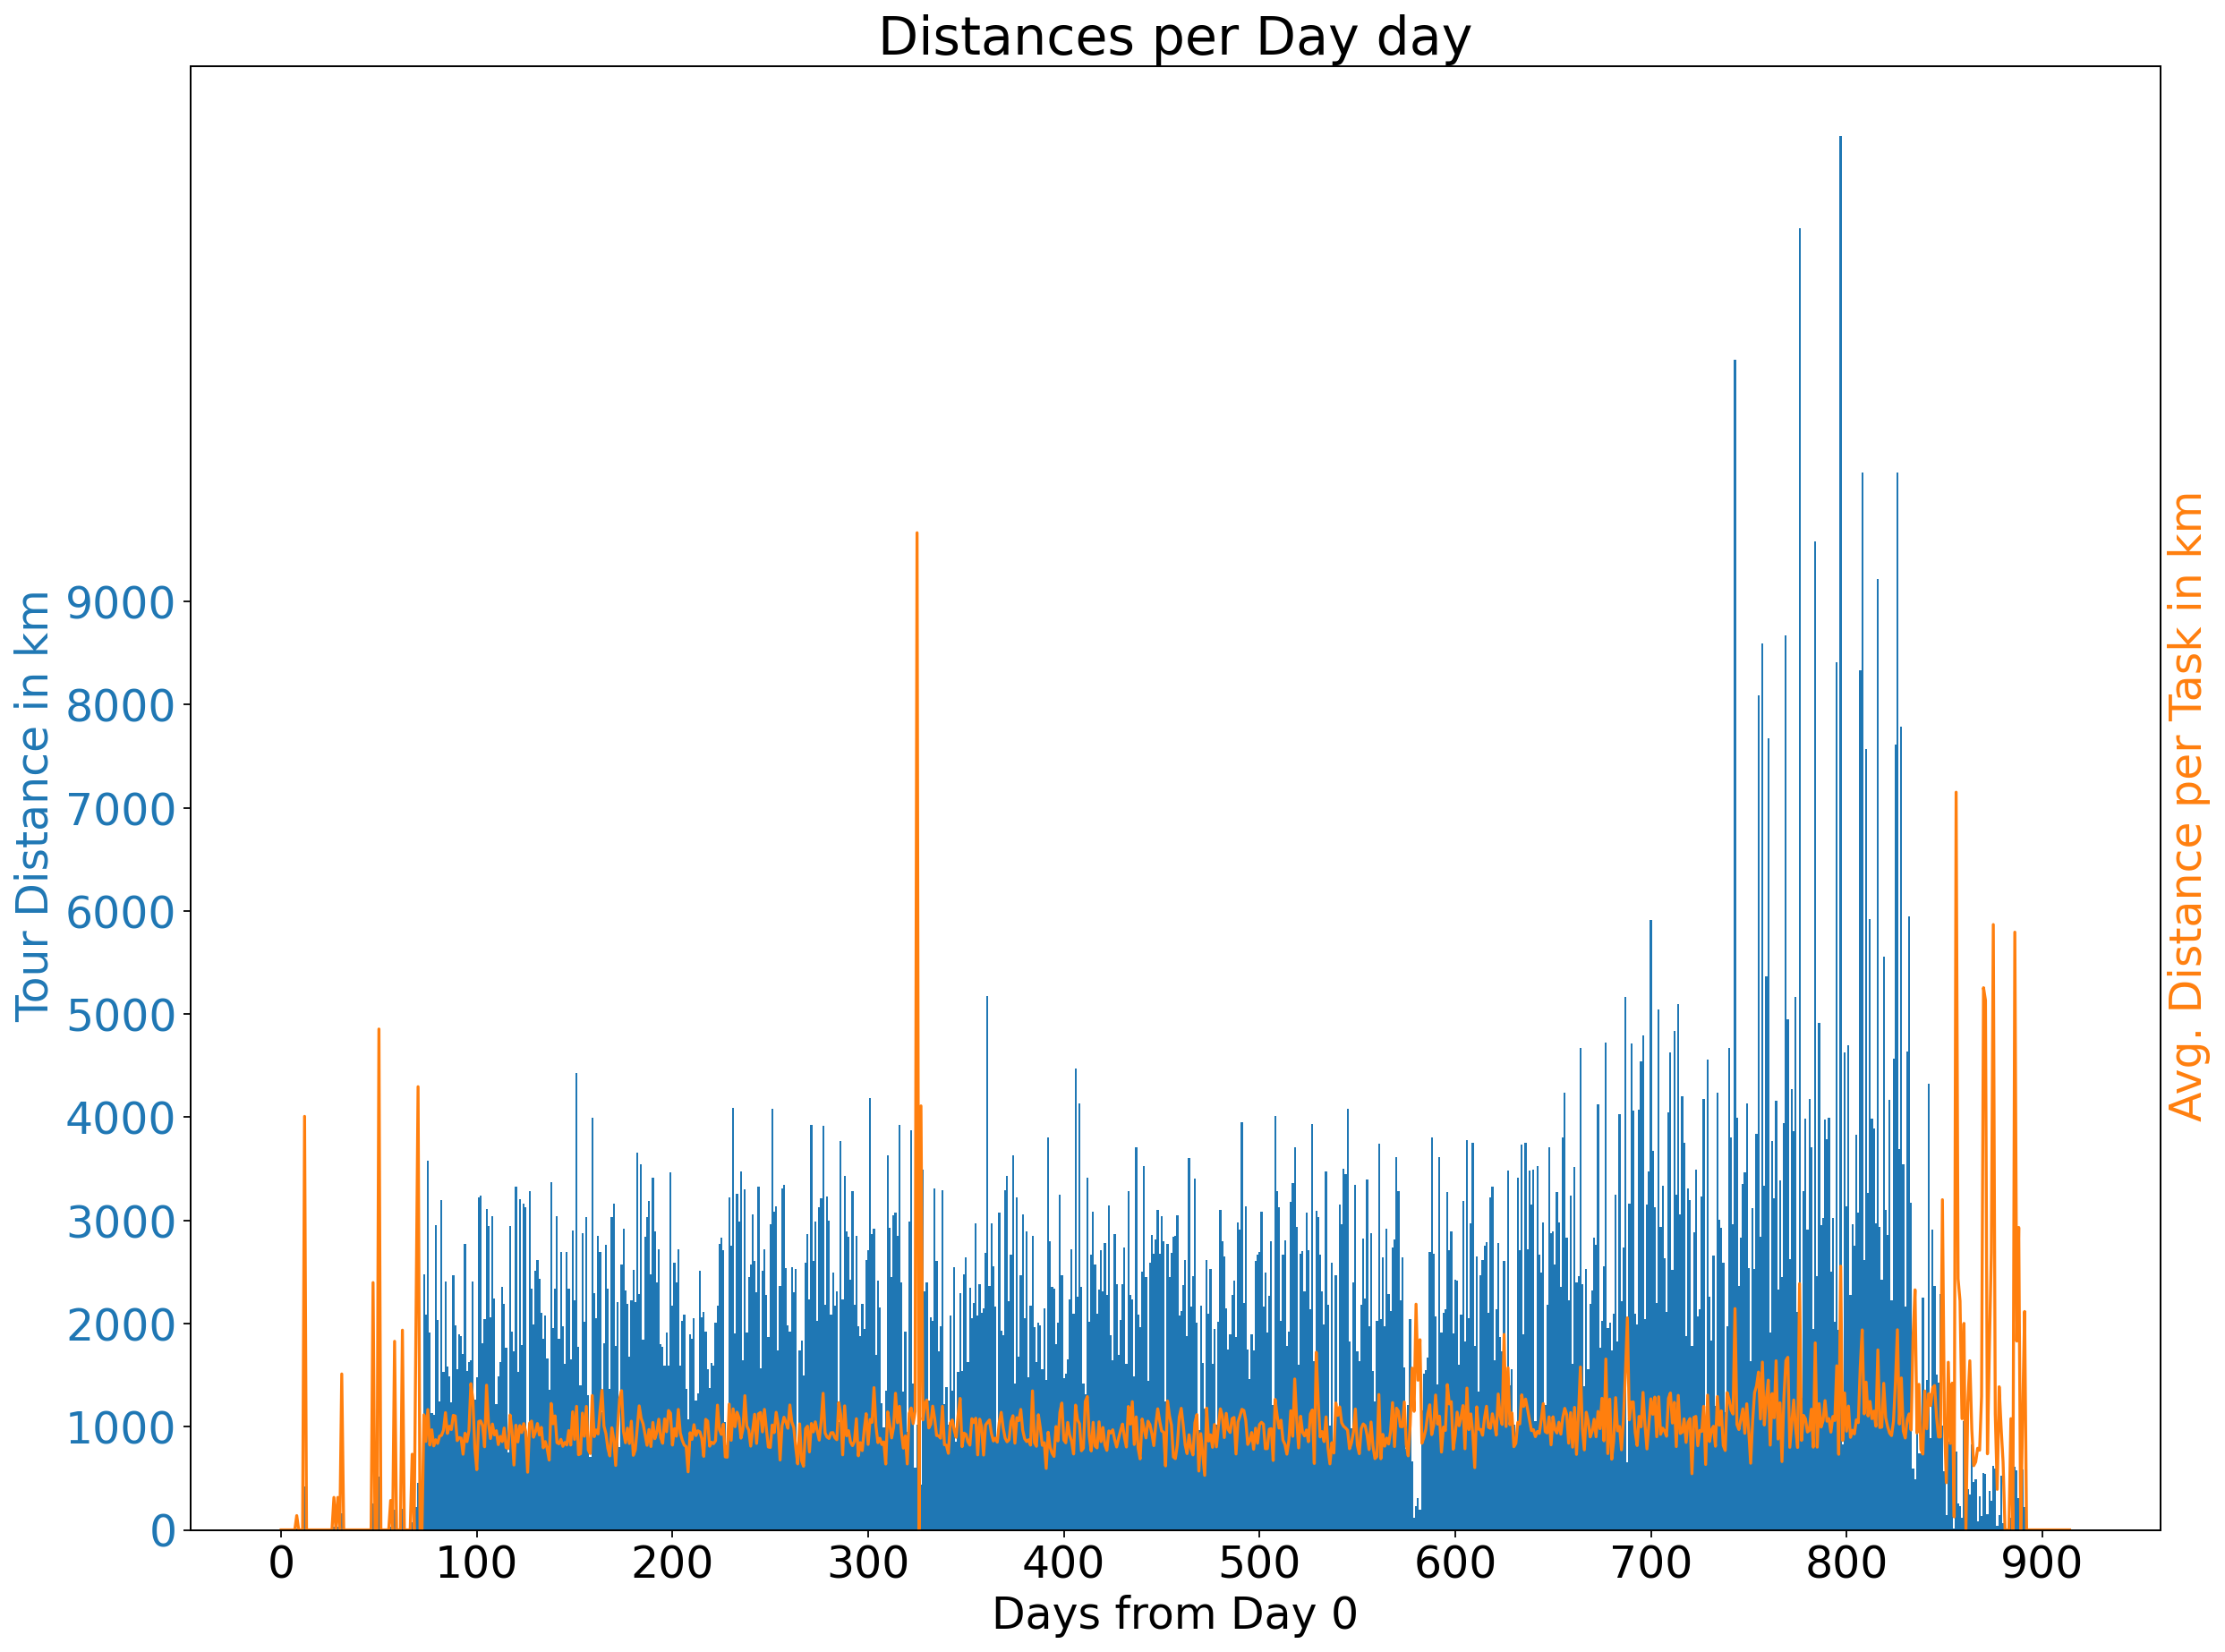

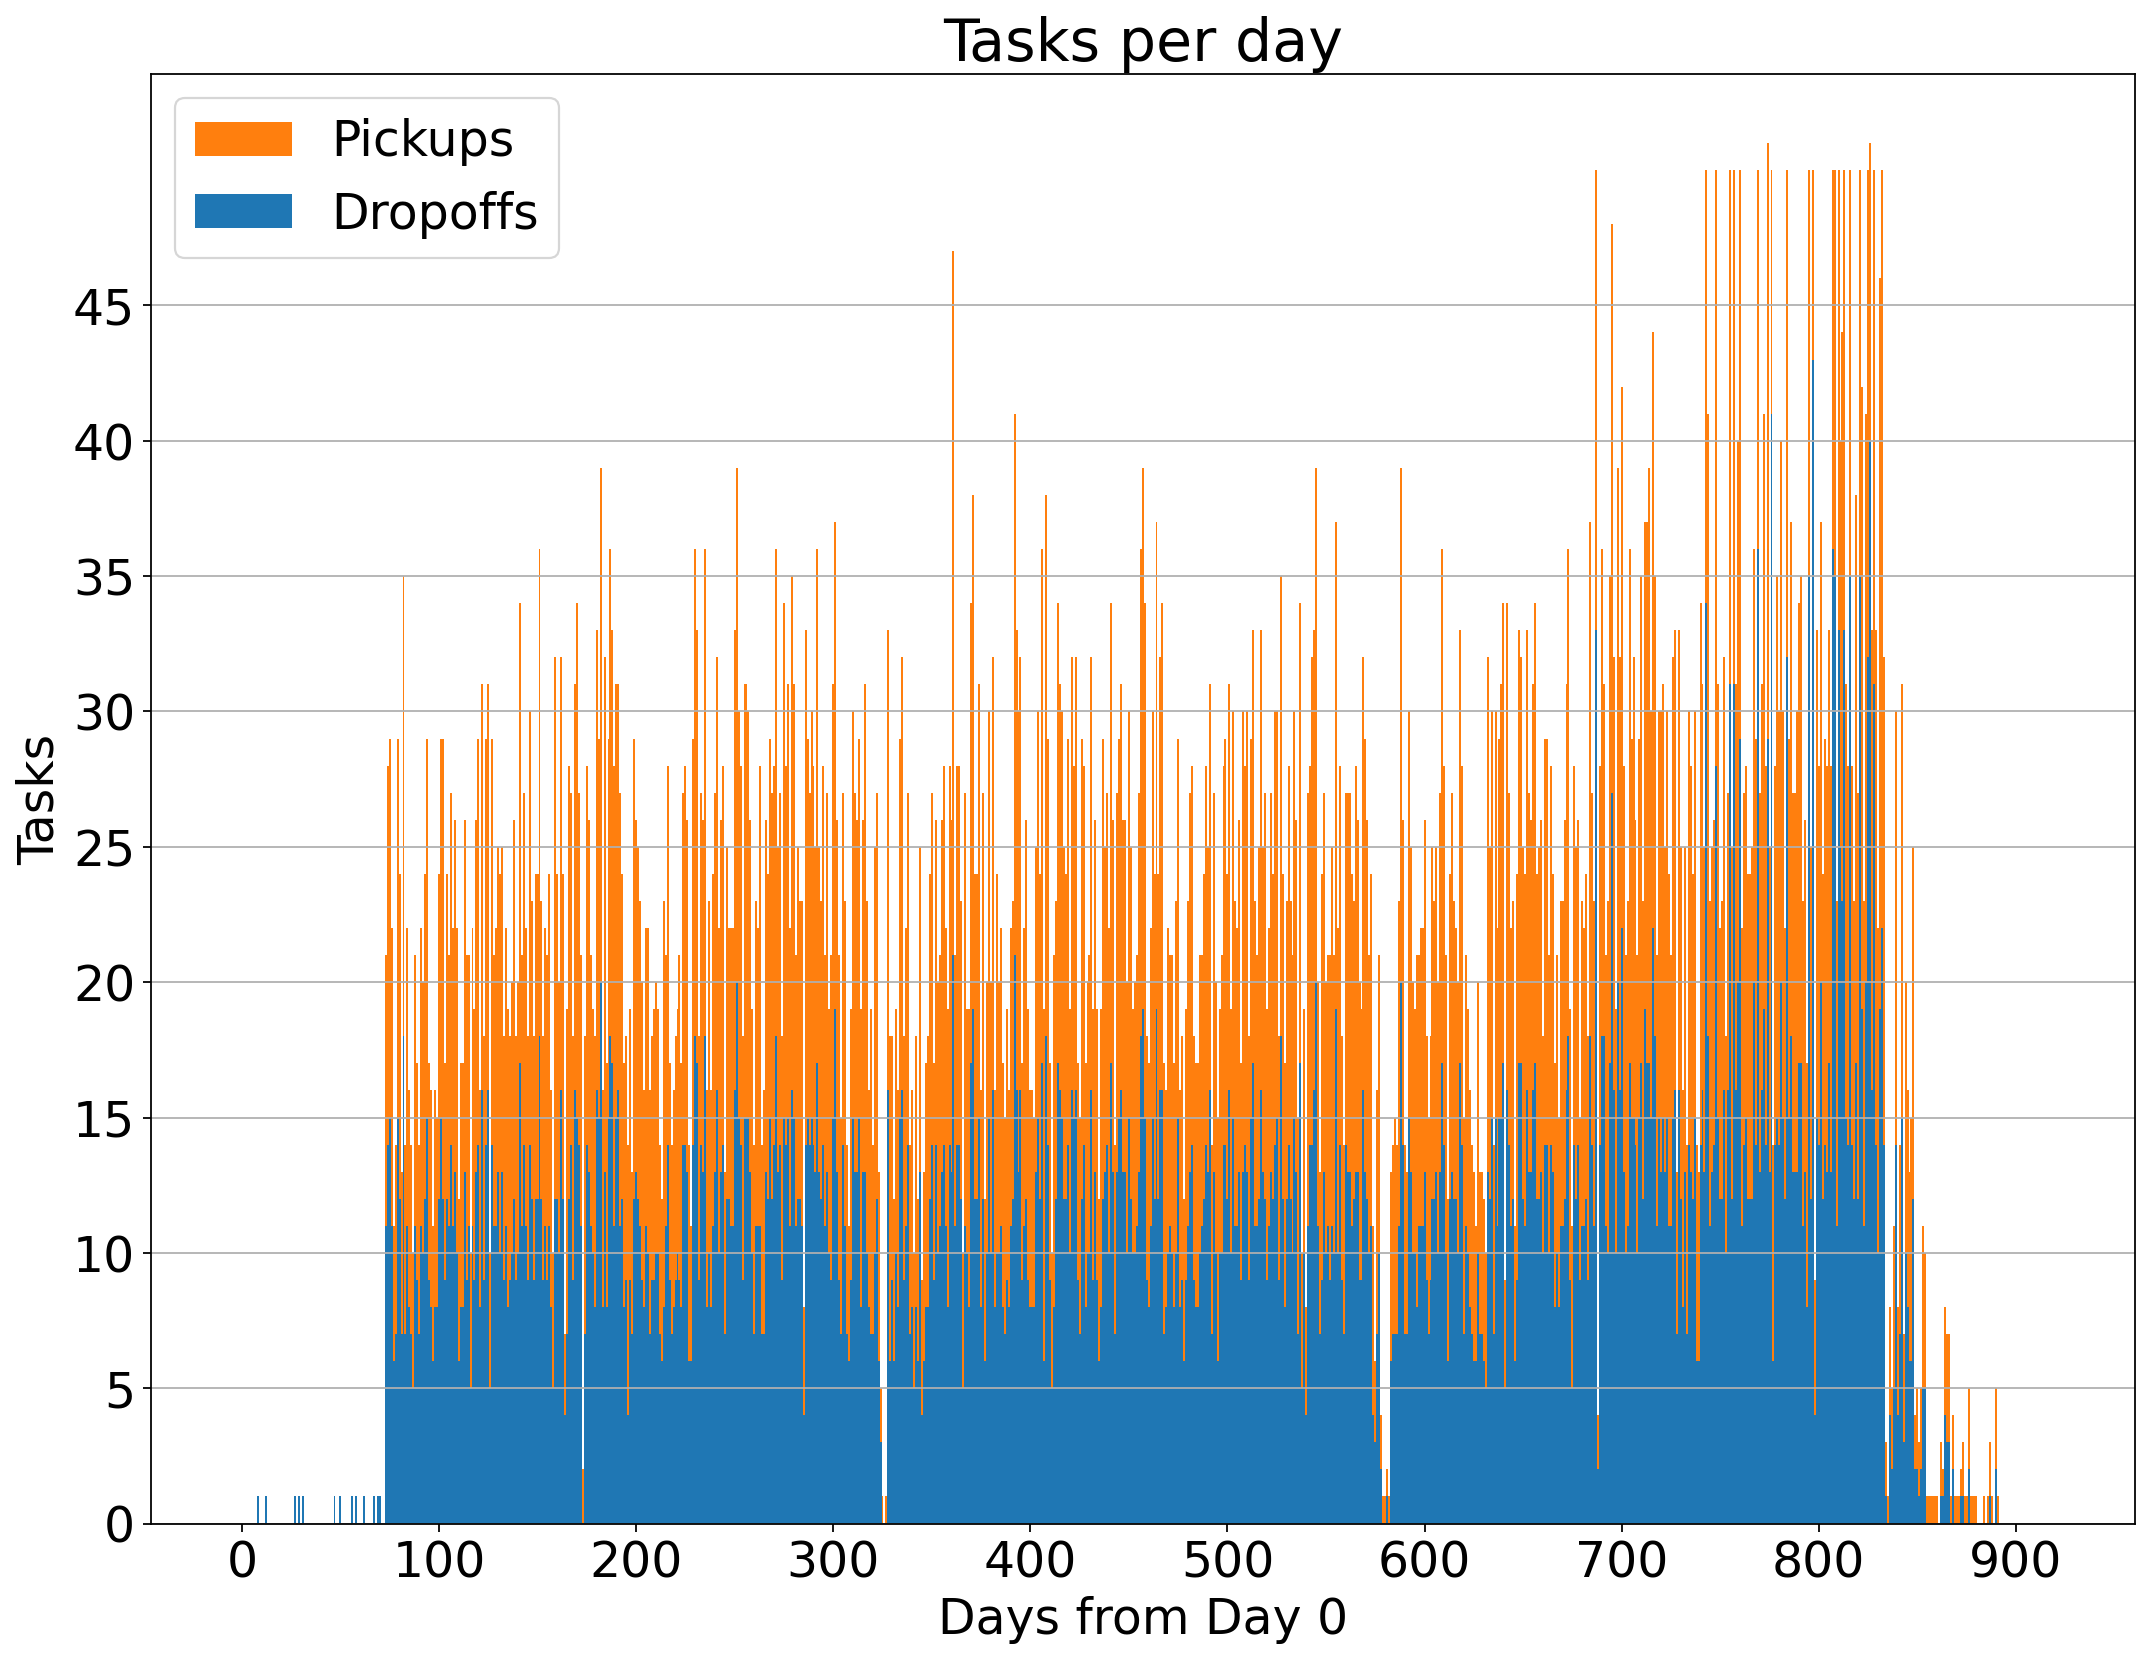

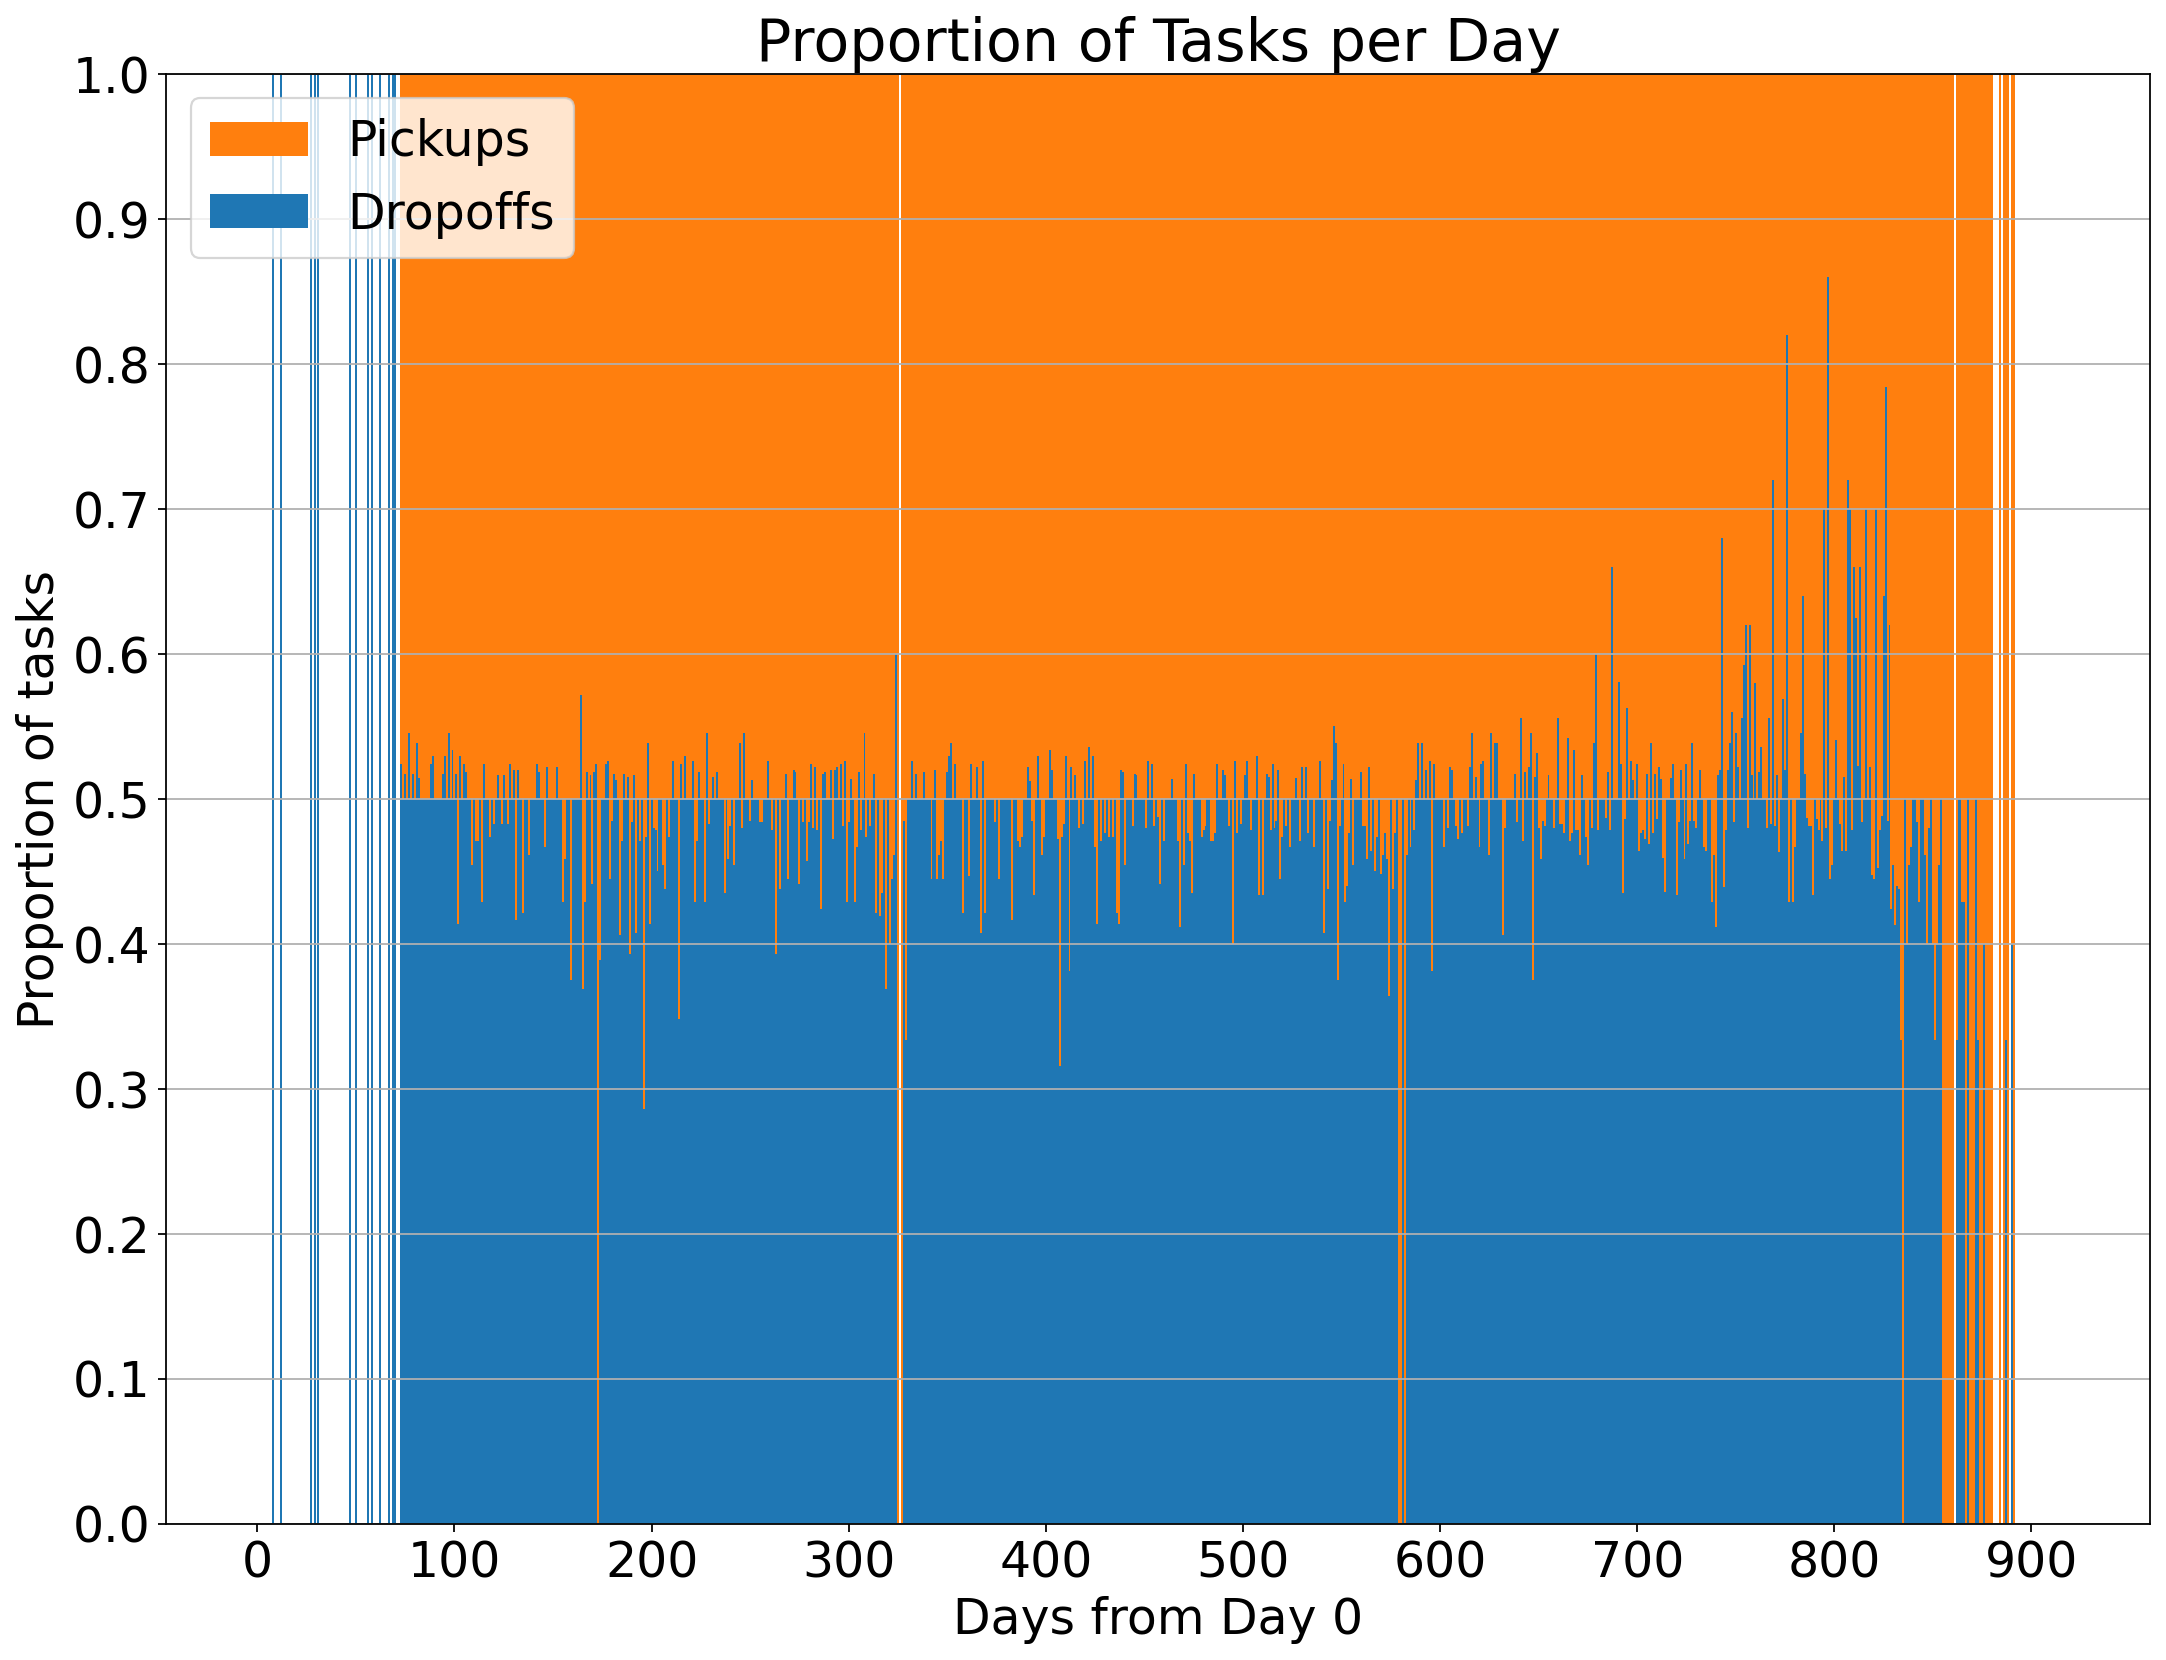

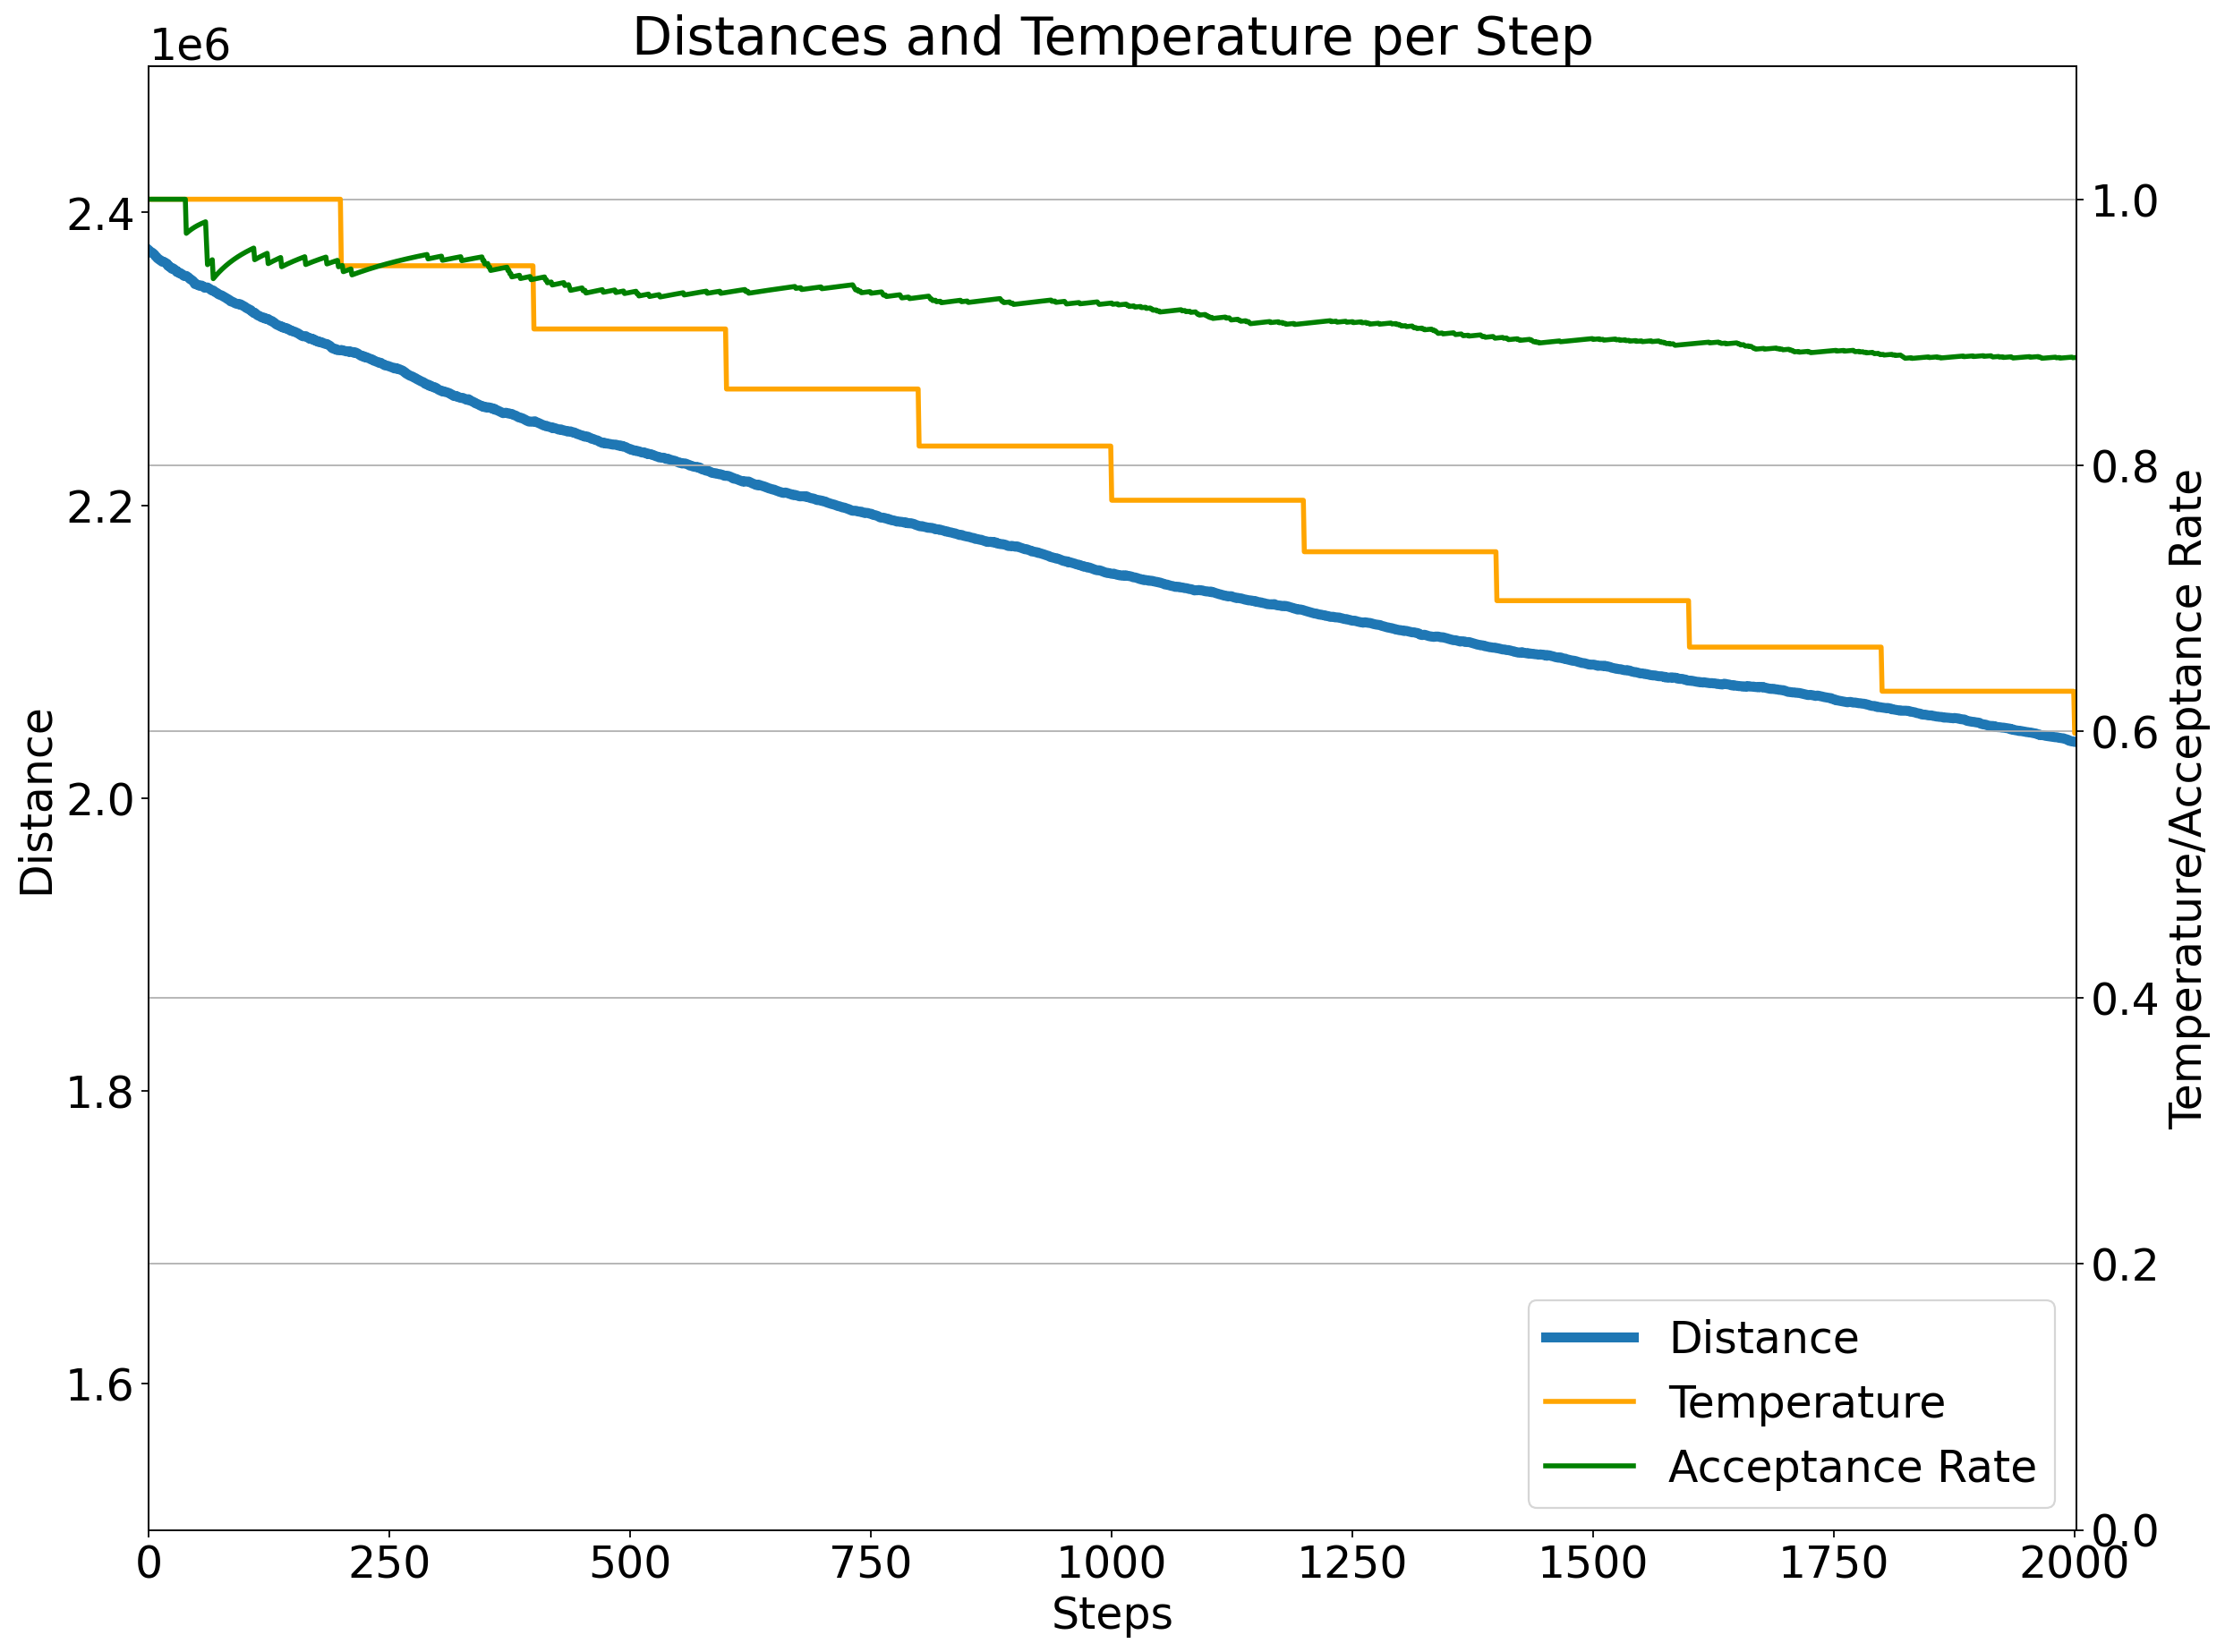

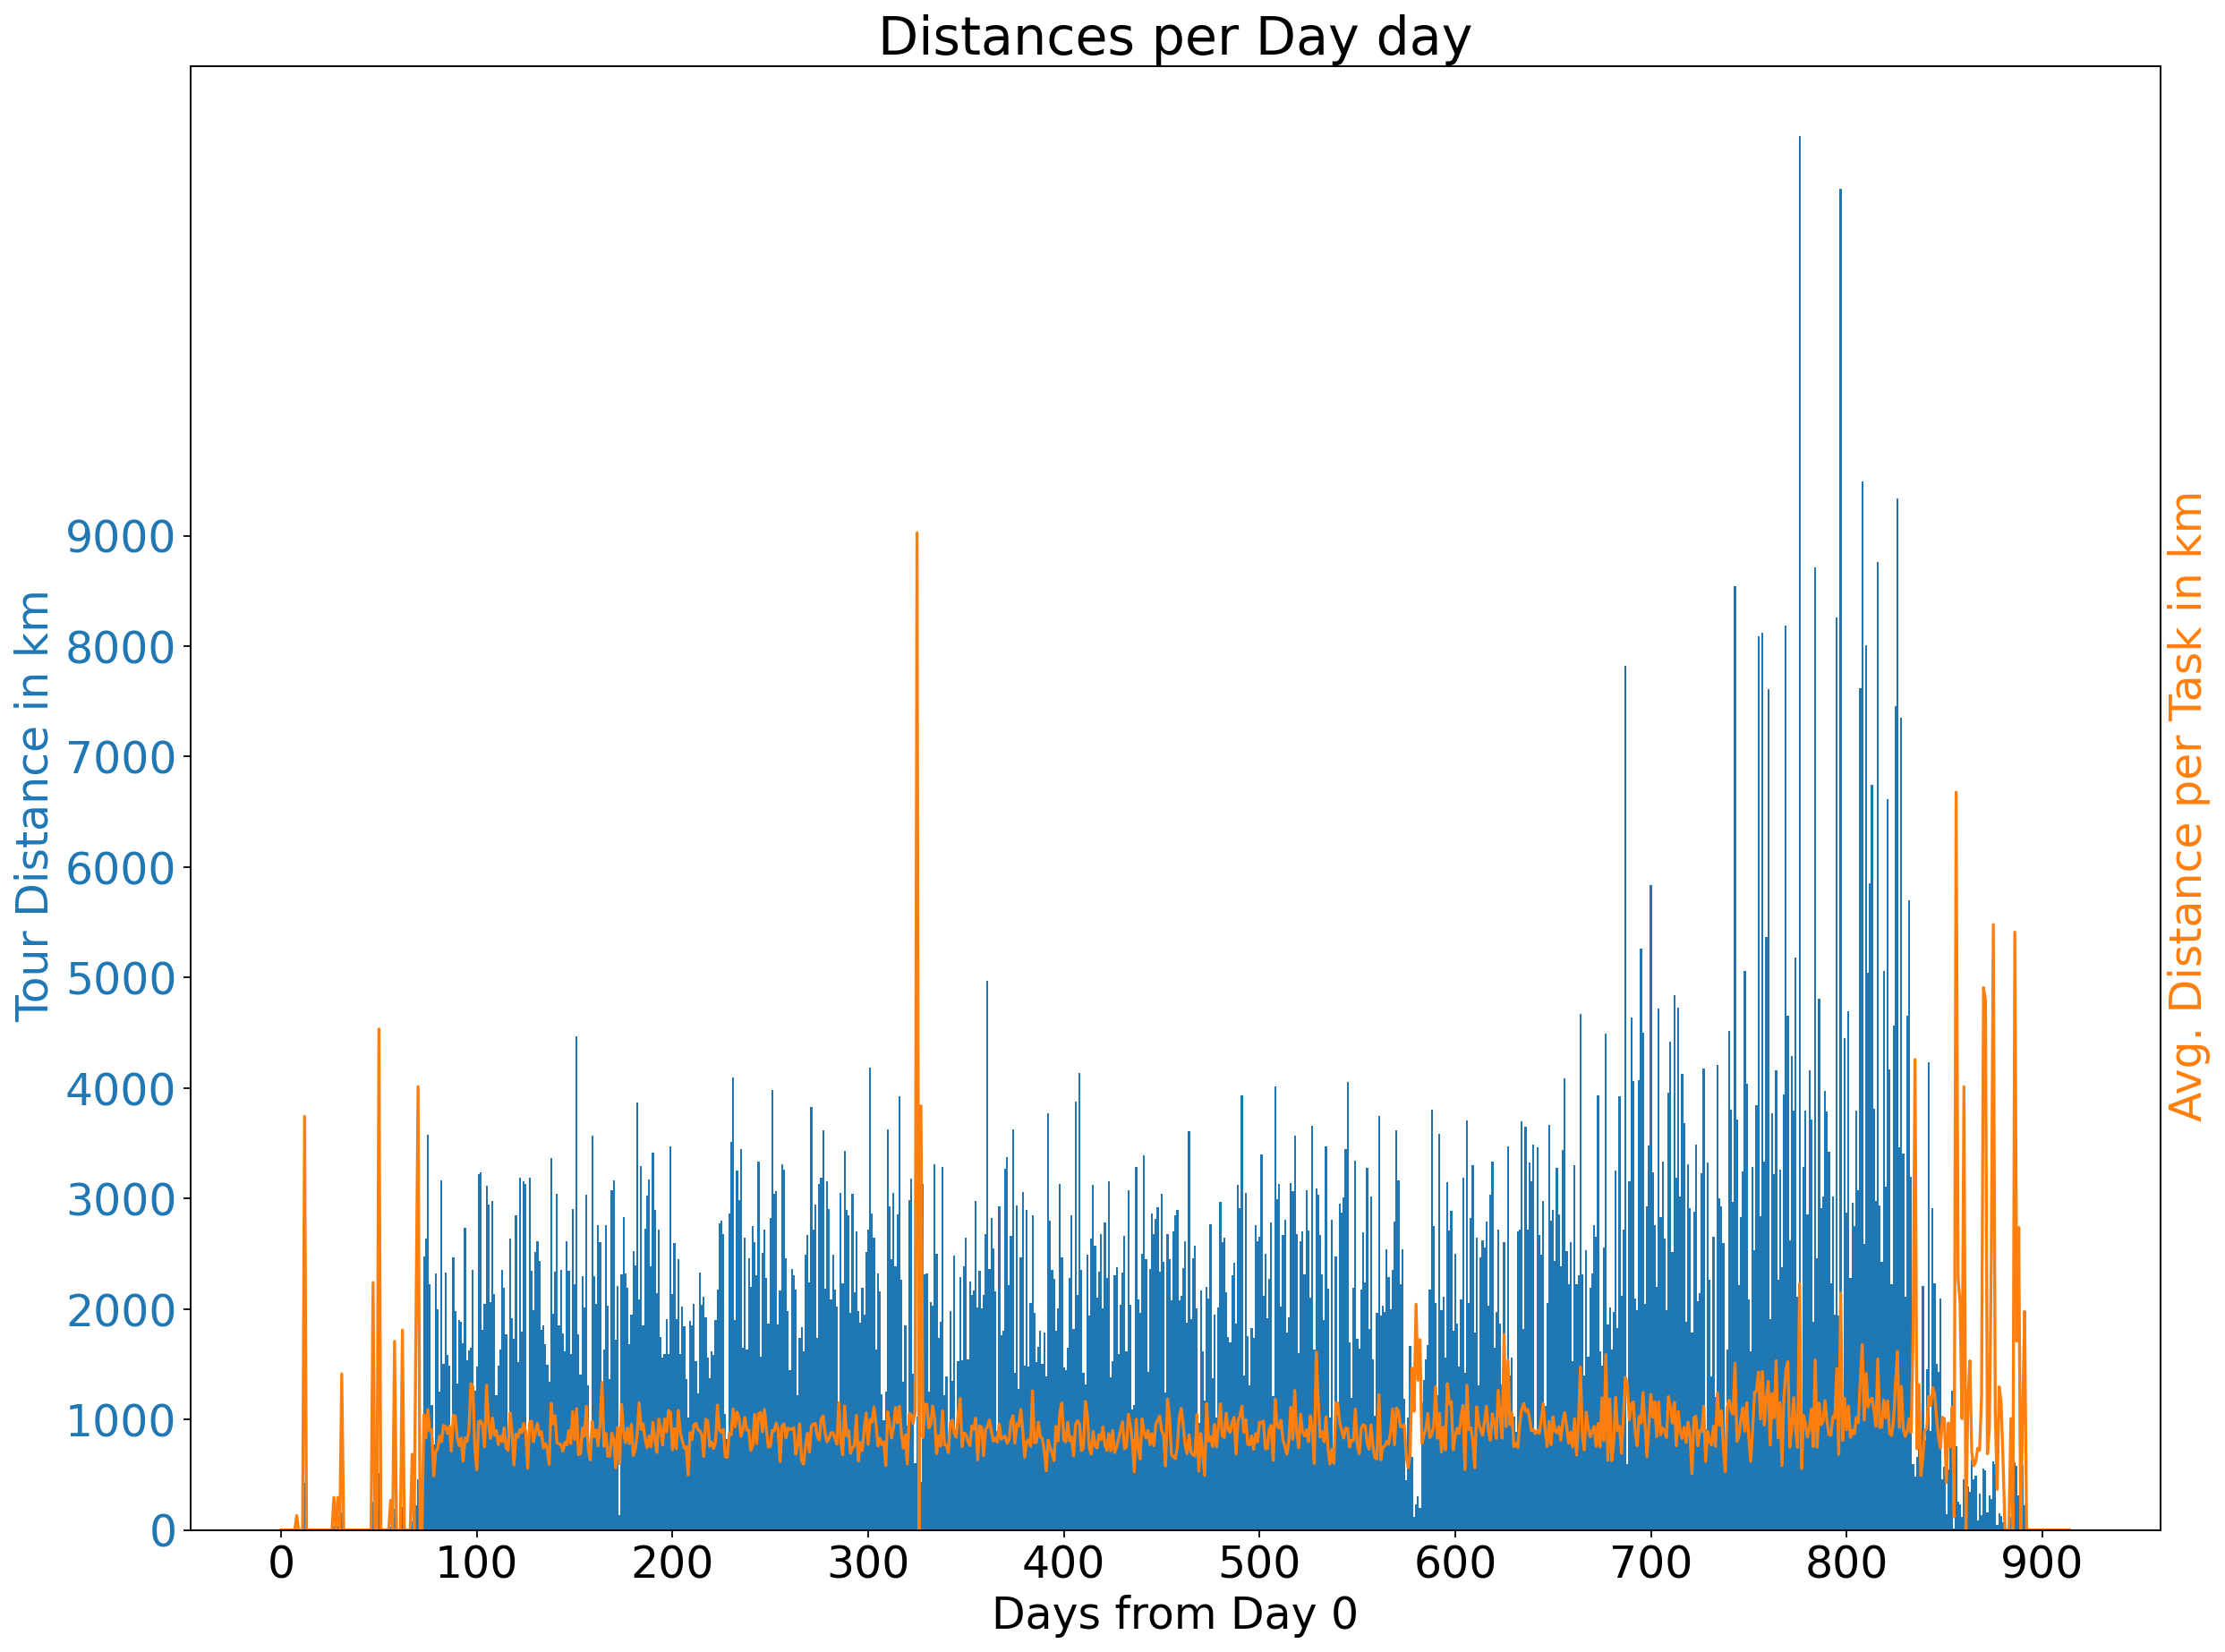

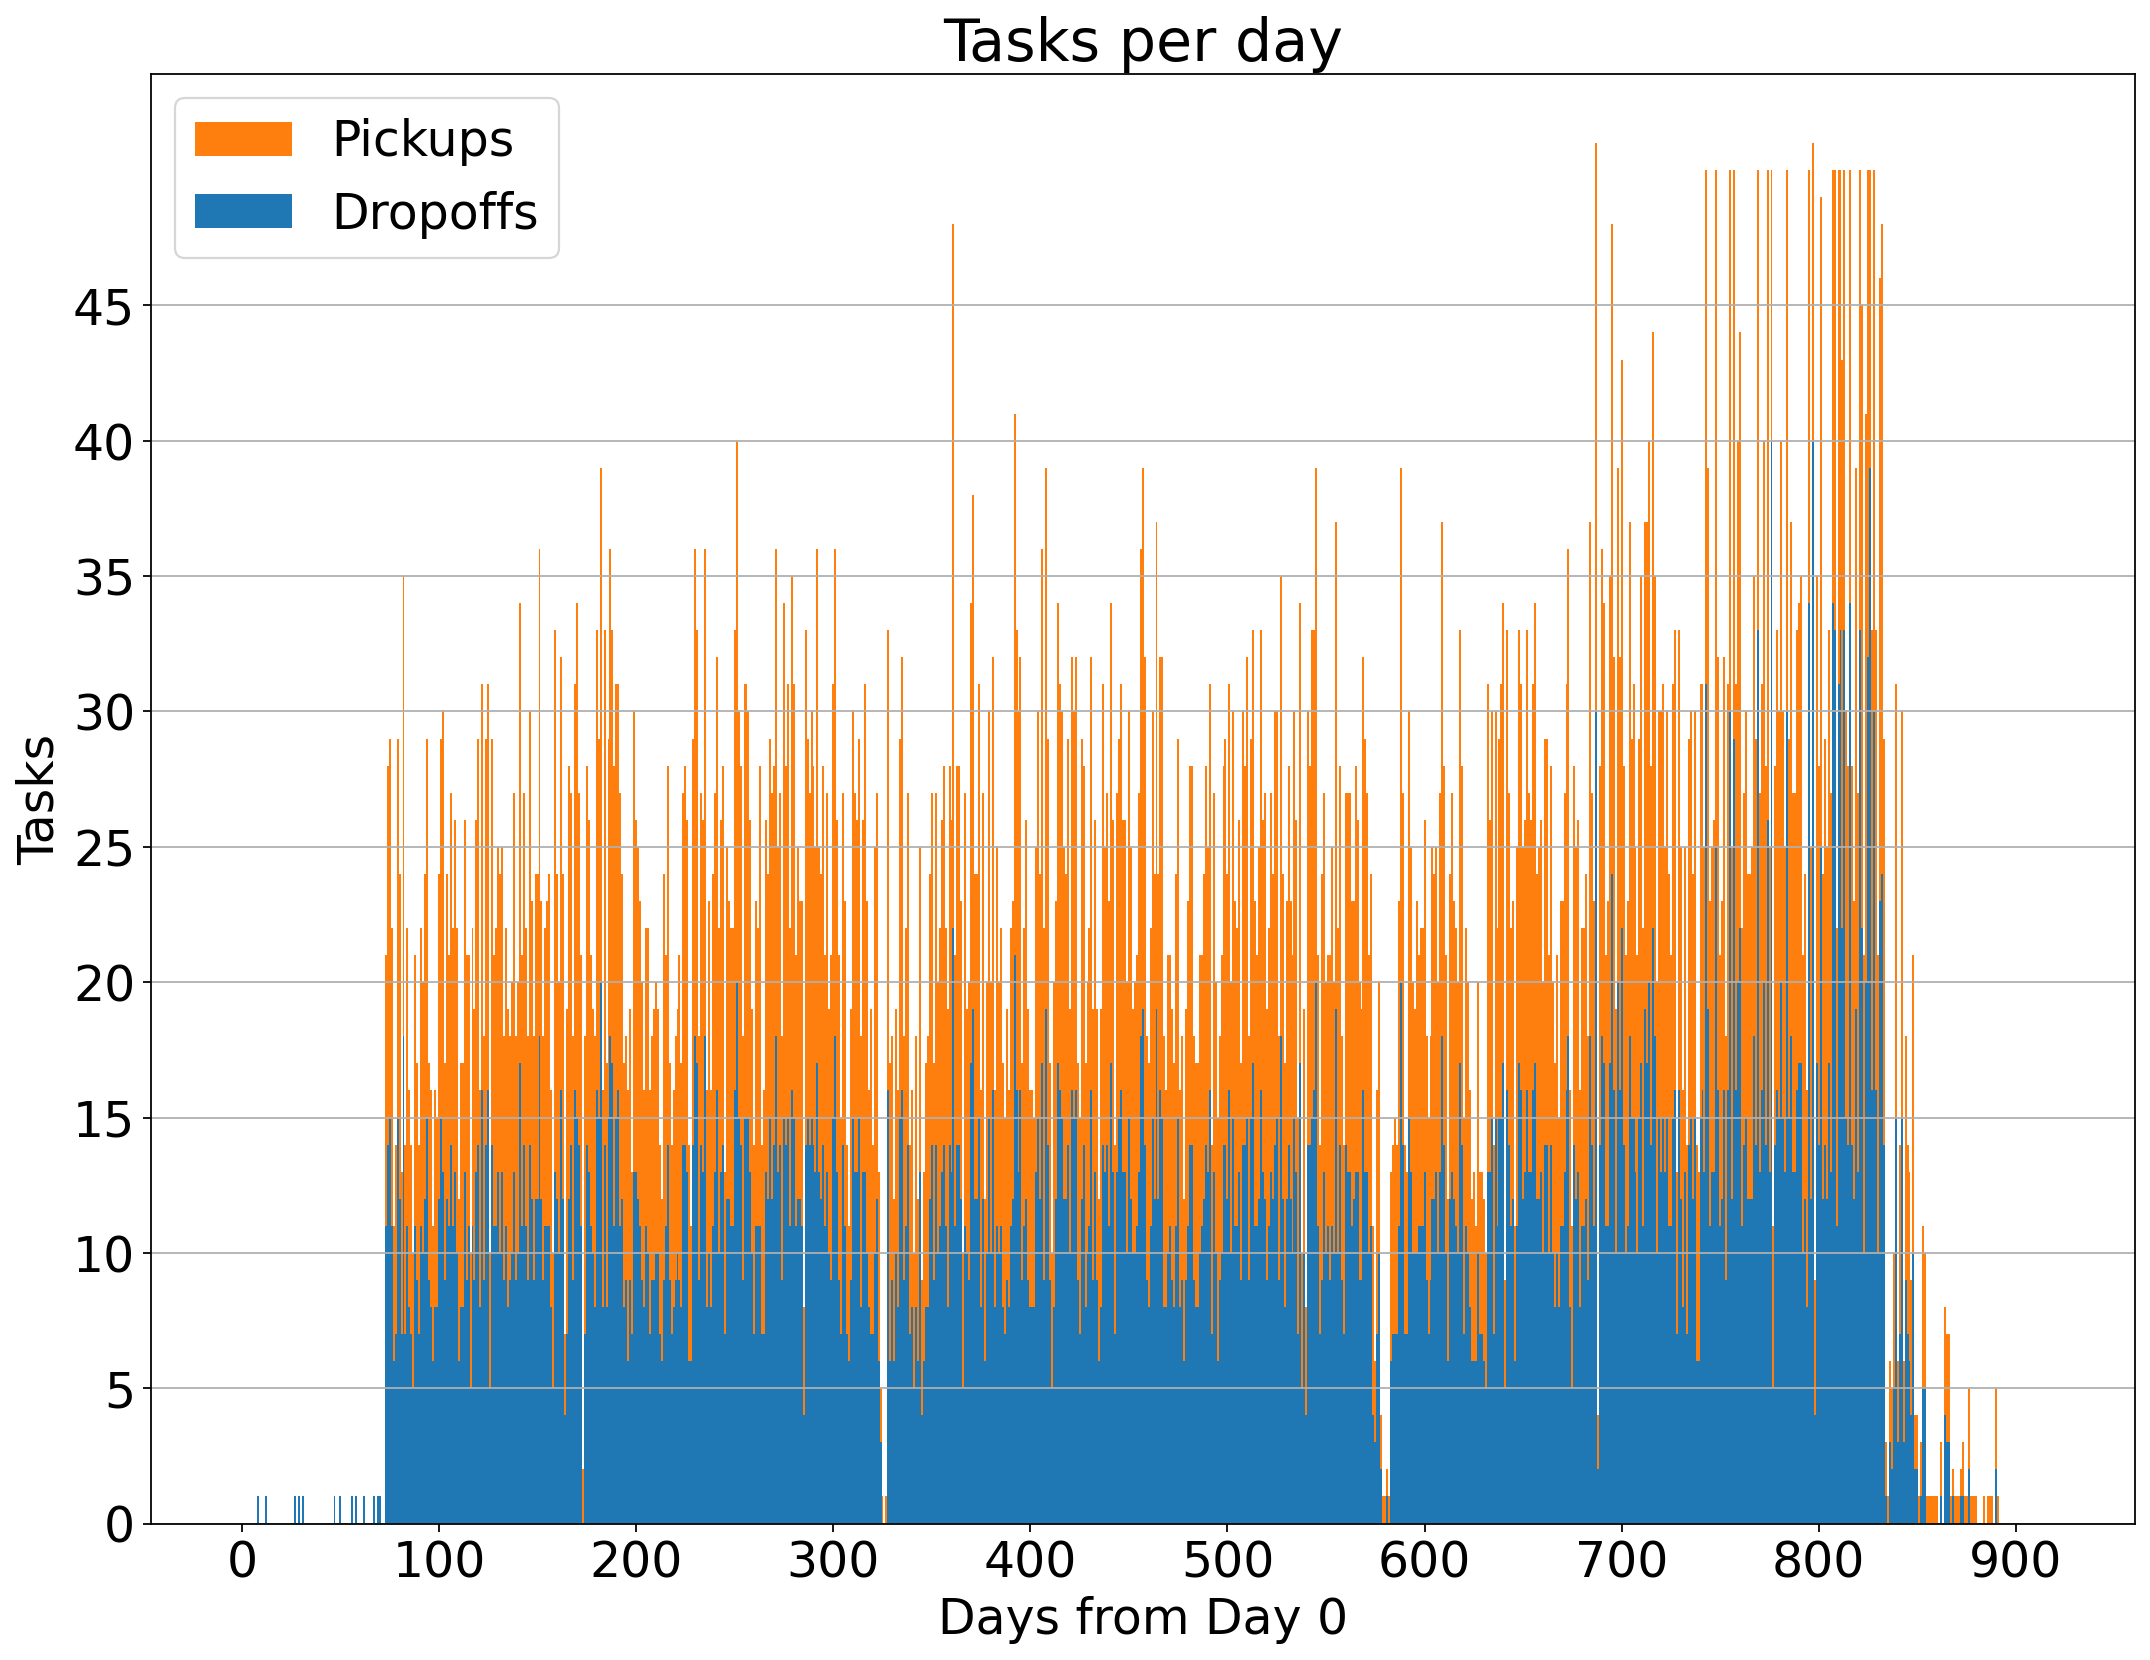

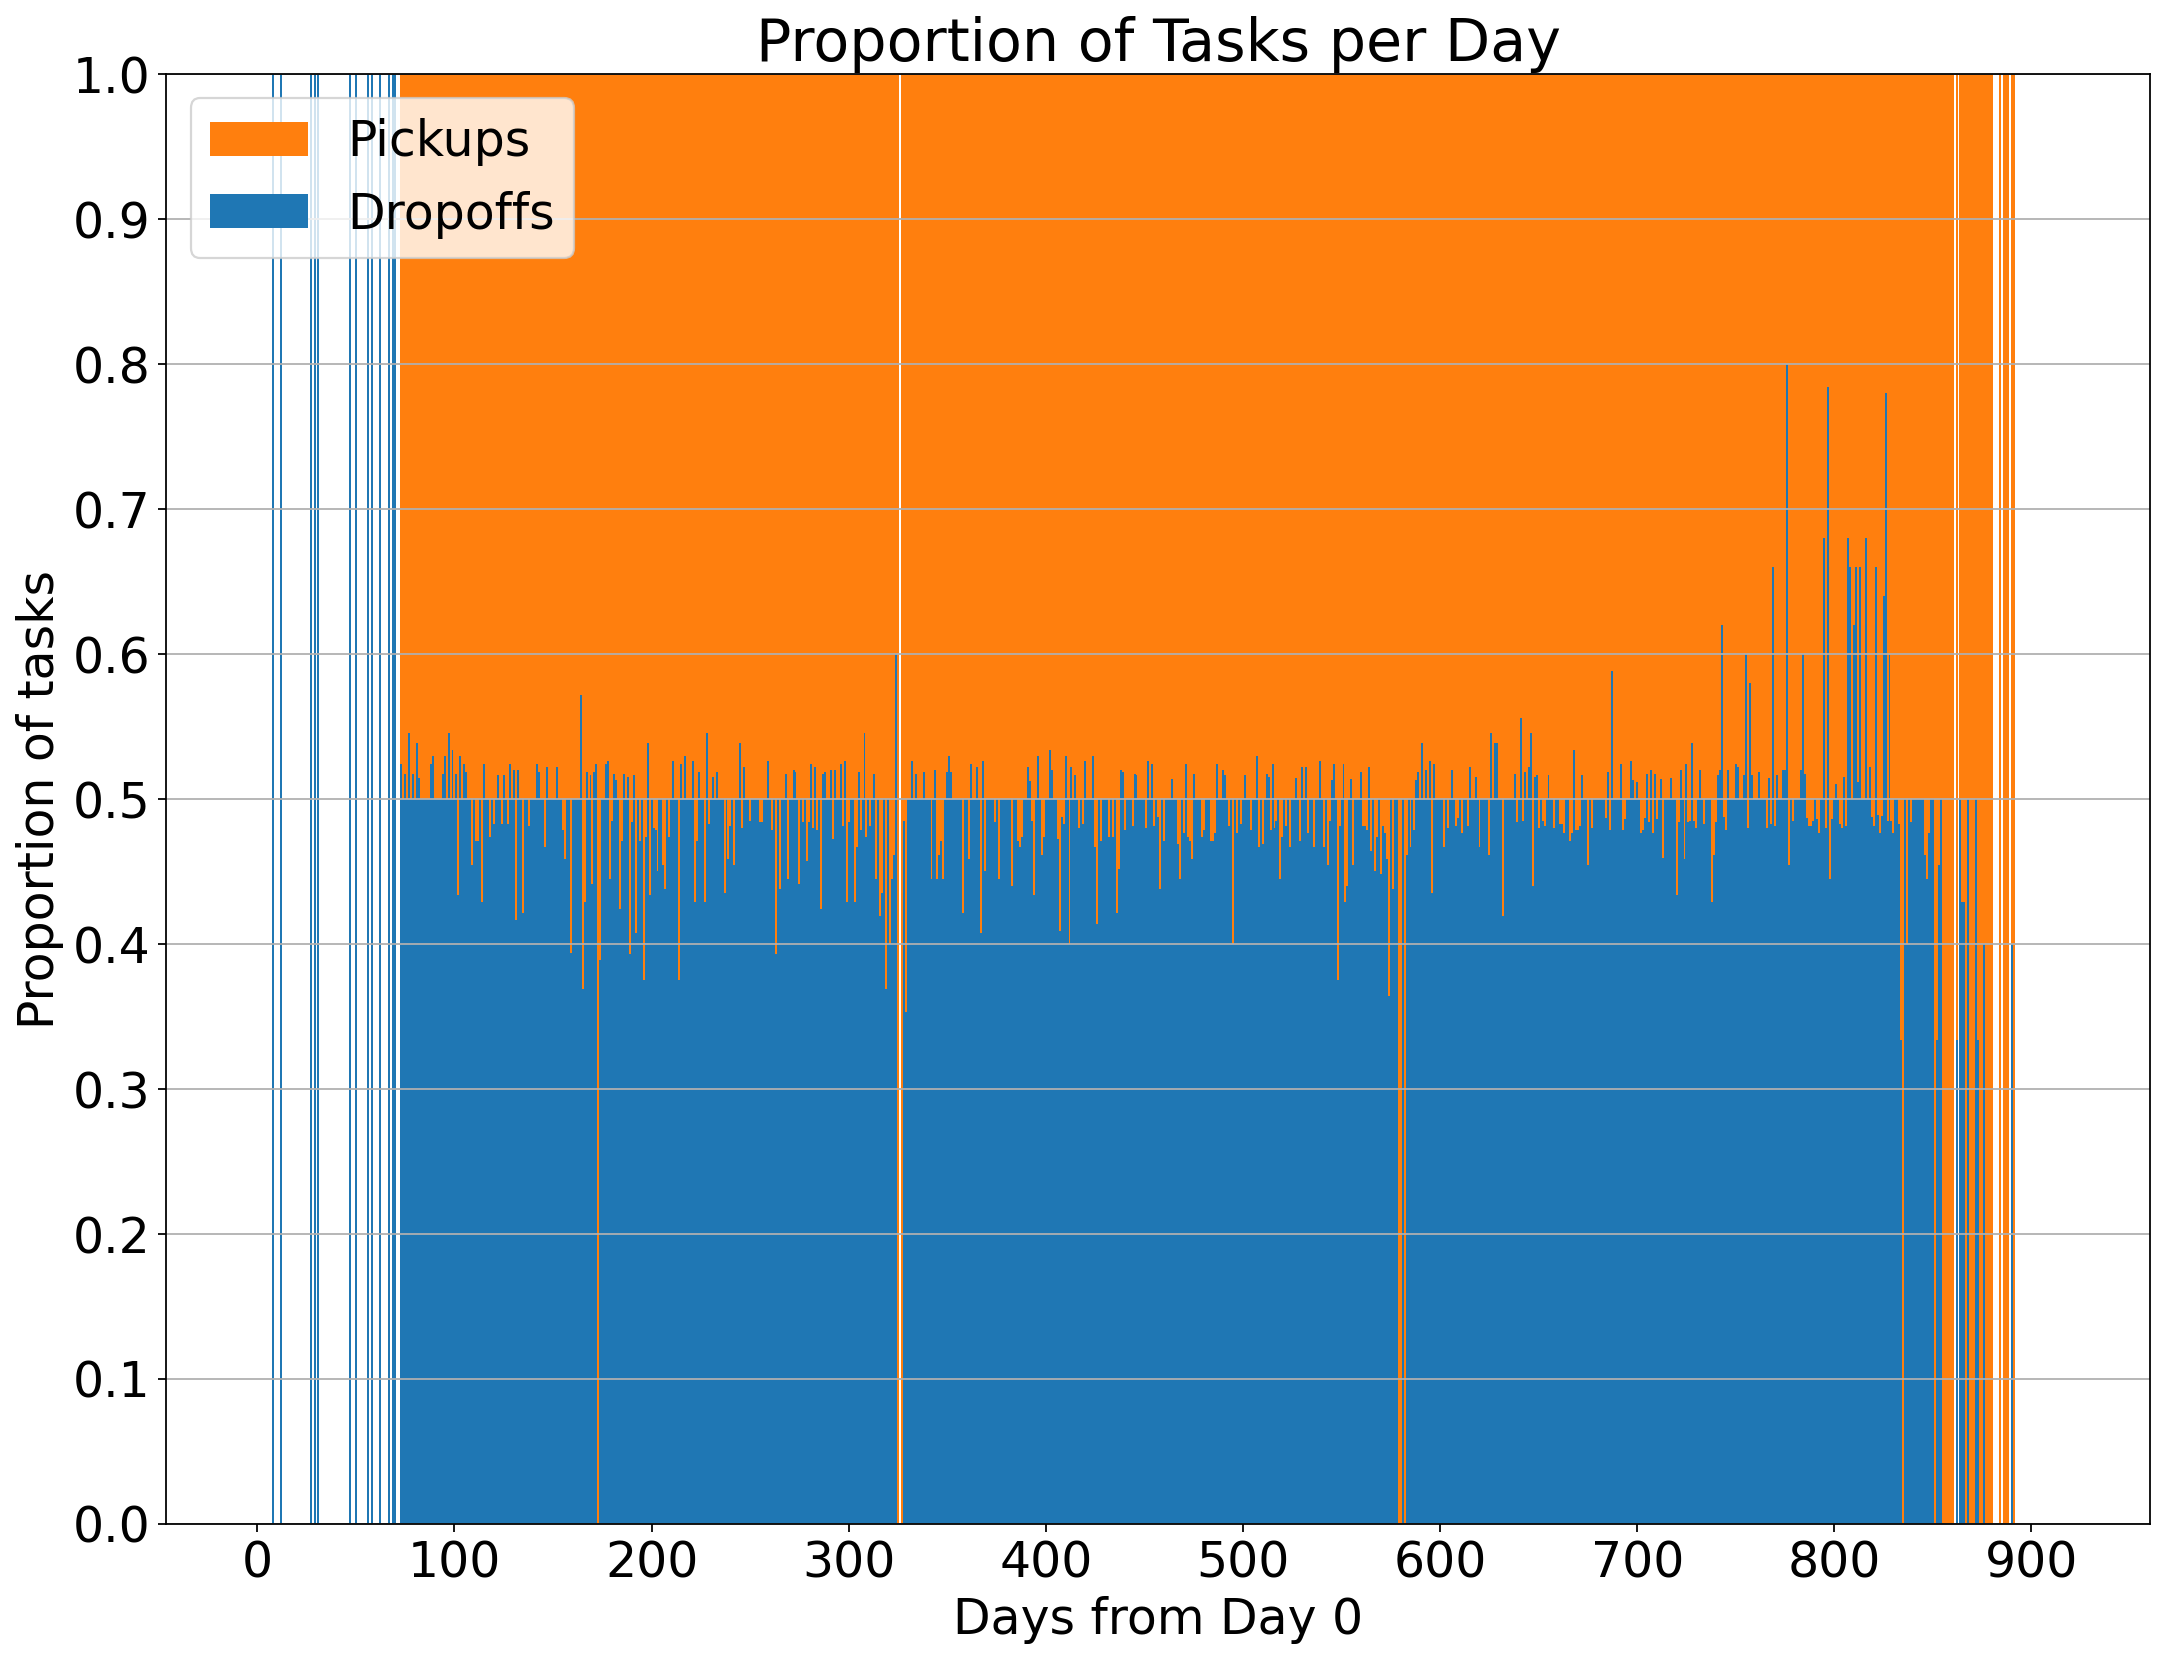

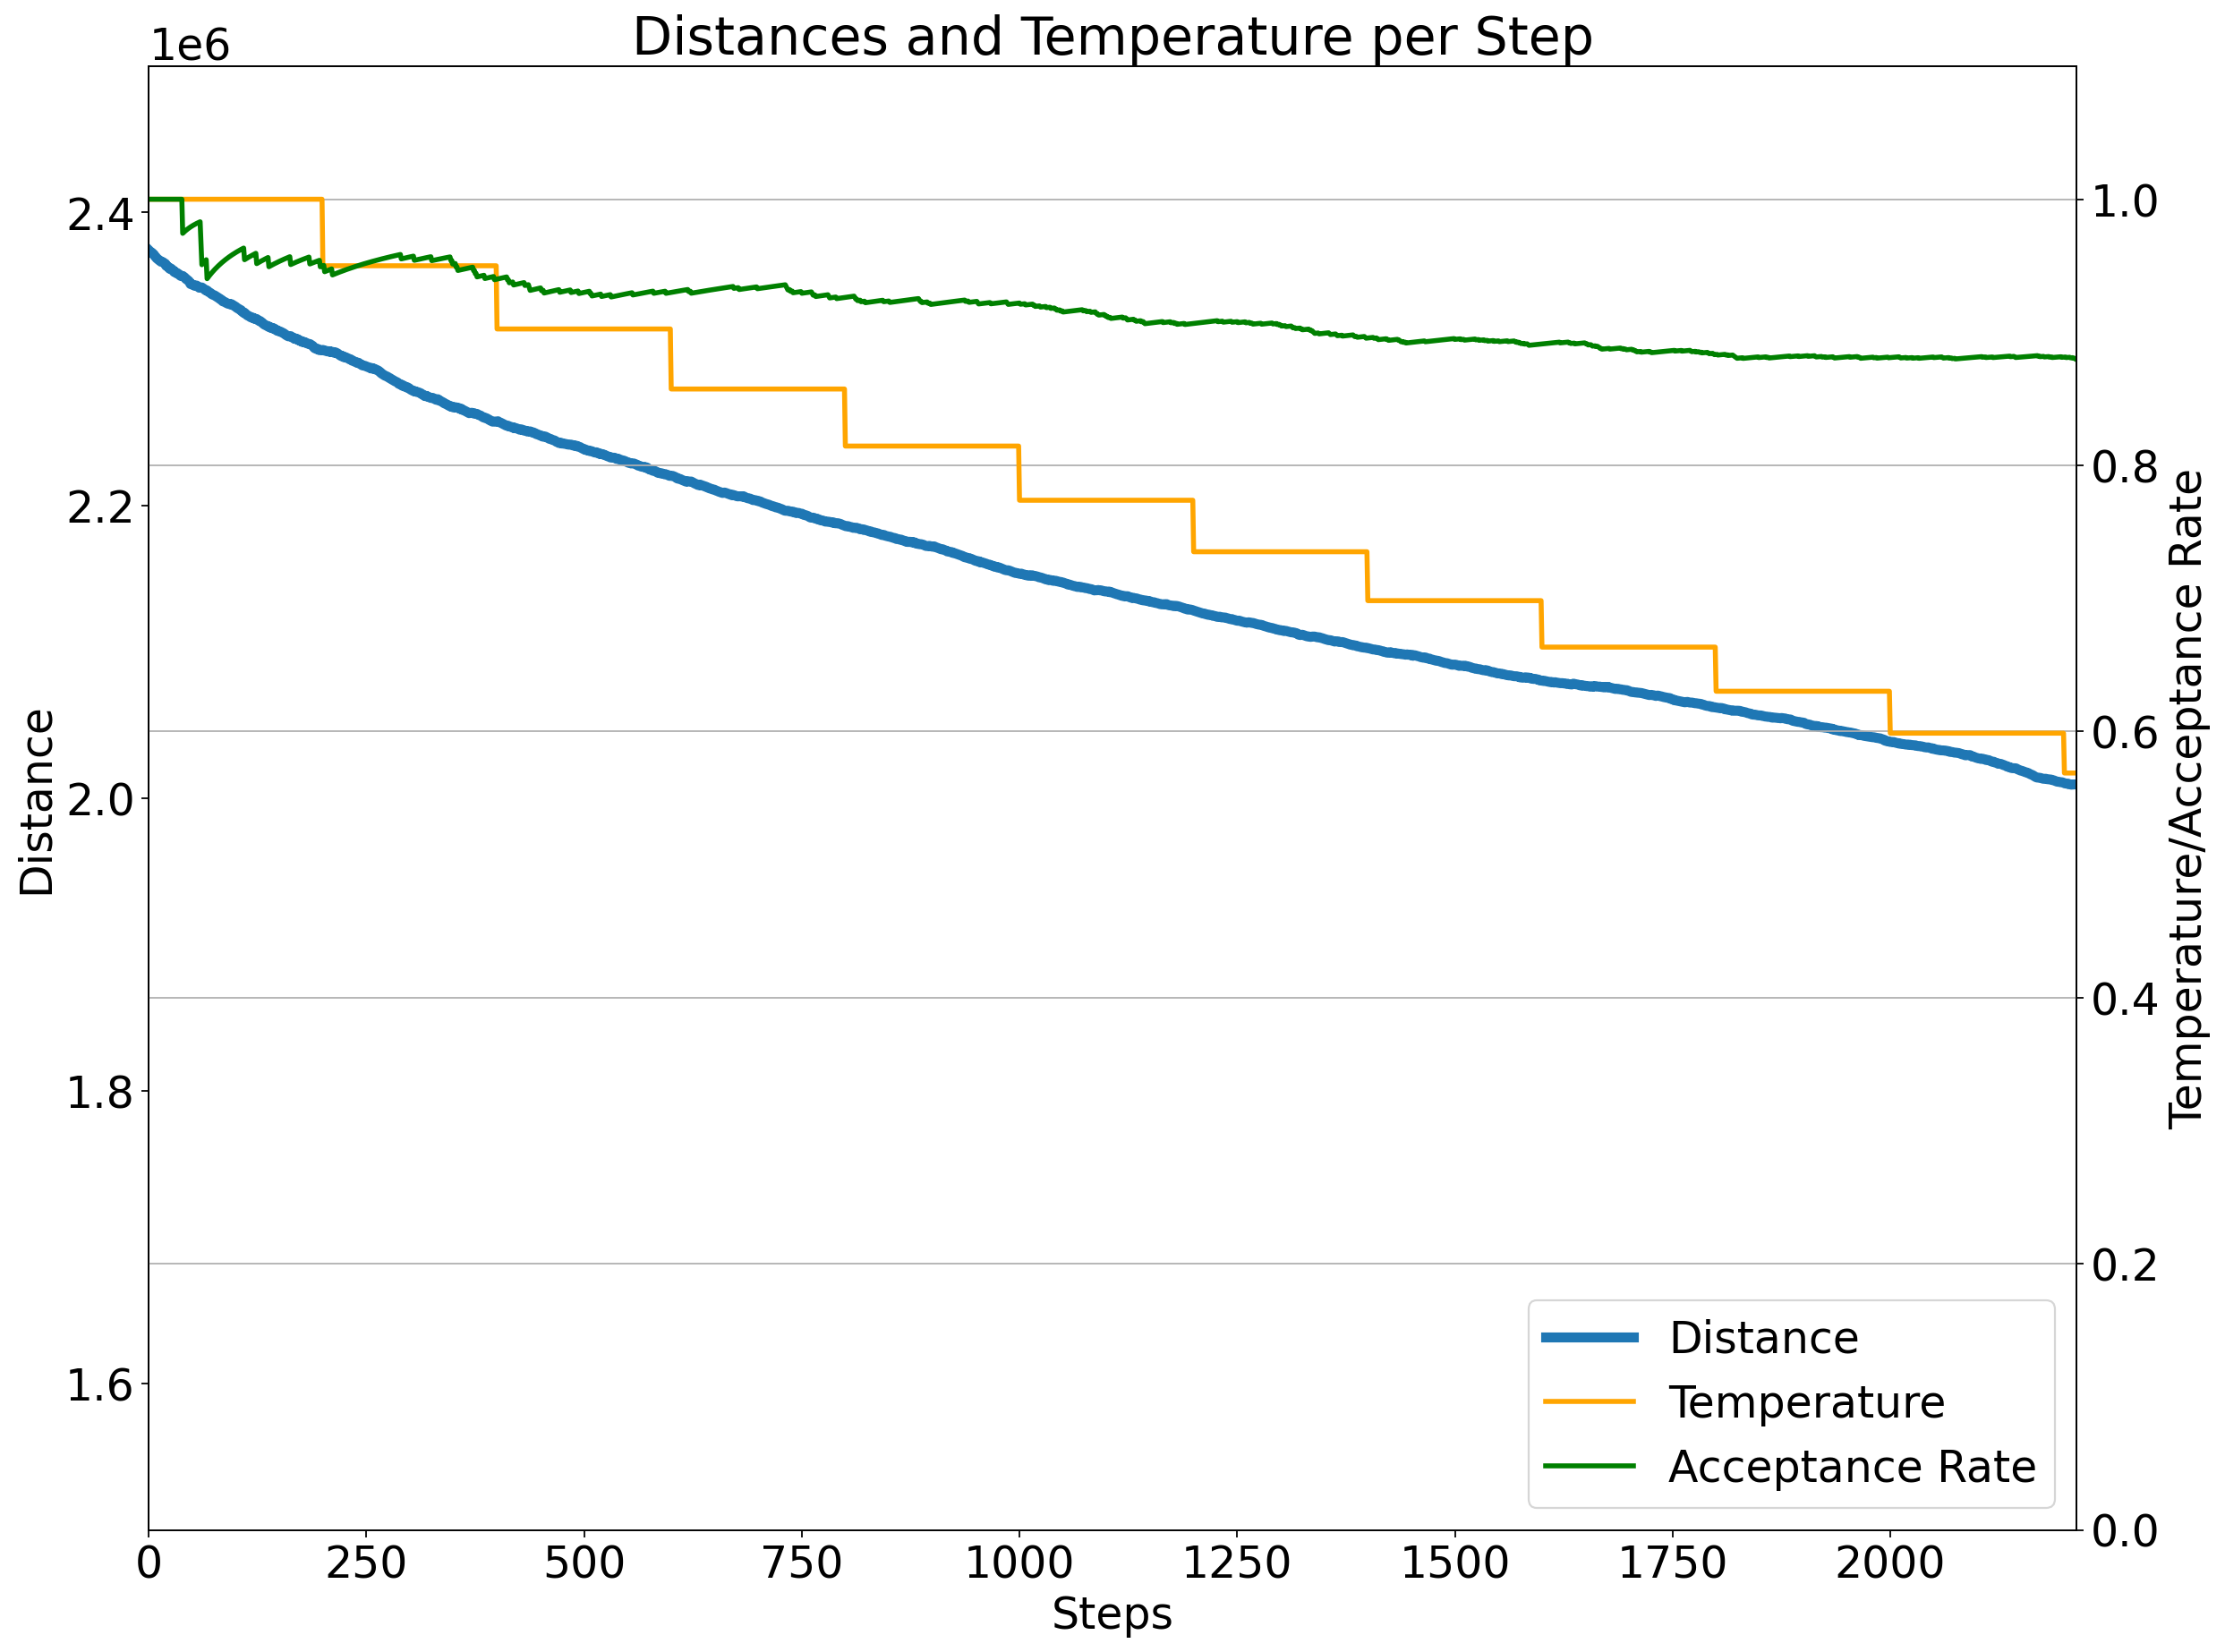

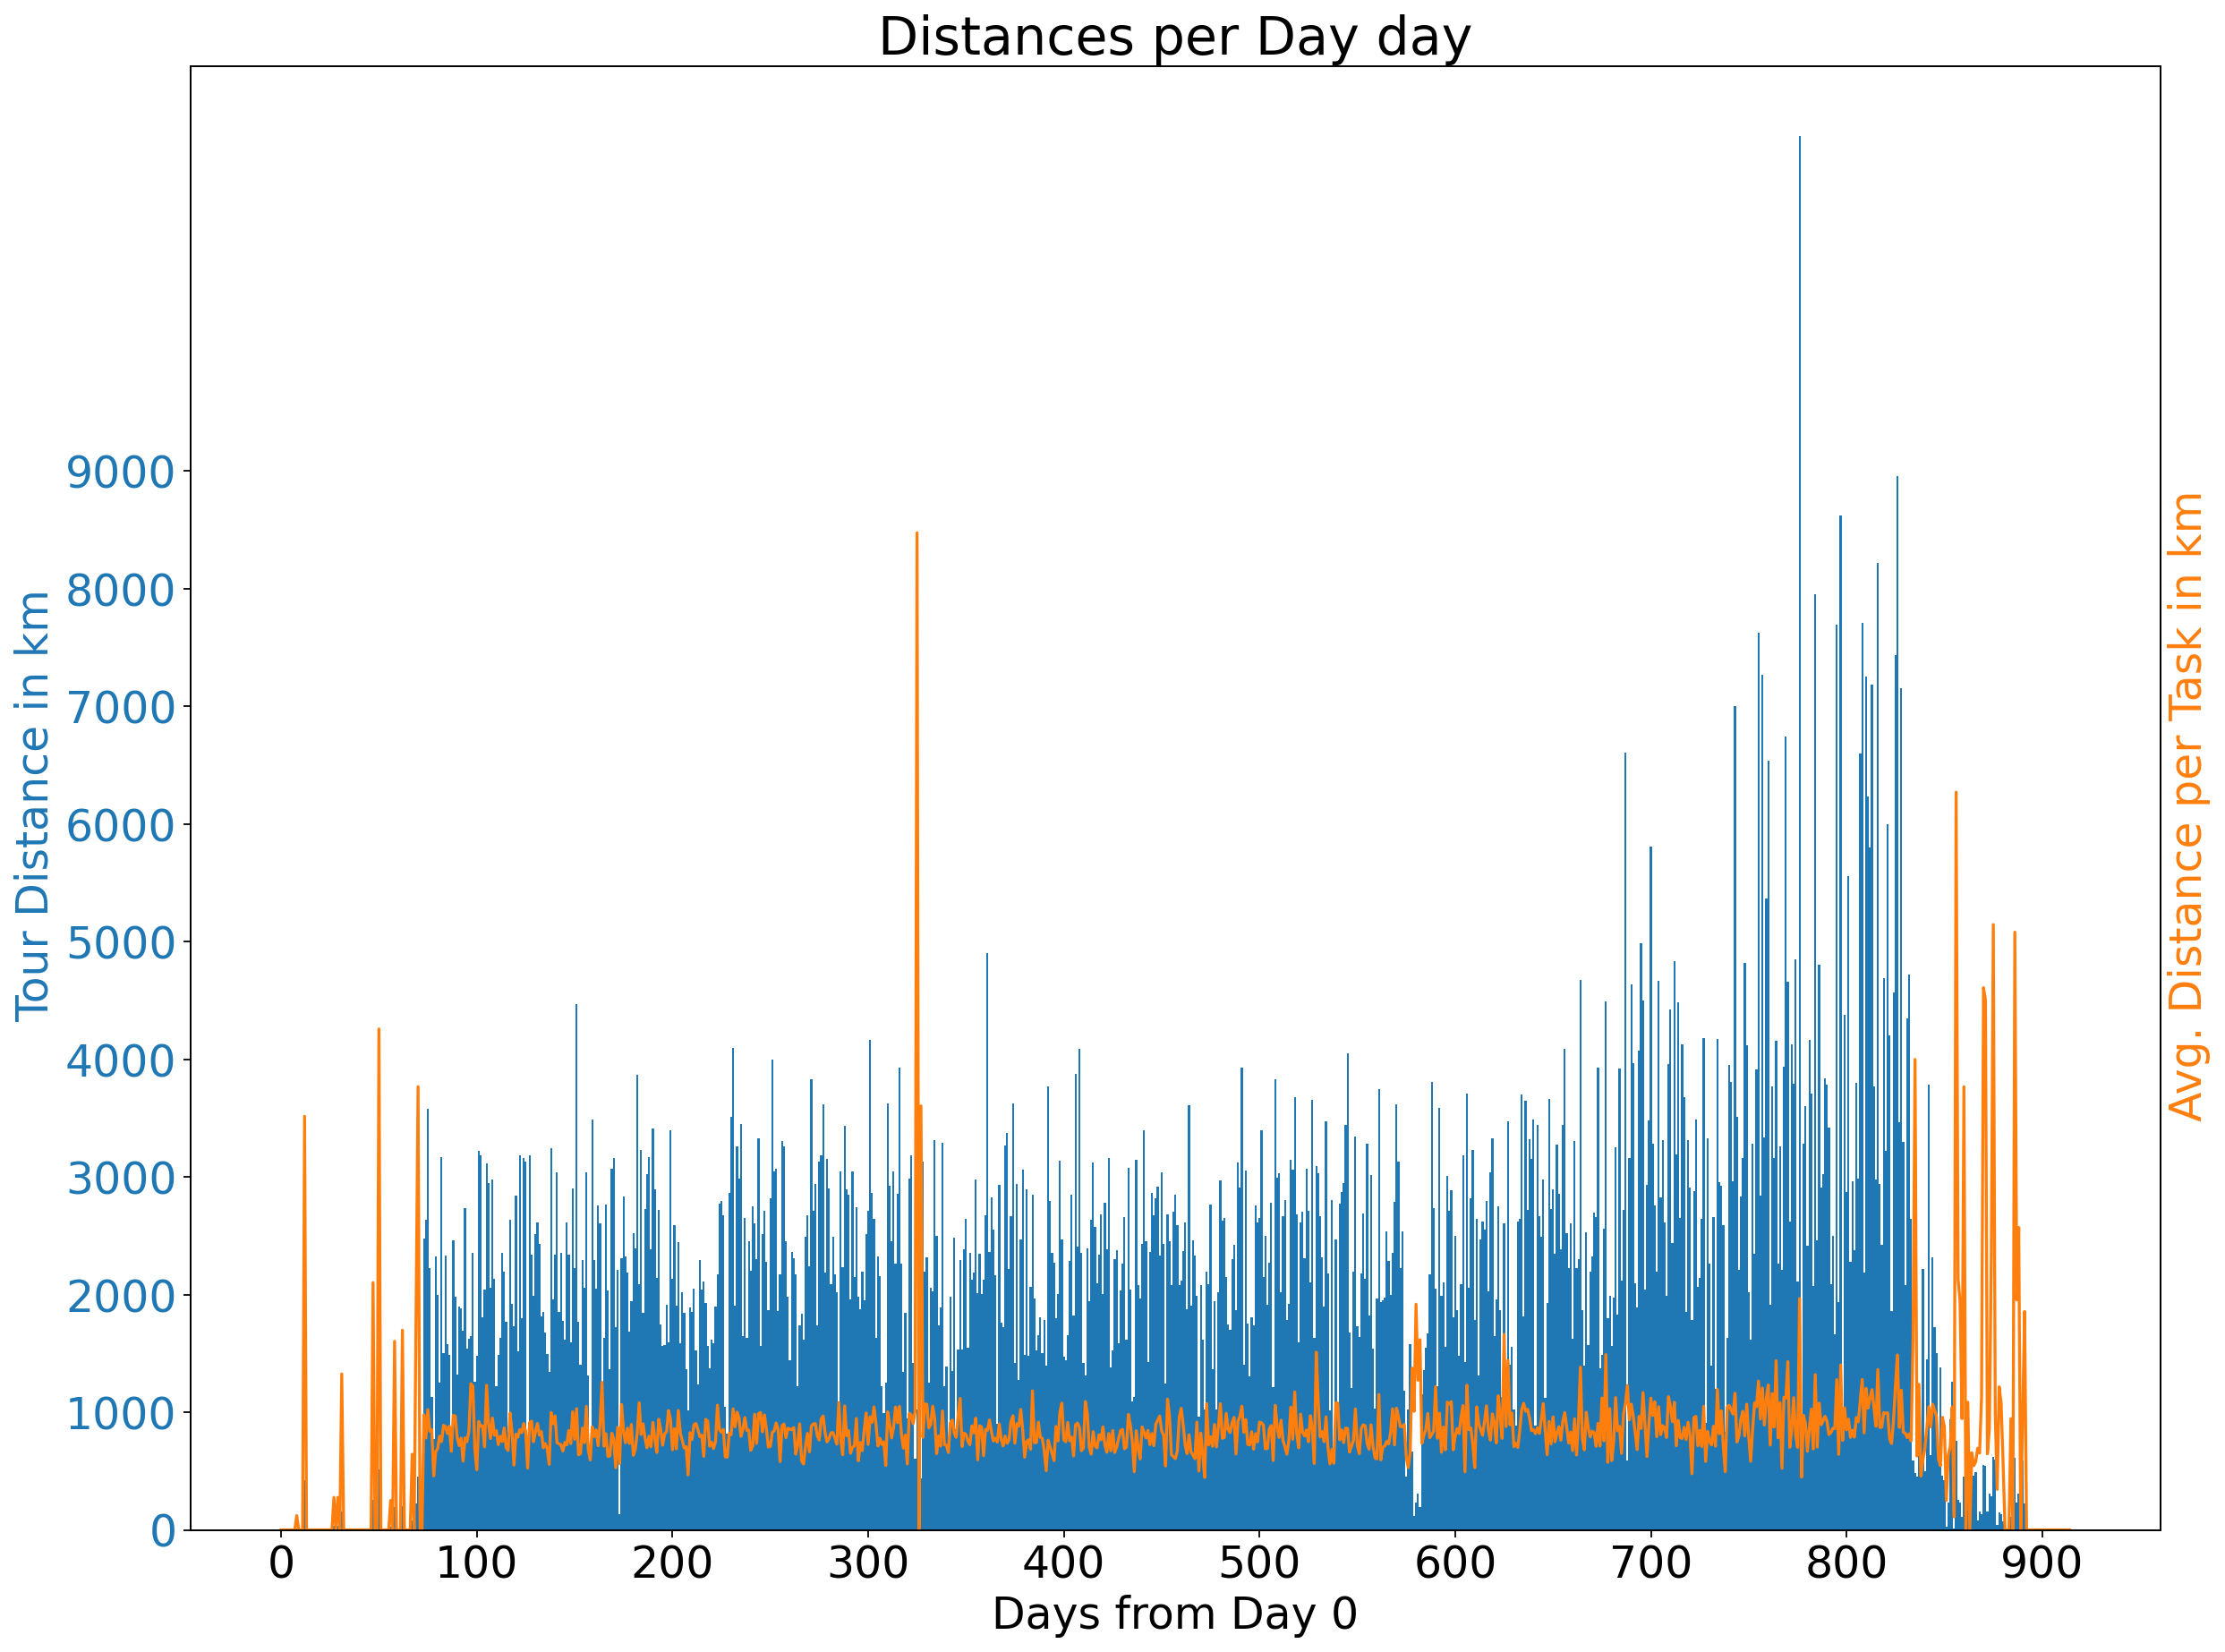

In [13]:
fc.print_log("Start with Stage 1a")

dict_tours_temp = dict_tours

#retrieve avg length
avg_tour_length = solution_initial.total_distance / len(list_days)
print(avg_tour_length)


move_type = 'pickup'
move_count = 0
loop_count = 0
step_count: int = 0
step_count_curr = 0
#check trycount exits for every pair
list_movetypes = ['pair','pickup','dropoff']


#trycount_refill
trycount_refill = 5

#define temperature schedule
temperature = sa.Geometric_Schedule(1,0.95,200)
current_temp = temperature.temp_initial
#define acceptance function
acceptance = sa.NormalizedExponentialAcceptance(avg_tour_length)
#define overall statistic
dict_statistic = {0: [solution_initial.total_distance, temperature.temp_initial, 0,0]}

move_type = 'pickup'


fc.print_log("Start Random Moves with heuristics")
while loop_count < 10000:
    loop_count += 1
    step_count += 1

    #prefill statistics to avoid key errors
    dict_statistic[step_count] = [dict_statistic[step_count-1][0],current_temp, move_count, step_count]
    current_temp = temperature.get_temp(step_count)
    #stop when all move types are explored to death
    if not list_movetypes:
        #try to restore the list 5 times
        fc.print_log("No more movetypes")
        if trycount_refill > 0:
            list_movetypes = ['pair','pickup','dropoff']
            print("refill")
            trycount_refill =-1
            move_type = random.choice(list_movetypes)
        else:
            break

    for depot in dict_depots:

        if move_type == 'pair':
            #find moves
            tour_org, move_job_pickup, move_job_dropoff, pickup_tour_new, dropoff_tour_new = \
                sa.find_pair_move_opposite(depot,dict_tours_temp,list_days)
        else:
            #find move
            tour_org, move_job, tour_new = sa.find_single_move_opposite(move_type, depot, dict_tours_temp,list_days)

        #check if trycount exit happend - if yes remove move type
        if not tour_org:
            fc.print_log("Trycount Exit for {} - it: {}".format(move_type,step_count))
            print(list_movetypes)
            list_movetypes.remove(move_type)
            #check if move types are left
            if list_movetypes:
                move_type = random.choice(list_movetypes)
                print("rechose from {}".format(list_movetypes))
                #fill statistics anyway
                dict_statistic[step_count] = [dict_statistic[step_count-1][0],current_temp, move_count, step_count]
                current_temp = temperature.get_temp(step_count)
                break
            else:
                break

        if move_type == 'pair':
            #evaluate move
            distance_delta_pickup = sa.evaluate_pickup(tour_org,pickup_tour_new,move_job_pickup)
            distance_delta_dropoff = sa.evaluate_dropoff(tour_org,dropoff_tour_new,move_job_dropoff)
            distance_delta_total = distance_delta_pickup + distance_delta_dropoff
        else:
            #evaluate move
            distance_delta_total = sa.evaluate_move(move_type,tour_org,tour_new,move_job)


        #check for acceptance - if accepted, reassign
        if acceptance.get_acc(current_temp,distance_delta_total):

            if move_type == 'pair':
                #perform moves
                sa.reassign_pickup(tour_org,pickup_tour_new,move_job_pickup)
                sa.reassign_dropoff(tour_org,dropoff_tour_new,move_job_dropoff)
            else:
                #perform move
                sa.reassign_job(move_type,tour_org,tour_new,move_job)

            #adjust statistic and leave for loop
            move_count +=1
            current_temp = temperature.get_temp(step_count)

            last_total_distance = dict_statistic[step_count-1][0]
            dict_statistic[step_count] = [last_total_distance + distance_delta_total,\
                                                               current_temp, move_count,step_count]
        else:
            dict_statistic[step_count] = [dict_statistic[step_count-1][0],current_temp, move_count, step_count]
            current_temp = temperature.get_temp(step_count)
        #change move type
        move_type = random.choice(list_movetypes)


    print("Current: Loop: {} - Moves: {}                                  ".format(loop_count,move_count),end='\r')
    #export statistics every n iterations
    for i in range(20):
        if loop_count == 500 * i + 1:
            fc.print_log("logging at %s" % loop_count)
            solution_stage_1atemp = cl.Solution(temp_depot,dict_tours_temp,list_days,dev_curr=dict_statistic)
            solution_stage_1atemp.plot_tasks(50, exp_prefix = img_exp_path + 'over_time/solution_stage1a_L{}_'.format(loop_count),plot=False)
            solution_stage_1atemp.plot_task_proportion(exp_prefix = img_exp_path + 'over_time/solution_stage1a_L{}_'.format(loop_count),plot=False)
            solution_stage_1atemp.plot_developement(exp_prefix = img_exp_path + 'over_time/solution_stage1a_L{}_'.format(loop_count),plot=False)
            solution_stage_1atemp.plot_distances(10000,1500,exp_prefix = img_exp_path + 'over_time/solution_stage1a_L{}_',plot=False)
if loop_count > 9999:
    fc.print_log("Loopcount exit")

fc.print_log("Final: Loop: {} - Moves: {}".format(loop_count,move_count))

fc.print_log("Done with Moves")

solution_stage1a = cl.Solution(temp_depot,dict_tours_temp,list_days,dev_curr=dict_statistic)

solution_stage1a.plot_tasks(50,exp_prefix = img_exp_path + 'solution_stage1a',plot=False)
solution_stage1a.plot_task_proportion(exp_prefix = img_exp_path + 'solution_stage1a',plot=False)
solution_stage1a.plot_developement(exp_prefix = img_exp_path + 'solution_stage1a',plot=False)
solution_stage1a.plot_distances(10000,1500,exp_prefix = img_exp_path + 'solution_stage1a',plot=False)
fc.dict_to_csv(dict_statistic,img_exp_path, 'sa_random_stage_1a')


fc.print_log("Done with Stage 1a")
steps_1a = step_count

#worst pair heuristic

In [14]:
solution_stage1a = cl.Solution(temp_depot,dict_tours_temp,list_days,dev_curr=dict_statistic)
fc.dict_to_csv(dict_statistic,img_exp_path, 'sa_random_stage_1a')
print("old distance: %s" % solution_initial.total_distance)
print("new distance: %s" % solution_stage1a.total_distance)






old distance: 2374315.453137417
new distance: 1978475.5447116839


In [15]:
sys.setrecursionlimit(100000)
fc.save_object(solution_stage1a, img_exp_path + 'solution_stage1a.pkl')


In [16]:
#plt.savefig("Test")